# SSCx Dissemination.

We analyze circuits developed under the SSCx Dissemination project.


In [1]:
from collections import OrderedDict
from tqdm import tqdm
from dmt.tk.plotting import Bars, LinePlot, Crosses
from dmt.data.observation import measurement
from dmt.tk.plotting.multi import MultiPlot
from neuro_dmt.models.bluebrain.circuit.geometry import Cuboid
from neuro_dmt.library.users.visood.sscx_dissemination.analyses import *

While using this notebook for development, we might need to reload the adapter:

In [2]:
spec = AnalysisSpec()
spec.field_dict

{'morphologies_interneurons': ['BP',
  'BTC',
  'CHC',
  'DB',
  'LBC',
  'NBC',
  'MC',
  'SBC',
  'SSC'],
 'number_cortical_thickness_bins': 50,
 'path_reports': '/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports',
 'sample_size': 100,
 'size_roi': array([50., 50., 50.])}

In [3]:
#reload
from importlib import reload
from neuro_dmt.analysis import circuit as ca
from neuro_dmt.models.bluebrain.circuit.adapter import adapter as ad
from neuro_dmt.models.bluebrain.circuit import model as md
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.tools\
    import pathway_measurement as pm
from neuro_dmt.analysis import reporting as rp
adapter =\
    ad.BlueBrainCircuitAdapter()
model =\
    md.BlueBrainCircuitModel()
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))

In [4]:
sscxdiss = SSCxDisseminationCircuits()
sscxdiss.variations

bio0: Not Available
bio1: Not Available
bio2: Not Available
bio3: Not Available
bio4: Not Available
bio5: Not Available
biom: 'Bio_M/20191206'
mock: 'MOCK'

We will need to parameterize our analysis:

In [5]:
circuit_model = sscxdiss.get(sscxdiss.variations.mock)
#circuit_model = sscxdiss.circuit(sscxdiss.variations.biom)
adapter = sscxdiss.adapter

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/mock/circuit.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
Build a Mock Circuit.
82304it [02:40, 514.27it/s]


 We will develop our analysis of the SSCx Dissemination circuits as a growing
 list of analyzed phenomena:

In [6]:
phenomenon = OrderedDict()

For each **DMT** analysis we will need to define an interface defining the
methods that the analysis uses to query a circuit model.
Instead of defining an interface for each analysis, we have collected all the
interface methods for composition and connectome analyses:

In [8]:
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.composition\
    import CompositionAnalysesSuite
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.connectome.suite\
    import ConnectomeAnalysesSuite

CompositionAdapterInterface = CompositionAnalysesSuite.AdapterInterface
ConnectomeAdapterInterface = ConnectomeAnalysesSuite.AdapterInterface

To save reports, we will use a reporter.

In [9]:
from neuro_dmt.analysis.reporting import CheetahReporter
reporter = CheetahReporter(
    path_output_folder=os.path.join(
        spec.path_reports, "analyses"))

# Circuit Composition
Rat *Somatoseonsory Cortex* circuits are atlas based.
Four sub-regions of the SSCx were populated:ec

In [10]:
populated_regions =\
    adapter.get_brain_regions(circuit_model)
populated_regions

('S1HL', 'S1FL', 'S1Tr', 'S1Sh')

We will use parameters to measure composition phenomena:

In [11]:
def get_regions(adapter, model):
    """
    Get regions...
    """
    return pd.DataFrame(
        adapter.get_brain_regions(model),
        columns=["region"])

def get_layers(adapter, model):
    """..."""
    return pd.DataFrame(
        adapter.get_layers(model),
        columns=["layer"])
    
def get_regions_and_layers(adapter, model):
    """
    Get regions and layers for the model.
    """
    regions = adapter.get_brain_regions(model)
    layers = adapter.get_layers(model)
    return pd.DataFrame(
        [[region, layer] for region in regions for layer in layers],
        columns=["region", "layer"])

We can count the number of cells in each region.
We will use **DMT** to define and run analyses. 
A DMT analysis requires a method to measure the analyzed phenomenon.
We define such a method to count cells:

## SSCx Subregions

Four sub-regions of the SSCx were populated:

### Region Volumes

To get an idea about the relative sizes of layers and sub-regions, we analyze
the volume of each modulated sub-region, layer pair in the circuit.

In [12]:
reload(ca)
def measurement_region_volume(
        adapter, circuit_model,
        **query):
    """
    Volume of the region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.get_spatial_volume(circuit_model, **spatial_query)

def add_total_volume(measurement):
    return\
        pd.concat([
            measurement,
            measurement.groupby(["dataset", "region"])\
                       .agg("sum")\
                       .assign(layer="total")\
                       .reset_index()\
                       .set_index(["dataset", "region", "layer"])])

phenomenon["region_volume"] =\
    Phenomenon(
        "Volume",
        description="Volume of a brain-region.",
        group="Composition")
analysis_region_volumes =\
    ca.BrainCircuitAnalysis(
        phenomenon=phenomenon["region_volume"],
        introduction="""
        Volumes of the populated subregions and layers of SSCx are analyzed.
        """,
        methods="""
        Voxels were counted in each sub-region, layer were counted and 
        multiplied with voxel volume.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers, labels=["region", "layer"]),
        sample_measurement=measurement_region_volume,
        add_columns = add_total_volume,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="volume",
                     ylabel="Volume",
                     gvar="layer"),
        report=CircuitAnalysisReport)
analysis_region_volumes.label

'volume-by-region_layer'

100%|██████████| 24/24 [02:56<00:00,  7.39s/it]


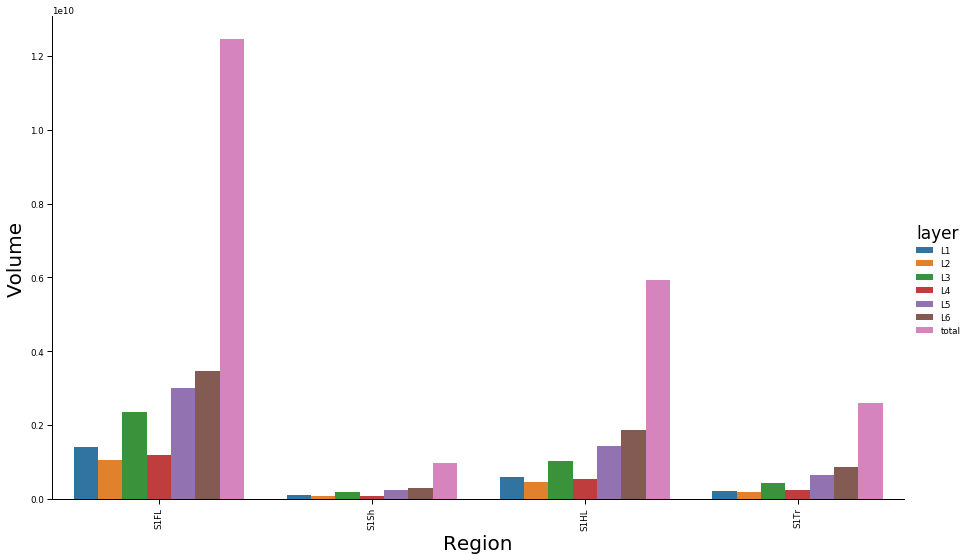

In [23]:
report_volumes = analysis_region_volumes(circuit_model, adapter)

In [13]:
reload(rp)
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))
reporter.post(report_volumes)

NameError: name 'report_volumes' is not defined

### Layer Thickness

Layer thickness is tricky to define for an atlas based circuit.
We expect that for a given sub-region a sample of layer thicknesses can be drawn.
Our next analysis uses this technique and plots the distribution of drawn samples
for each sub-region.

In [14]:
sm = measurement_thickness(adapter, circuit_model, region="S1HL")

NameError: name 'measurement_thickness' is not defined

In [15]:
def measurement_thickness(
        adapter, circuit_model,
        region=None,
        **kwargs):
    """
    Measure layer thickness in the given region.
    """
    wide = adapter.get_layer_thickness_values(circuit_model, region=region)
    wide.columns.name = "layer"
    return\
        pd.concat([wide.iloc[i] for i in range(wide.shape[0])])\
          .rename("thickness")

In [16]:
phenomenon["thickness"] =\
    Phenomenon(
        "Thickness",
        description="Thickness of layers.",
        group="Composition")

analysis_layer_thickness =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["thickness"],
        introduction="""
        Thickness of layers measured in each region modeled in the circuit.
        """,
        methods="""
        Thickness of layers were measured as the shortest top-bottom line
        passing through each voxel in the voxelized space.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions),
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_measurement=measurement_thickness,
        measurement_collection=measurement.collection.series_type,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="thickness",
                     ylabel="Thickness",
                     gvar="layer"),
        report=CircuitAnalysisReport)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:24<01:12, 24.28s/it]



 50%|█████     | 2/4 [00:50<00:49, 24.99s/it]



 75%|███████▌  | 3/4 [01:13<00:24, 24.37s/it]



100%|██████████| 4/4 [01:37<00:00, 24.27s/it]


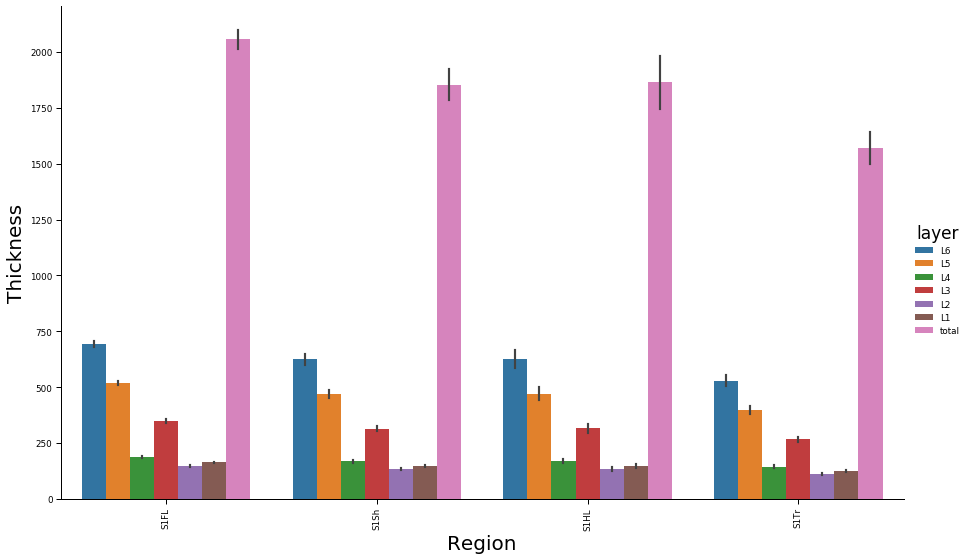

In [97]:
report_thickness =\
    analysis_layer_thickness(circuit_model, adapter)

In [98]:
reporter.post(report_thickness)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x19b46dcd0>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:56:00>                                                      
Post report thickness at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visoo

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/thickness/20200306/175218'

# Measuring serially

In the analyses runs above, measurement was made in a batch consisting of all
the parameter sets. If processing a single parameter set may take long, we 
may want to process a single parameter-set at a time, and save the results.

In [48]:
reload(ca)
analysis_layer_thickness_serially =\
    ca.BrainCircuitAnalysis(
        phenomenon=phenomenon["thickness"],
        introduction="""
        Thickness of layers measured in each region modeled in the circuit.
        """,
        methods="""
        Thickness of layers were measured as the shortest top-bottom line
        passing through each voxel in the voxelized space.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions, labels=["region"]),
        processing_methodology=terminology.processing_methodology.serial,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_measurement=measurement_thickness,
        measurement_collection=measurement.collection.series_type,
        plotter=MultiPlot(
            mvar="region",
            plotter=Bars(xvar="layer",
                         xlabel="Layer",
                         yvar="thickness",
                         ylabel="Thickness",
                         title="region")),
        report=CircuitAnalysisReport)

In [49]:
serial_measurement =\
    analysis_layer_thickness_serially._get_measurement_serially(circuit_model, adapter)

In [19]:
serial_reports =\
    analysis_layer_thickness_serially(
        circuit_model, adapter)

 25%|██▌       | 1/4 [02:39<07:59, 159.91s/it]

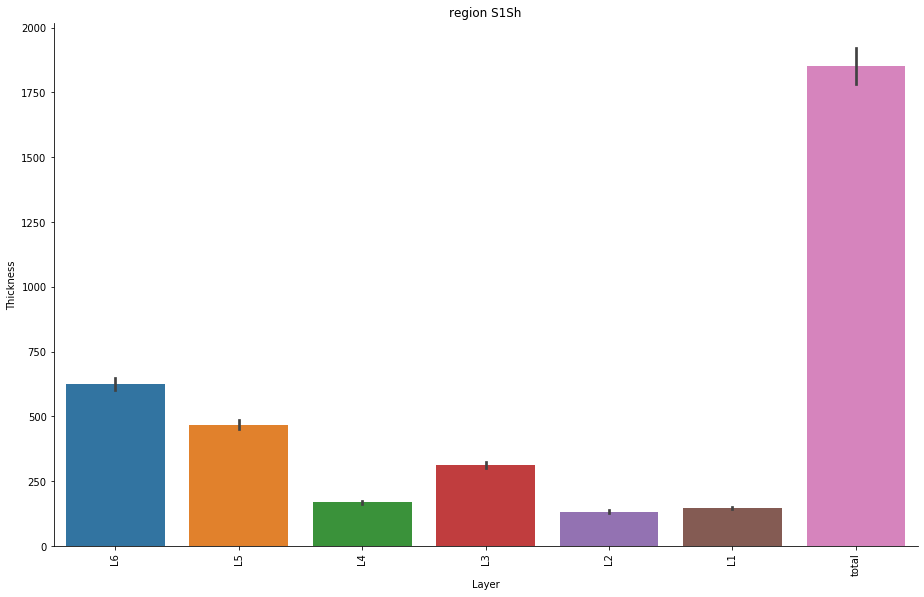

In [22]:
sr = next(serial_reports)

In [23]:
reload(rp)
reporter = rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))
reporter.post(
    sr.sub_report,
    with_time_stamp=os.path.join("20200310", "1503"),
    output_subfolder=sr.label)

'/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/thickness_by_region/20200310/1503/region_s1sh'

In [29]:
sr.label, sr.sub_report.label

('region_s1sh', 'thickness_by_region')

In [34]:
analysis_layer_thickness_serially.label

'thickness_by_'



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:26<01:18, 26.20s/it]

 50%|█████     | 2/4 [00:59<00:56, 28.46s/it]

 75%|███████▌  | 3/4 [01:26<00:27, 27.80s/it]

100%|██████████| 4/4 [01:52<00:00, 27.41s/it]



{'region_s1fl': '/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/thickness-by-region/20200310/161830/region_s1fl',
 'region_s1sh': '/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/thickness-by-region/20200310/161830/region_s1sh',
 'region_s1hl': '/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/thickness-by-region/20200310/161830/region_s1hl',
 'region_s1tr': '/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/thickness-by-region/20200310/161830/region_s1tr'}

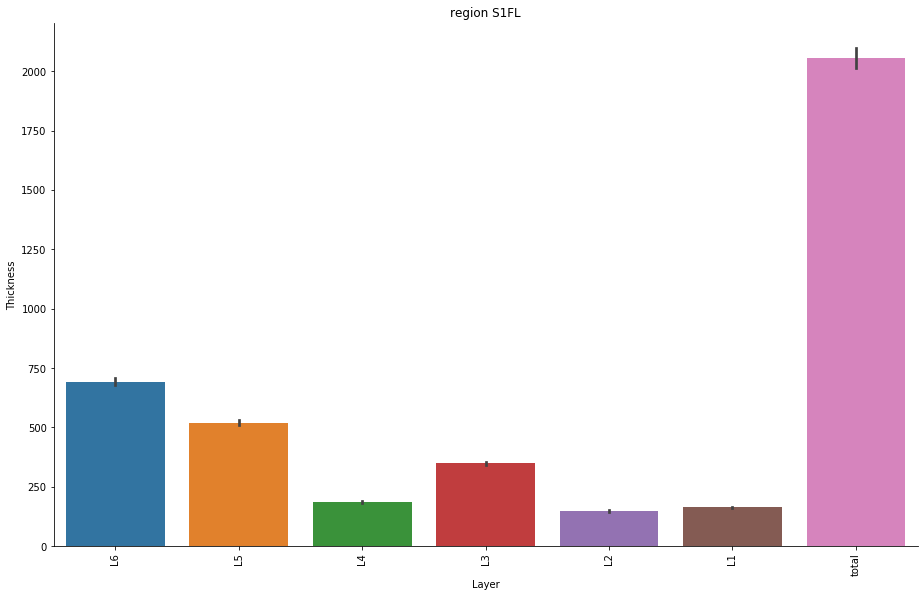

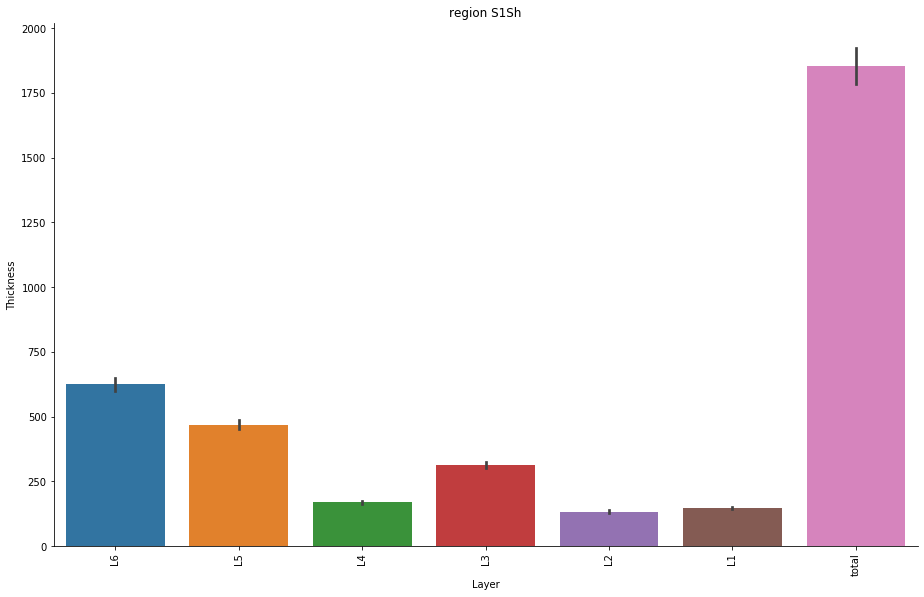

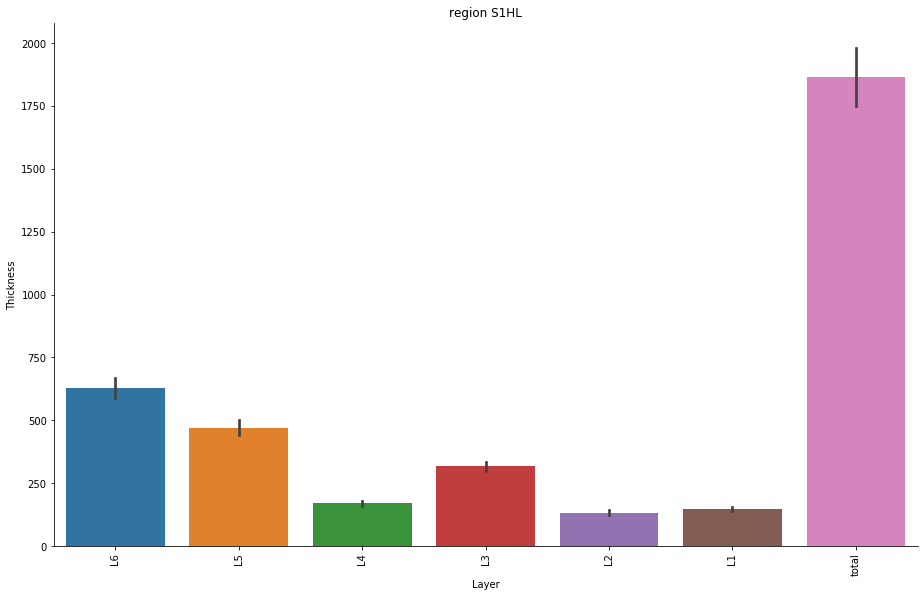

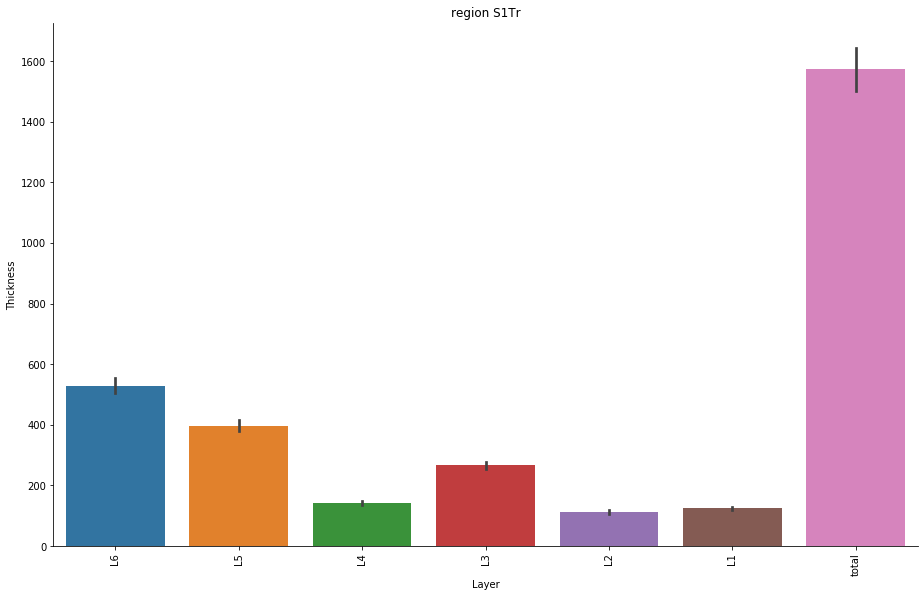

In [51]:
reload(rp)
reporter = rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))
reporter.post(
    analysis_layer_thickness_serially(
        circuit_model, adapter))

In [165]:
reload(ca)
analysis_region_volumes_serially =\
    ca.BrainCircuitAnalysis(
        phenomenon=phenomenon["region_volume"],
        introduction="""
        Volumes of the populated subregions and layers of SSCx are analyzed.
        """,
        methods="""
        Voxels were counted in each sub-region, layer were counted and 
        multiplied with voxel volume.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_region_volume,
        add_columns = add_total_volume,
        processing_methodology=terminology.processing_methodology.serial,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="volume",
                     ylabel="Volume",
                     gvar="layer"),
        report=CircuitAnalysisReport)


In [167]:
serial_measurement =\
    analysis_region_volumes_serially._get_measurement_serially(
        circuit_model, adapter)

In [168]:
sm = next(serial_measurement)
sm.head()





















  0%|          | 0/24 [00:00<?, ?it/s]

,,,volume
dataset,region,layer,
BlueBrainCircuitModel,S1FL,L1,1.392253e+09


In [169]:
sm

,,,volume
dataset,region,layer,
BlueBrainCircuitModel,S1FL,L1,1.392253e+09


In [111]:
analysis_region_volumes_serially.get_measurement(
    circuit_model, adapter, parameter_set={"layer": "L1", "region": "S1HL"})

586110929.8632812

In [120]:
p = {"region": "S1HL", "layer": "L1"}
sm = pd.Series(123123., name="volume")
print(sm)
index = ["dataset"] + list(p.keys())
print(sm.index.names)
if sm.index.names[0] is not None:
    index += sm.index.names
pd.DataFrame(sm)\
  .assign(dataset="DATASET")\
  .assign(**p)\
  .set_index(index)

0    123123.0
Name: volume, dtype: float64
[None]


,,,volume
dataset,region,layer,
DATASET,S1HL,L1,123123.0


In [139]:
sm = pd.DataFrame({"volume": 123123})
sm

index = ["dataset"] + list(p.keys())
print(sm.index.names)
if sm.index.names[0] is not None:
    index += sm.index.names
print(pd.DataFrame(sm))
sm.assign(dataset="DATASET")\
  .assign(**p)\
  .set_index(index)

ValueError: If using all scalar values, you must pass an index

In [128]:
p = {"region": "S1HL", "layer": "L1"}
sm = pd.Series([12021093, 12093123],
               index=pd.Index(["hinga", "haewasd"], name="bung"),
               name="volume")
print(sm)
#sm = pd.Series({"jinga": 123123., "binga": 121212}, name="volume")
print(sm.index.names)
index = ["dataset"] + list(p.keys())
print(sm.index.names)
if sm.index.names[0] is not None:
    index += sm.index.names
print(pd.DataFrame(sm))
pd.DataFrame(sm)\
  .reset_index()\
  .assign(dataset="DATASET")\
  .assign(**p)\
  .set_index(index)


bung
hinga      12021093
haewasd    12093123
Name: volume, dtype: int64
['bung']
['bung']
           volume
bung             
hinga    12021093
haewasd  12093123


volume
dataset region layer bung             
DATASET S1HL   L1    hinga    12021093
                     haewasd  12093123

## Cell Distribution

In this section we study the distribution of cells over the physical geometry
of the circuit.


In [13]:
def random_position(
        adapter, circuit_model,
        **query):
    """
    Random position in circuit region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.random_position(circuit_model, **spatial_query)
    
def random_box(
        adapter, circuit_model, 
        size_roi=100., **query):
    """
    Random cuboid in circuit region specified by `query`.
    """
    position = random_position(adapter, circuit_model, **query)
    return Cuboid(position - size_roi, position + size_roi)\
        if position is not None else None

def measurement_cell_count_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the number of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    return adapter.get_cells(circuit_model, roi=box).shape[0]\
        if box is not None else 0.

### Cell Count

Circuit regions and layers are not the same size, and contain different densities
of cells.

In [14]:
phenomenon["cell_count"] =\
    Phenomenon("Cell Count", 
               description="Number of cells in the circuit.",
               group="Composition")
    
analysis_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_count_using_sampling,
        sample_size=20,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="cell_count",
                     ylabel="Cell Count",
                     gvar="layer"),
        report=CircuitAnalysisReport)
                                       

  0%|          | 0/480 [00:00<?, ?it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L1'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (23956, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed40cb3c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

  0%|          | 1/480 [00:43<5:46:50, 43.45s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d320>}



  0%|          | 2/480 [00:43<4:02:53, 30.49s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d160>}



  1%|          | 3/480 [00:43<2:50:19, 21.42s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6d8>}



  1%|          | 4/480 [00:44<1:59:36, 15.08s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a9e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a9e8>}



  1%|          | 5/480 [00:44<1:24:16, 10.65s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a940>}



  1%|▏         | 6/480 [00:44<59:30,  7.53s/it]  

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acf8>}



  1%|▏         | 7/480 [00:45<42:14,  5.36s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acf8>}



  2%|▏         | 8/480 [00:45<30:13,  3.84s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}



  2%|▏         | 9/480 [00:45<21:44,  2.77s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}



  2%|▏         | 10/480 [00:45<15:52,  2.03s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a7f0>}



  2%|▏         | 11/480 [00:46<11:42,  1.50s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab38>}



  2%|▎         | 12/480 [00:46<08:47,  1.13s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323320>}



  3%|▎         | 13/480 [00:46<06:50,  1.14it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323240>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323240>}



  3%|▎         | 14/480 [00:47<05:26,  1.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}



  3%|▎         | 15/480 [00:47<04:25,  1.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323b00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323b00>}



  3%|▎         | 16/480 [00:47<03:43,  2.07it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}



  4%|▎         | 17/480 [00:47<03:15,  2.37it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323fd0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323fd0>}



  4%|▍         | 18/480 [00:48<02:53,  2.67it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}



  4%|▍         | 19/480 [00:48<02:39,  2.89it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323198>}



  4%|▍         | 20/480 [00:48<02:31,  3.03it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L2'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (18138, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

  4%|▍         | 21/480 [01:00<28:19,  3.70s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acf8>}



  5%|▍         | 22/480 [01:00<20:23,  2.67s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a898>}



  5%|▍         | 23/480 [01:00<14:57,  1.96s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a5f8>}



  5%|▌         | 24/480 [01:01<11:02,  1.45s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}



  5%|▌         | 25/480 [01:01<08:24,  1.11s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}



  5%|▌         | 26/480 [01:01<06:34,  1.15it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}



  6%|▌         | 27/480 [01:02<05:11,  1.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a048>}



  6%|▌         | 28/480 [01:02<04:20,  1.74it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a128>}



  6%|▌         | 29/480 [01:02<03:43,  2.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430af98>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430af98>}



  6%|▋         | 30/480 [01:02<03:13,  2.33it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a048>}



  6%|▋         | 31/480 [01:03<02:52,  2.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a438>}



  7%|▋         | 32/480 [01:03<02:37,  2.85it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323048>}



  7%|▋         | 33/480 [01:03<02:26,  3.04it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}



  7%|▋         | 34/480 [01:04<02:19,  3.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}



  7%|▋         | 35/480 [01:04<02:13,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d080>}



  8%|▊         | 36/480 [01:04<02:08,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a438>}



  8%|▊         | 37/480 [01:04<02:10,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a518>}



  8%|▊         | 38/480 [01:05<02:05,  3.52it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0af28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0af28>}



  8%|▊         | 39/480 [01:05<02:04,  3.55it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0af28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0af28>}



  8%|▊         | 40/480 [01:05<02:03,  3.57it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L3'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (40583, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

  9%|▊         | 41/480 [01:19<31:09,  4.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743234a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743234a8>}



  9%|▉         | 42/480 [01:19<22:20,  3.06s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323278>}



  9%|▉         | 43/480 [01:19<16:17,  2.24s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323278>}



  9%|▉         | 44/480 [01:20<12:01,  1.65s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743237f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743237f0>}



  9%|▉         | 45/480 [01:20<09:01,  1.24s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}



 10%|▉         | 46/480 [01:20<06:54,  1.05it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}



 10%|▉         | 47/480 [01:20<05:27,  1.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab70>}



 10%|█         | 48/480 [01:21<04:29,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a828>}



 10%|█         | 49/480 [01:21<03:44,  1.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}



 10%|█         | 50/480 [01:21<03:13,  2.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}



 11%|█         | 51/480 [01:22<02:49,  2.53it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a400>}



 11%|█         | 52/480 [01:22<02:35,  2.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323780>}



 11%|█         | 53/480 [01:22<02:27,  2.89it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323160>}



 11%|█▏        | 54/480 [01:23<02:20,  3.03it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a828>}



 11%|█▏        | 55/480 [01:23<02:13,  3.19it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acc0>}



 12%|█▏        | 56/480 [01:23<02:13,  3.18it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a240>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a240>}



 12%|█▏        | 57/480 [01:23<02:08,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65550>}



 12%|█▏        | 58/480 [01:24<02:05,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acc0>}



 12%|█▏        | 59/480 [01:24<02:01,  3.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffeea70b6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffeea70b6d8>}



 12%|█▎        | 60/480 [01:24<02:00,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L4'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (20429, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 13%|█▎        | 61/480 [01:36<26:41,  3.82s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 13%|█▎        | 62/480 [01:37<19:14,  2.76s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 13%|█▎        | 63/480 [01:37<14:02,  2.02s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 13%|█▎        | 64/480 [01:37<10:24,  1.50s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 14%|█▎        | 65/480 [01:37<07:53,  1.14s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 14%|█▍        | 66/480 [01:38<06:05,  1.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a4a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a4a8>}



 14%|█▍        | 67/480 [01:38<04:49,  1.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 14%|█▍        | 68/480 [01:38<03:55,  1.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323be0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323be0>}



 14%|█▍        | 69/480 [01:39<03:19,  2.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65390>}



 15%|█▍        | 70/480 [01:39<02:56,  2.33it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0abe0>}



 15%|█▍        | 71/480 [01:39<02:37,  2.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430aa20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430aa20>}



 15%|█▌        | 72/480 [01:39<02:25,  2.80it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743235c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743235c0>}



 15%|█▌        | 73/480 [01:40<02:15,  3.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}



 15%|█▌        | 74/480 [01:40<02:08,  3.16it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0abe0>}



 16%|█▌        | 75/480 [01:40<02:03,  3.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65588>}



 16%|█▌        | 76/480 [01:41<02:03,  3.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e652e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e652e8>}



 16%|█▌        | 77/480 [01:41<01:58,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65b70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65b70>}



 16%|█▋        | 78/480 [01:41<01:55,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e652b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e652b0>}



 16%|█▋        | 79/480 [01:41<01:54,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65eb8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65eb8>}



 17%|█▋        | 80/480 [01:42<01:52,  3.57it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L5'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (51522, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 17%|█▋        | 81/480 [01:56<29:28,  4.43s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}



 17%|█▋        | 82/480 [01:56<21:07,  3.19s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323e48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323e48>}



 17%|█▋        | 83/480 [01:56<15:20,  2.32s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323e48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323e48>}



 18%|█▊        | 84/480 [01:57<11:15,  1.71s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffeb109dcc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffeb109dcc0>}



 18%|█▊        | 85/480 [01:57<08:27,  1.28s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc88>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc88>}



 18%|█▊        | 86/480 [01:57<06:29,  1.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b978>}



 18%|█▊        | 87/480 [01:58<05:08,  1.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323358>}



 18%|█▊        | 88/480 [01:58<04:06,  1.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323da0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323da0>}



 19%|█▊        | 89/480 [01:58<03:28,  1.87it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743231d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743231d0>}



 19%|█▉        | 90/480 [01:58<02:57,  2.19it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b940>}



 19%|█▉        | 91/480 [01:59<02:37,  2.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435be48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435be48>}



 19%|█▉        | 92/480 [01:59<02:23,  2.71it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba90>}



 19%|█▉        | 93/480 [01:59<02:16,  2.84it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b5c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b5c0>}



 20%|█▉        | 94/480 [02:00<02:05,  3.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b5c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b5c0>}



 20%|█▉        | 95/480 [02:00<02:01,  3.18it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b208>}



 20%|██        | 96/480 [02:00<01:59,  3.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b358>}



 20%|██        | 97/480 [02:00<01:54,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b390>}



 20%|██        | 98/480 [02:01<01:52,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b668>}



 21%|██        | 99/480 [02:01<01:50,  3.46it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b390>}



 21%|██        | 100/480 [02:01<01:48,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L6'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (59575, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8e48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 21%|██        | 101/480 [02:20<36:45,  5.82s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8978>}



 21%|██▏       | 102/480 [02:20<26:11,  4.16s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8be0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8be0>}



 21%|██▏       | 103/480 [02:21<18:48,  2.99s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8ac8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8ac8>}



 22%|██▏       | 104/480 [02:21<13:40,  2.18s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8160>}



 22%|██▏       | 105/480 [02:21<10:04,  1.61s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8080>}



 22%|██▏       | 106/480 [02:21<07:36,  1.22s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65be0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65be0>}



 22%|██▏       | 107/480 [02:22<05:52,  1.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65940>}



 22%|██▎       | 108/480 [02:22<04:34,  1.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}



 23%|██▎       | 109/480 [02:22<03:46,  1.64it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65278>}



 23%|██▎       | 110/480 [02:23<03:11,  1.93it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8518>}



 23%|██▎       | 111/480 [02:23<02:43,  2.26it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8518>}



 23%|██▎       | 112/480 [02:23<02:29,  2.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8668>}



 24%|██▎       | 113/480 [02:23<02:13,  2.74it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}



 24%|██▍       | 114/480 [02:24<02:07,  2.86it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb87b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb87b8>}



 24%|██▍       | 115/480 [02:24<01:58,  3.09it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323358>}



 24%|██▍       | 116/480 [02:24<01:56,  3.11it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743237f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743237f0>}



 24%|██▍       | 117/480 [02:25<01:52,  3.24it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}



 25%|██▍       | 118/480 [02:25<01:47,  3.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323208>}



 25%|██▍       | 119/480 [02:25<01:50,  3.26it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8a58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8a58>}



 25%|██▌       | 120/480 [02:25<01:46,  3.37it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L1'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (1793, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 25%|██▌       | 121/480 [02:35<18:47,  3.14s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b7f0>}



 25%|██▌       | 122/480 [02:36<13:35,  2.28s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b6a0>}



 26%|██▌       | 123/480 [02:36<10:01,  1.69s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b6a0>}



 26%|██▌       | 124/480 [02:36<07:28,  1.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e650f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e650f0>}



 26%|██▌       | 125/480 [02:36<05:43,  1.03it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b748>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b748>}



 26%|██▋       | 126/480 [02:37<04:27,  1.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8748>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8748>}



 26%|██▋       | 127/480 [02:37<03:36,  1.63it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65a20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65a20>}



 27%|██▋       | 128/480 [02:37<02:58,  1.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65a20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65a20>}



 27%|██▋       | 129/480 [02:37<02:32,  2.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}



 27%|██▋       | 130/480 [02:38<02:19,  2.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}



 27%|██▋       | 131/480 [02:38<02:07,  2.73it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8160>}



 28%|██▊       | 132/480 [02:38<01:57,  2.96it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65588>}



 28%|██▊       | 133/480 [02:39<01:51,  3.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}



 28%|██▊       | 134/480 [02:39<01:44,  3.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}



 28%|██▊       | 135/480 [02:39<01:42,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba20>}



 28%|██▊       | 136/480 [02:39<01:38,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc50>}



 29%|██▊       | 137/480 [02:40<01:40,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc50>}



 29%|██▉       | 138/480 [02:40<01:42,  3.34it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036550>}



 29%|██▉       | 139/480 [02:40<01:38,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c0362e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c0362e8>}



 29%|██▉       | 140/480 [02:41<01:37,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L2'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (1325, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 29%|██▉       | 141/480 [02:50<17:51,  3.16s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b198>}



 30%|██▉       | 142/480 [02:51<12:55,  2.29s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435be10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435be10>}



 30%|██▉       | 143/480 [02:51<09:31,  1.70s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036080>}



 30%|███       | 144/480 [02:51<07:05,  1.27s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036320>}



 30%|███       | 145/480 [02:52<05:28,  1.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036cf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036cf8>}



 30%|███       | 146/480 [02:52<04:15,  1.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}



 31%|███       | 147/480 [02:52<03:29,  1.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}



 31%|███       | 148/480 [02:52<02:56,  1.88it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}



 31%|███       | 149/480 [02:53<02:32,  2.17it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}



 31%|███▏      | 150/480 [02:53<02:13,  2.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c0364a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c0364a8>}



 31%|███▏      | 151/480 [02:53<02:00,  2.73it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036c88>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036c88>}



 32%|███▏      | 152/480 [02:54<01:50,  2.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036d68>}



 32%|███▏      | 153/480 [02:54<01:45,  3.09it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036d68>}



 32%|███▏      | 154/480 [02:54<01:39,  3.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036b70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036b70>}



 32%|███▏      | 155/480 [02:54<01:35,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036b70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036b70>}



 32%|███▎      | 156/480 [02:55<01:37,  3.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b0f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b0f0>}



 33%|███▎      | 157/480 [02:55<01:34,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036a90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036a90>}



 33%|███▎      | 158/480 [02:55<01:34,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036128>}



 33%|███▎      | 159/480 [02:56<01:31,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036e80>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036e80>}



 33%|███▎      | 160/480 [02:56<01:34,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L3'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (3018, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 34%|███▎      | 161/480 [03:06<16:58,  3.19s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}



 34%|███▍      | 162/480 [03:06<12:18,  2.32s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}



 34%|███▍      | 163/480 [03:06<09:04,  1.72s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036470>}



 34%|███▍      | 164/480 [03:07<06:45,  1.28s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba20>}



 34%|███▍      | 165/480 [03:07<05:09,  1.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfdd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfdd8>}



 35%|███▍      | 166/480 [03:07<04:00,  1.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe80>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe80>}



 35%|███▍      | 167/480 [03:08<03:16,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe80>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe80>}



 35%|███▌      | 168/480 [03:08<02:42,  1.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfdd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfdd8>}



 35%|███▌      | 169/480 [03:08<02:19,  2.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfef0>}



 35%|███▌      | 170/480 [03:08<02:06,  2.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}



 36%|███▌      | 171/480 [03:09<01:54,  2.70it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036cf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036cf8>}



 36%|███▌      | 172/480 [03:09<01:47,  2.88it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab00>}



 36%|███▌      | 173/480 [03:09<01:39,  3.07it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b0f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b0f0>}



 36%|███▋      | 174/480 [03:10<01:37,  3.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb70>}



 36%|███▋      | 175/480 [03:10<01:32,  3.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb00>}



 37%|███▋      | 176/480 [03:10<01:32,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb00>}



 37%|███▋      | 177/480 [03:10<01:31,  3.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf550>}



 37%|███▋      | 178/480 [03:11<01:28,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe48>}



 37%|███▋      | 179/480 [03:11<01:28,  3.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe48>}



 38%|███▊      | 180/480 [03:11<01:28,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L4'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (1547, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 38%|███▊      | 181/480 [03:21<15:49,  3.18s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfc50>}



 38%|███▊      | 182/480 [03:21<11:26,  2.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf748>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf748>}



 38%|███▊      | 183/480 [03:22<08:23,  1.70s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf2b0>}



 38%|███▊      | 184/480 [03:22<06:15,  1.27s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}



 39%|███▊      | 185/480 [03:22<04:48,  1.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}



 39%|███▉      | 186/480 [03:23<03:46,  1.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}



 39%|███▉      | 187/480 [03:23<03:03,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}



 39%|███▉      | 188/480 [03:23<02:33,  1.91it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}



 39%|███▉      | 189/480 [03:23<02:11,  2.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}



 40%|███▉      | 190/480 [03:24<01:56,  2.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfa90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfa90>}



 40%|███▉      | 191/480 [03:24<01:45,  2.74it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf6a0>}



 40%|████      | 192/480 [03:24<01:39,  2.91it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf668>}



 40%|████      | 193/480 [03:25<01:32,  3.10it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf588>}



 40%|████      | 194/480 [03:25<01:28,  3.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf588>}



 41%|████      | 195/480 [03:25<01:26,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e6d8>}



 41%|████      | 196/480 [03:25<01:24,  3.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e780>}



 41%|████      | 197/480 [03:26<01:22,  3.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e6d8>}



 41%|████▏     | 198/480 [03:26<01:21,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e240>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e240>}



 41%|████▏     | 199/480 [03:26<01:20,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e940>}



 42%|████▏     | 200/480 [03:27<01:19,  3.52it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L5'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (4035, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036c50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 42%|████▏     | 201/480 [03:37<14:54,  3.21s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e630>}



 42%|████▏     | 202/480 [03:37<10:47,  2.33s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eef0>}



 42%|████▏     | 203/480 [03:37<07:54,  1.71s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eef0>}



 42%|████▎     | 204/480 [03:37<05:55,  1.29s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef60>}



 43%|████▎     | 205/480 [03:38<04:31,  1.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed30>}



 43%|████▎     | 206/480 [03:38<03:31,  1.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e978>}



 43%|████▎     | 207/480 [03:38<02:50,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}



 43%|████▎     | 208/480 [03:39<02:21,  1.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}



 44%|████▎     | 209/480 [03:39<02:01,  2.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}



 44%|████▍     | 210/480 [03:39<01:47,  2.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e780>}



 44%|████▍     | 211/480 [03:39<01:37,  2.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e940>}



 44%|████▍     | 212/480 [03:40<01:30,  2.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed68>}



 44%|████▍     | 213/480 [03:40<01:25,  3.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed68>}



 45%|████▍     | 214/480 [03:40<01:21,  3.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}



 45%|████▍     | 215/480 [03:41<01:21,  3.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}



 45%|████▌     | 216/480 [03:41<01:17,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eeb8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eeb8>}



 45%|████▌     | 217/480 [03:41<01:15,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d358>}



 45%|████▌     | 218/480 [03:41<01:15,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2e8>}



 46%|████▌     | 219/480 [03:42<01:14,  3.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d630>}



 46%|████▌     | 220/480 [03:42<01:12,  3.58it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L6'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (4965, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 46%|████▌     | 221/480 [03:52<14:01,  3.25s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}



 46%|████▋     | 222/480 [03:52<10:07,  2.35s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036518>}



 46%|████▋     | 223/480 [03:53<07:24,  1.73s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d710>}



 47%|████▋     | 224/480 [03:53<05:31,  1.29s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d710>}



 47%|████▋     | 225/480 [03:53<04:12,  1.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}



 47%|████▋     | 226/480 [03:53<03:16,  1.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33db00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33db00>}



 47%|████▋     | 227/480 [03:54<02:37,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d940>}



 48%|████▊     | 228/480 [03:54<02:10,  1.94it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d128>}



 48%|████▊     | 229/480 [03:54<01:51,  2.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d208>}



 48%|████▊     | 230/480 [03:55<01:37,  2.55it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d470>}



 48%|████▊     | 231/480 [03:55<01:28,  2.81it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d898>}



 48%|████▊     | 232/480 [03:55<01:21,  3.05it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d470>}



 49%|████▊     | 233/480 [03:55<01:16,  3.24it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}



 49%|████▉     | 234/480 [03:56<01:14,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}



 49%|████▉     | 235/480 [03:56<01:11,  3.42it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dba8>}



 49%|████▉     | 236/480 [03:56<01:10,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dba8>}



 49%|████▉     | 237/480 [03:56<01:08,  3.53it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}



 50%|████▉     | 238/480 [03:57<01:07,  3.61it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d550>}



 50%|████▉     | 239/480 [03:57<01:07,  3.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}



 50%|█████     | 240/480 [03:57<01:05,  3.65it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L1'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (10085, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ac50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 50%|█████     | 241/480 [04:12<18:07,  4.55s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb82e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb82e8>}



 50%|█████     | 242/480 [04:12<13:04,  3.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8e10>}



 51%|█████     | 243/480 [04:13<09:38,  2.44s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33df60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33df60>}



 51%|█████     | 244/480 [04:13<07:02,  1.79s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}



 51%|█████     | 245/480 [04:13<05:13,  1.34s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d668>}



 51%|█████▏    | 246/480 [04:13<04:00,  1.03s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6da0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6da0>}



 51%|█████▏    | 247/480 [04:14<03:06,  1.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d940>}



 52%|█████▏    | 248/480 [04:14<02:29,  1.56it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8cf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8cf8>}



 52%|█████▏    | 249/480 [04:14<02:03,  1.87it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dda0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dda0>}



 52%|█████▏    | 250/480 [04:15<01:44,  2.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}



 52%|█████▏    | 251/480 [04:15<01:32,  2.46it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8710>}



 52%|█████▎    | 252/480 [04:15<01:22,  2.76it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6e48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6e48>}



 53%|█████▎    | 253/480 [04:15<01:16,  2.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6ba8>}



 53%|█████▎    | 254/480 [04:16<01:11,  3.17it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6828>}



 53%|█████▎    | 255/480 [04:16<01:08,  3.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}



 53%|█████▎    | 256/480 [04:16<01:04,  3.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6278>}



 54%|█████▎    | 257/480 [04:16<01:05,  3.42it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6780>}



 54%|█████▍    | 258/480 [04:17<01:04,  3.44it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6358>}



 54%|█████▍    | 259/480 [04:17<01:04,  3.44it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a60f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a60f0>}



 54%|█████▍    | 260/480 [04:17<01:02,  3.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L2'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (7674, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 54%|█████▍    | 261/480 [04:28<12:20,  3.38s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}



 55%|█████▍    | 262/480 [04:28<08:52,  2.44s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}



 55%|█████▍    | 263/480 [04:28<06:28,  1.79s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6a90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6a90>}



 55%|█████▌    | 264/480 [04:29<04:48,  1.33s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}



 55%|█████▌    | 265/480 [04:29<03:40,  1.03s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}



 55%|█████▌    | 266/480 [04:29<02:52,  1.24it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}



 56%|█████▌    | 267/480 [04:30<02:16,  1.56it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7198>}



 56%|█████▌    | 268/480 [04:30<01:52,  1.89it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}



 56%|█████▌    | 269/480 [04:30<01:36,  2.18it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}



 56%|█████▋    | 270/480 [04:30<01:24,  2.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}



 56%|█████▋    | 271/480 [04:31<01:17,  2.68it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}



 57%|█████▋    | 272/480 [04:31<01:10,  2.95it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6080>}



 57%|█████▋    | 273/480 [04:31<01:08,  3.04it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6080>}



 57%|█████▋    | 274/480 [04:32<01:05,  3.14it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}



 57%|█████▋    | 275/480 [04:32<01:02,  3.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa76d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa76d8>}



 57%|█████▊    | 276/480 [04:32<01:00,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}



 58%|█████▊    | 277/480 [04:32<00:59,  3.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}



 58%|█████▊    | 278/480 [04:33<00:59,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}



 58%|█████▊    | 279/480 [04:33<00:59,  3.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}



 58%|█████▊    | 280/480 [04:33<00:57,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L3'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (17749, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33da58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 59%|█████▊    | 281/480 [04:44<11:40,  3.52s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa75f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa75f8>}



 59%|█████▉    | 282/480 [04:45<08:23,  2.55s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7400>}



 59%|█████▉    | 283/480 [04:45<06:06,  1.86s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}



 59%|█████▉    | 284/480 [04:45<04:33,  1.40s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}



 59%|█████▉    | 285/480 [04:45<03:27,  1.07s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}



 60%|█████▉    | 286/480 [04:46<02:40,  1.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7358>}



 60%|█████▉    | 287/480 [04:46<02:08,  1.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7ef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7ef0>}



 60%|██████    | 288/480 [04:46<01:46,  1.81it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7cc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7cc0>}



 60%|██████    | 289/480 [04:47<01:29,  2.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7ef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7ef0>}



 60%|██████    | 290/480 [04:47<01:18,  2.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}



 61%|██████    | 291/480 [04:47<01:12,  2.62it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}



 61%|██████    | 292/480 [04:47<01:06,  2.82it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}



 61%|██████    | 293/480 [04:48<01:01,  3.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}



 61%|██████▏   | 294/480 [04:48<00:57,  3.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e668>}



 61%|██████▏   | 295/480 [04:48<00:57,  3.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7828>}



 62%|██████▏   | 296/480 [04:49<00:54,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7cf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7cf8>}



 62%|██████▏   | 297/480 [04:49<00:52,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d4a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d4a8>}



 62%|██████▏   | 298/480 [04:49<00:53,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d518>}



 62%|██████▏   | 299/480 [04:49<00:53,  3.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d518>}



 62%|██████▎   | 300/480 [04:50<00:53,  3.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L4'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (9335, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 63%|██████▎   | 301/480 [05:01<10:34,  3.55s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e3c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e3c8>}



 63%|██████▎   | 302/480 [05:01<07:36,  2.57s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d6d8>}



 63%|██████▎   | 303/480 [05:01<05:32,  1.88s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3de48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3de48>}



 63%|██████▎   | 304/480 [05:02<04:06,  1.40s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▎   | 305/480 [05:02<03:06,  1.07s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▍   | 306/480 [05:02<02:25,  1.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▍   | 307/480 [05:03<01:57,  1.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▍   | 308/480 [05:03<01:36,  1.78it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▍   | 309/480 [05:03<01:21,  2.11it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d5f8>}



 65%|██████▍   | 310/480 [05:03<01:10,  2.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a63c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a63c8>}



 65%|██████▍   | 311/480 [05:04<01:03,  2.68it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7fd0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7fd0>}



 65%|██████▌   | 312/480 [05:04<00:58,  2.89it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}



 65%|██████▌   | 313/480 [05:04<00:54,  3.08it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d358>}



 65%|██████▌   | 314/480 [05:05<00:51,  3.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}



 66%|██████▌   | 315/480 [05:05<00:51,  3.23it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}



 66%|██████▌   | 316/480 [05:05<00:48,  3.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dba8>}



 66%|██████▌   | 317/480 [05:05<00:47,  3.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3da58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3da58>}



 66%|██████▋   | 318/480 [05:06<00:46,  3.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d2b0>}



 66%|██████▋   | 319/480 [05:06<00:45,  3.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d550>}



 67%|██████▋   | 320/480 [05:06<00:45,  3.54it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L5'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (24715, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a62b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 67%|██████▋   | 321/480 [05:19<10:16,  3.88s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6ef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6ef0>}



 67%|██████▋   | 322/480 [05:19<07:23,  2.80s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}



 67%|██████▋   | 323/480 [05:19<05:22,  2.05s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d400>}



 68%|██████▊   | 324/480 [05:19<03:56,  1.52s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc18>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc18>}



 68%|██████▊   | 325/480 [05:20<02:57,  1.14s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d160>}



 68%|██████▊   | 326/480 [05:20<02:17,  1.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d9b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d9b0>}



 68%|██████▊   | 327/480 [05:20<01:48,  1.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d9b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d9b0>}



 68%|██████▊   | 328/480 [05:21<01:28,  1.73it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d6a0>}



 69%|██████▊   | 329/480 [05:21<01:14,  2.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d390>}



 69%|██████▉   | 330/480 [05:21<01:05,  2.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d5f8>}



 69%|██████▉   | 331/480 [05:21<00:57,  2.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d198>}



 69%|██████▉   | 332/480 [05:22<00:53,  2.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d898>}



 69%|██████▉   | 333/480 [05:22<00:49,  2.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4be0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4be0>}



 70%|██████▉   | 334/480 [05:22<00:46,  3.16it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4f98>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4f98>}



 70%|██████▉   | 335/480 [05:23<00:44,  3.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}



 70%|███████   | 336/480 [05:23<00:43,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4630>}



 70%|███████   | 337/480 [05:23<00:43,  3.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4278>}



 70%|███████   | 338/480 [05:23<00:42,  3.34it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a68d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a68d0>}



 71%|███████   | 339/480 [05:24<00:41,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}



 71%|███████   | 340/480 [05:24<00:40,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L6'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (32299, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4748>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 71%|███████   | 341/480 [05:37<09:43,  4.20s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf45f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf45f8>}



 71%|███████▏  | 342/480 [05:38<06:58,  3.03s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}



 71%|███████▏  | 343/480 [05:38<05:02,  2.21s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}



 72%|███████▏  | 344/480 [05:38<03:41,  1.63s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a63c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a63c8>}



 72%|███████▏  | 345/480 [05:39<02:46,  1.23s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4978>}



 72%|███████▏  | 346/480 [05:39<02:07,  1.05it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4978>}



 72%|███████▏  | 347/480 [05:39<01:39,  1.34it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe1d0>}



 72%|███████▎  | 348/480 [05:39<01:20,  1.65it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}



 73%|███████▎  | 349/480 [05:40<01:07,  1.95it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe320>}



 73%|███████▎  | 350/480 [05:40<00:57,  2.26it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a68d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a68d0>}



 73%|███████▎  | 351/480 [05:40<00:50,  2.53it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743232e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743232e8>}



 73%|███████▎  | 352/480 [05:41<00:46,  2.73it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}



 74%|███████▎  | 353/480 [05:41<00:43,  2.95it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4da0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4da0>}



 74%|███████▍  | 354/480 [05:41<00:40,  3.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf46a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf46a0>}



 74%|███████▍  | 355/480 [05:41<00:40,  3.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe128>}



 74%|███████▍  | 356/480 [05:42<00:37,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe860>}



 74%|███████▍  | 357/480 [05:42<00:36,  3.34it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe908>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe908>}



 75%|███████▍  | 358/480 [05:42<00:36,  3.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe160>}



 75%|███████▍  | 359/480 [05:42<00:34,  3.46it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe940>}



 75%|███████▌  | 360/480 [05:43<00:34,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L1'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (3773, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4c88>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 75%|███████▌  | 361/480 [05:53<06:15,  3.16s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe898>}



 75%|███████▌  | 362/480 [05:53<04:31,  2.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}



 76%|███████▌  | 363/480 [05:53<03:17,  1.69s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fedd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fedd8>}



 76%|███████▌  | 364/480 [05:53<02:26,  1.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}



 76%|███████▌  | 365/480 [05:54<01:52,  1.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fedd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fedd8>}



 76%|███████▋  | 366/480 [05:54<01:27,  1.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe860>}



 76%|███████▋  | 367/480 [05:54<01:10,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2feef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2feef0>}



 77%|███████▋  | 368/480 [05:55<00:58,  1.91it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fef60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fef60>}



 77%|███████▋  | 369/480 [05:55<00:49,  2.23it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe908>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe908>}



 77%|███████▋  | 370/480 [05:55<00:43,  2.53it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe940>}



 77%|███████▋  | 371/480 [05:55<00:39,  2.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe358>}



 78%|███████▊  | 372/480 [05:56<00:36,  2.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe588>}



 78%|███████▊  | 373/480 [05:56<00:34,  3.07it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe128>}



 78%|███████▊  | 374/480 [05:56<00:33,  3.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe048>}



 78%|███████▊  | 375/480 [05:57<00:31,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe5f8>}



 78%|███████▊  | 376/480 [05:57<00:31,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe5f8>}



 79%|███████▊  | 377/480 [05:57<00:30,  3.37it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}



 79%|███████▉  | 378/480 [05:57<00:29,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f160>}



 79%|███████▉  | 379/480 [05:58<00:28,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}



 79%|███████▉  | 380/480 [05:58<00:28,  3.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L2'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (3151, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2feb38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 79%|███████▉  | 381/480 [06:12<07:26,  4.51s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4128>}



 80%|███████▉  | 382/480 [06:13<05:21,  3.28s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f358>}



 80%|███████▉  | 383/480 [06:13<03:55,  2.43s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f780>}



 80%|████████  | 384/480 [06:14<02:54,  1.82s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f780>}



 80%|████████  | 385/480 [06:14<02:12,  1.39s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 80%|████████  | 386/480 [06:14<01:43,  1.10s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 81%|████████  | 387/480 [06:15<01:23,  1.11it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 81%|████████  | 388/480 [06:15<01:09,  1.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 81%|████████  | 389/480 [06:16<00:58,  1.55it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 81%|████████▏ | 390/480 [06:16<00:51,  1.74it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f6d8>}



 81%|████████▏ | 391/480 [06:17<00:47,  1.88it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f6d8>}



 82%|████████▏ | 392/480 [06:17<00:40,  2.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f668>}



 82%|████████▏ | 393/480 [06:17<00:35,  2.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa58>}



 82%|████████▏ | 394/480 [06:17<00:32,  2.66it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa58>}



 82%|████████▏ | 395/480 [06:18<00:29,  2.90it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fac8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fac8>}



 82%|████████▎ | 396/480 [06:18<00:27,  3.09it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa90>}



 83%|████████▎ | 397/480 [06:18<00:26,  3.19it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa90>}



 83%|████████▎ | 398/480 [06:19<00:25,  3.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fac8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fac8>}



 83%|████████▎ | 399/480 [06:19<00:25,  3.23it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fbe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fbe0>}



 83%|████████▎ | 400/480 [06:19<00:23,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L3'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (7591, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 84%|████████▎ | 401/480 [06:30<04:23,  3.33s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe2e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe2e8>}



 84%|████████▍ | 402/480 [06:30<03:08,  2.41s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}



 84%|████████▍ | 403/480 [06:30<02:17,  1.78s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fe48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fe48>}



 84%|████████▍ | 404/480 [06:30<01:41,  1.33s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7f28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7f28>}



 84%|████████▍ | 405/480 [06:31<01:16,  1.02s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}



 85%|████████▍ | 406/480 [06:31<00:59,  1.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}



 85%|████████▍ | 407/480 [06:31<00:47,  1.54it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}



 85%|████████▌ | 408/480 [06:32<00:39,  1.84it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}



 85%|████████▌ | 409/480 [06:32<00:32,  2.16it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 85%|████████▌ | 410/480 [06:32<00:29,  2.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f5f8>}



 86%|████████▌ | 411/480 [06:32<00:26,  2.62it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcc0>}



 86%|████████▌ | 412/480 [06:33<00:24,  2.80it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcc0>}



 86%|████████▌ | 413/480 [06:33<00:22,  2.93it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d76a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d76a0>}



 86%|████████▋ | 414/480 [06:33<00:21,  3.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 86%|████████▋ | 415/480 [06:34<00:20,  3.14it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 87%|████████▋ | 416/480 [06:34<00:20,  3.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 87%|████████▋ | 417/480 [06:34<00:19,  3.26it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}



 87%|████████▋ | 418/480 [06:35<00:18,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}



 87%|████████▋ | 419/480 [06:35<00:17,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}



 88%|████████▊ | 420/480 [06:35<00:17,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L4'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (4153, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7a90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 88%|████████▊ | 421/480 [06:45<03:12,  3.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7a90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7a90>}



 88%|████████▊ | 422/480 [06:46<02:16,  2.36s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 88%|████████▊ | 423/480 [06:46<01:39,  1.74s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d77f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d77f0>}



 88%|████████▊ | 424/480 [06:46<01:12,  1.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7400>}



 89%|████████▊ | 425/480 [06:46<00:54,  1.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d74a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d74a8>}



 89%|████████▉ | 426/480 [06:47<00:42,  1.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7400>}



 89%|████████▉ | 427/480 [06:47<00:33,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d048>}



 89%|████████▉ | 428/480 [06:47<00:27,  1.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}



 89%|████████▉ | 429/480 [06:48<00:23,  2.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}



 90%|████████▉ | 430/480 [06:48<00:19,  2.52it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7f60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7f60>}



 90%|████████▉ | 431/480 [06:48<00:17,  2.77it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7668>}



 90%|█████████ | 432/480 [06:48<00:16,  2.98it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d74e0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d74e0>}



 90%|█████████ | 433/480 [06:49<00:14,  3.16it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7978>}



 90%|█████████ | 434/480 [06:49<00:13,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7898>}



 91%|█████████ | 435/480 [06:49<00:13,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}



 91%|█████████ | 436/480 [06:49<00:12,  3.46it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d630>}



 91%|█████████ | 437/480 [06:50<00:12,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d6d8>}



 91%|█████████▏| 438/480 [06:50<00:11,  3.52it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d3c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d3c8>}



 91%|█████████▏| 439/480 [06:50<00:11,  3.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d780>}



 92%|█████████▏| 440/480 [06:51<00:11,  3.55it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L5'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (11161, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 92%|█████████▏| 441/480 [07:01<02:13,  3.42s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07da20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07da20>}



 92%|█████████▏| 442/480 [07:02<01:33,  2.47s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d2b0>}



 92%|█████████▏| 443/480 [07:02<01:07,  1.82s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}



 92%|█████████▎| 444/480 [07:02<00:49,  1.37s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}



 93%|█████████▎| 445/480 [07:02<00:36,  1.05s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}



 93%|█████████▎| 446/480 [07:03<00:28,  1.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}



 93%|█████████▎| 447/480 [07:03<00:21,  1.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d3c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d3c8>}



 93%|█████████▎| 448/480 [07:03<00:17,  1.83it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}



 94%|█████████▎| 449/480 [07:04<00:14,  2.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}



 94%|█████████▍| 450/480 [07:04<00:12,  2.44it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}



 94%|█████████▍| 451/480 [07:04<00:10,  2.67it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}



 94%|█████████▍| 452/480 [07:04<00:09,  2.84it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}



 94%|█████████▍| 453/480 [07:05<00:08,  3.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d6a0>}



 95%|█████████▍| 454/480 [07:05<00:08,  3.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d710>}



 95%|█████████▍| 455/480 [07:05<00:07,  3.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}



 95%|█████████▌| 456/480 [07:06<00:07,  3.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}



 95%|█████████▌| 457/480 [07:06<00:06,  3.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be292e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be292e8>}



 95%|█████████▌| 458/480 [07:06<00:06,  3.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29438>}



 96%|█████████▌| 459/480 [07:06<00:06,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29438>}



 96%|█████████▌| 460/480 [07:07<00:05,  3.56it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L6'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (14803, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ad30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 96%|█████████▌| 461/480 [07:19<01:11,  3.79s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6438>}



 96%|█████████▋| 462/480 [07:19<00:49,  2.75s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4e80>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4e80>}



 96%|█████████▋| 463/480 [07:19<00:34,  2.05s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07df60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07df60>}



 97%|█████████▋| 464/480 [07:20<00:24,  1.55s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d2e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d2e8>}



 97%|█████████▋| 465/480 [07:20<00:18,  1.20s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7d68>}



 97%|█████████▋| 466/480 [07:21<00:13,  1.05it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29f28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29f28>}



 97%|█████████▋| 467/480 [07:21<00:10,  1.24it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07dbe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07dbe0>}



 98%|█████████▊| 468/480 [07:21<00:08,  1.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7dd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7dd8>}



 98%|█████████▊| 469/480 [07:22<00:06,  1.65it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6320>}



 98%|█████████▊| 470/480 [07:22<00:05,  1.85it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07def0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07def0>}



 98%|█████████▊| 471/480 [07:23<00:04,  2.03it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07dbe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07dbe0>}



 98%|█████████▊| 472/480 [07:23<00:03,  2.07it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29c50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29c50>}



 99%|█████████▊| 473/480 [07:23<00:03,  2.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29940>}



 99%|█████████▉| 474/480 [07:24<00:02,  2.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29588>}



 99%|█████████▉| 475/480 [07:24<00:02,  2.37it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be291d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be291d0>}



 99%|█████████▉| 476/480 [07:25<00:01,  2.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29048>}



 99%|█████████▉| 477/480 [07:25<00:01,  2.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d828>}



100%|█████████▉| 478/480 [07:25<00:00,  2.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4f98>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4f98>}



100%|█████████▉| 479/480 [07:26<00:00,  2.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf42b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf42b0>}



100%|██████████| 480/480 [07:26<00:00,  2.49it/s]


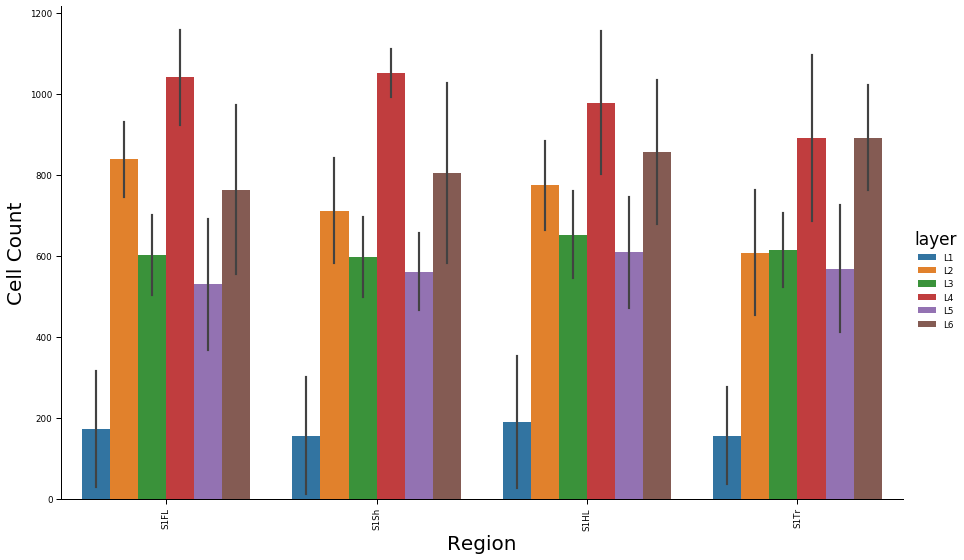

In [15]:
report_cell_count =\
    analysis_cell_count(circuit_model, adapter)

In [16]:
reporter.post(report_cell_count)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x7ffed3c0a668>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-09 13:00:50>                                                      
Post report cell_count_by_region_layer at
	 /gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/cell_count_by_region_la

'/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/cell_count_by_region_layer/20200309/131030'

### Mtype Cell Counts

We can also count cells in each region, layer by mtype.

In [33]:
phenomenon["mtype_cell_count"] =\
    Phenomenon("Mtype Cell Count", 
               description="Number of cells in the circuit.",
               group="Composition")
    
def measurement_mtype_cell_count_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the number of cells in a spatial location specified by the query.
    """
    box =\
        random_box(adapter, circuit_model, size_roi=size_roi, **query)
    if box is None:
        return pd.Series()
    cells = adapter.get_cells(circuit_model, roi=box)
    return cells.groupby("mtype").agg("size")

def measurement_mtype_cell_count_exhaustive(
        adapter, circuit_model,
        sampling_methodology=None,
        logscale=True,
        **query):
    """
    ...
    """
    cells =\
        adapter.get_cells(circuit_model, **query)
    return\
        cells.groupby("mtype").agg("size").apply(lambda s: np.log10(s + 1))

analysis_mtype_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["mtype_cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(
            get_regions_and_layers,
            labels=["region", "layer"]),
        sample_measurement=measurement_mtype_cell_count_exhaustive,
        sample_size=1,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        measurement_collection=measurement.collection.series_type,
        plotter=MultiPlot(
            mvar="mtype",
            plotter=Bars(xvar="region",
                         xlabel="Region",
                         yvar="mtype_cell_count",
                         ylabel="Log Cell Count",
                         gvar="layer")),
        report=CircuitAnalysisReport)
                                       

  0%|          | 0/24 [00:00<?, ?it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L1'}



  4%|▍         | 1/24 [00:01<00:28,  1.25s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L2'}



  8%|▊         | 2/24 [00:03<00:30,  1.41s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L3'}



 12%|█▎        | 3/24 [00:04<00:33,  1.57s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L4'}



 17%|█▋        | 4/24 [00:07<00:34,  1.71s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L5'}



 21%|██        | 5/24 [00:08<00:33,  1.77s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L6'}



 25%|██▌       | 6/24 [00:11<00:36,  2.04s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L1'}



 29%|██▉       | 7/24 [00:12<00:30,  1.79s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L2'}



 33%|███▎      | 8/24 [00:14<00:26,  1.63s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L3'}



 38%|███▊      | 9/24 [00:15<00:22,  1.51s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L4'}



 42%|████▏     | 10/24 [00:16<00:21,  1.53s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L5'}



 46%|████▌     | 11/24 [00:20<00:26,  2.07s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L6'}



 50%|█████     | 12/24 [00:22<00:25,  2.13s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L1'}



 54%|█████▍    | 13/24 [00:24<00:23,  2.16s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L2'}



 58%|█████▊    | 14/24 [00:27<00:22,  2.22s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L3'}



 62%|██████▎   | 15/24 [00:29<00:19,  2.17s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L4'}



 67%|██████▋   | 16/24 [00:30<00:16,  2.02s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L5'}



 71%|███████   | 17/24 [00:32<00:13,  1.97s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L6'}



 75%|███████▌  | 18/24 [00:35<00:13,  2.24s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L1'}



 79%|███████▉  | 19/24 [00:37<00:10,  2.19s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L2'}



 83%|████████▎ | 20/24 [00:39<00:09,  2.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L3'}



 88%|████████▊ | 21/24 [00:42<00:06,  2.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L4'}



 92%|█████████▏| 22/24 [00:44<00:04,  2.38s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L5'}



 96%|█████████▌| 23/24 [00:47<00:02,  2.37s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L6'}



100%|██████████| 24/24 [00:49<00:00,  2.21s/it]
/gpfs/bbp.cscs.ch/home/sood/.vmgr_repo/nix36/lib/python3.6/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


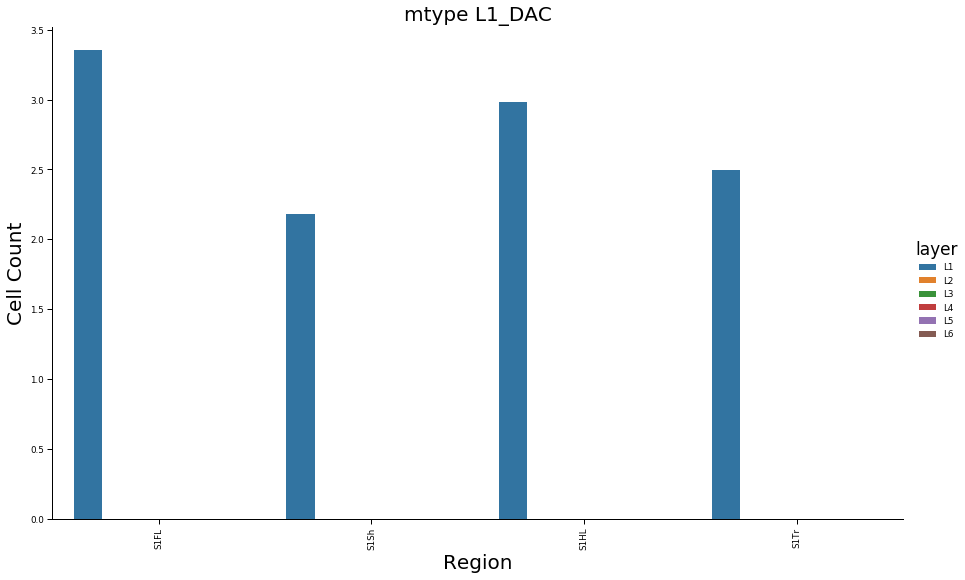

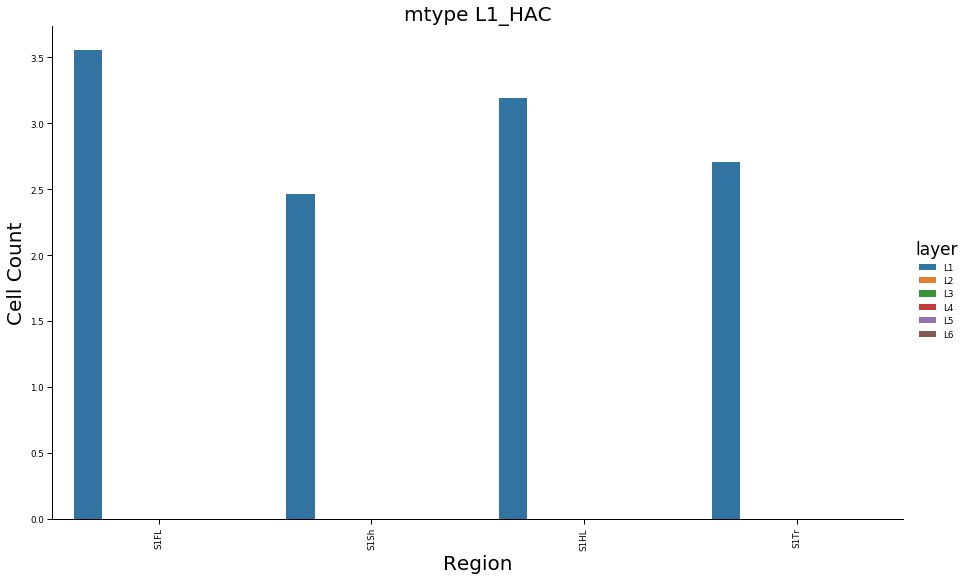

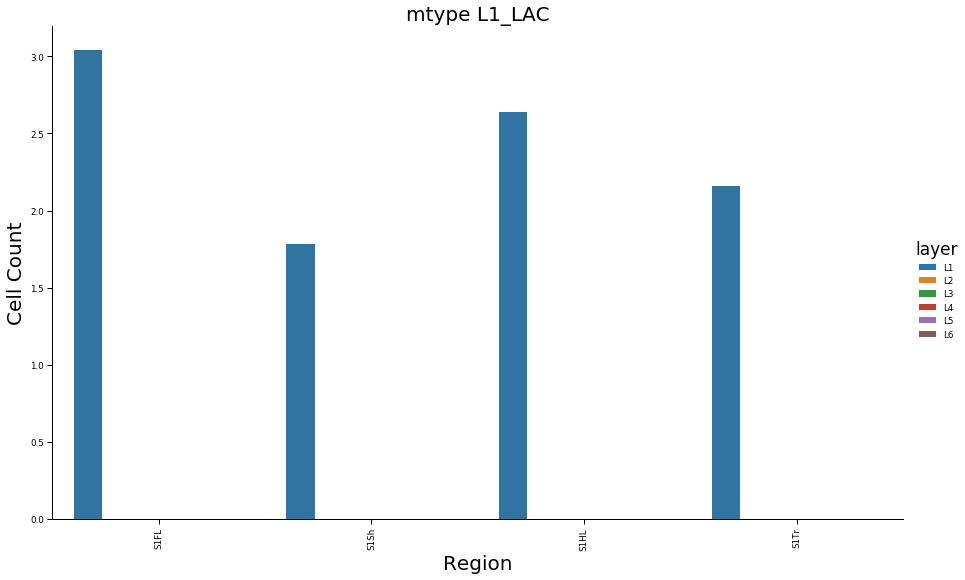

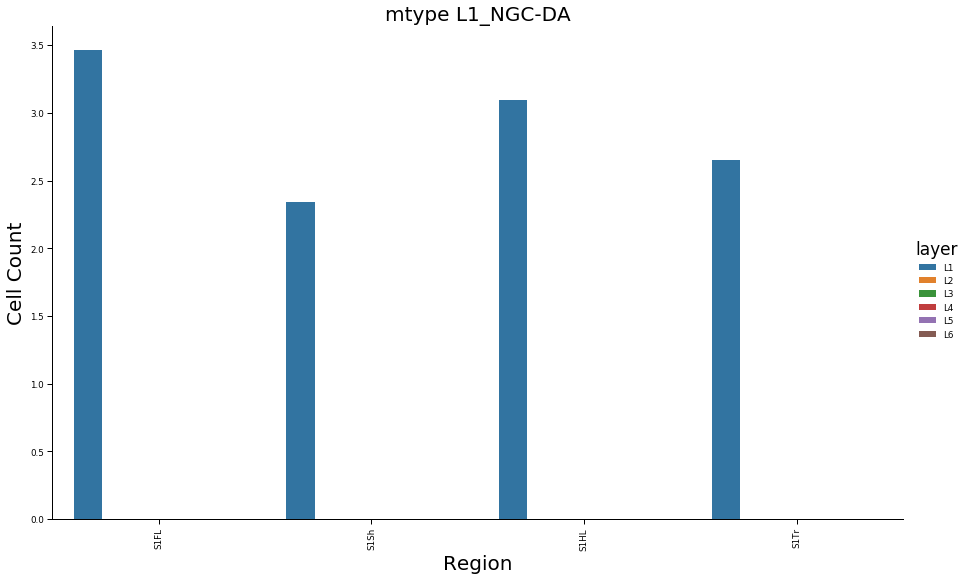

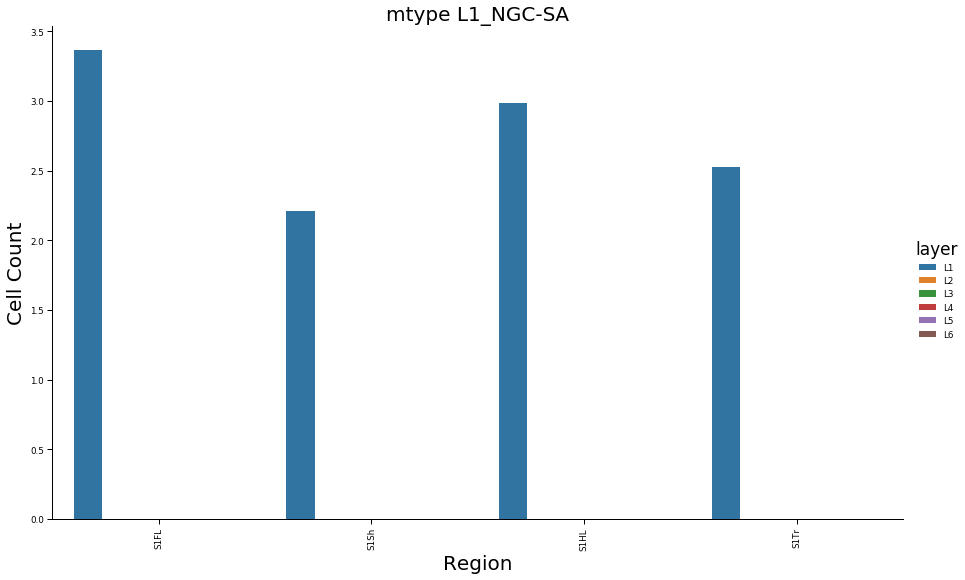

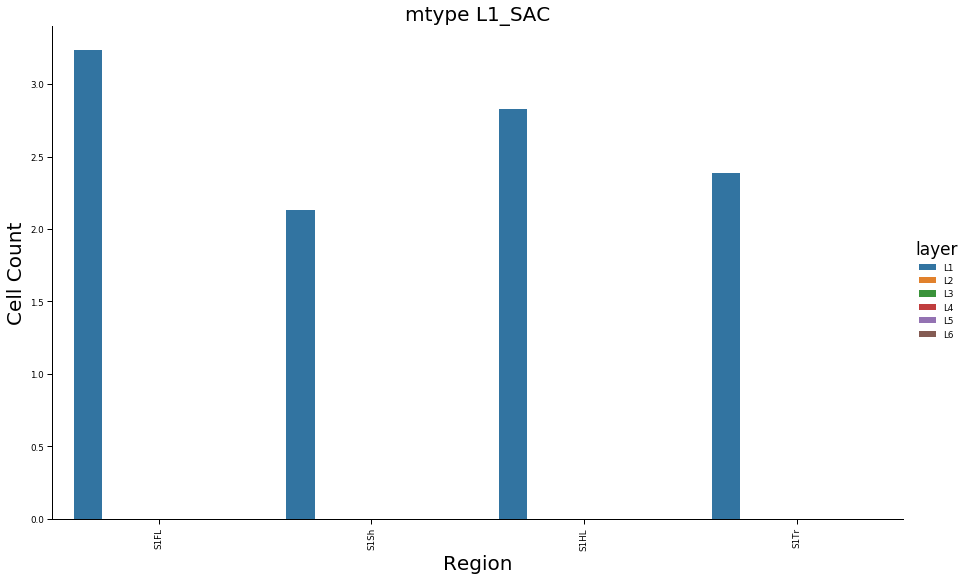

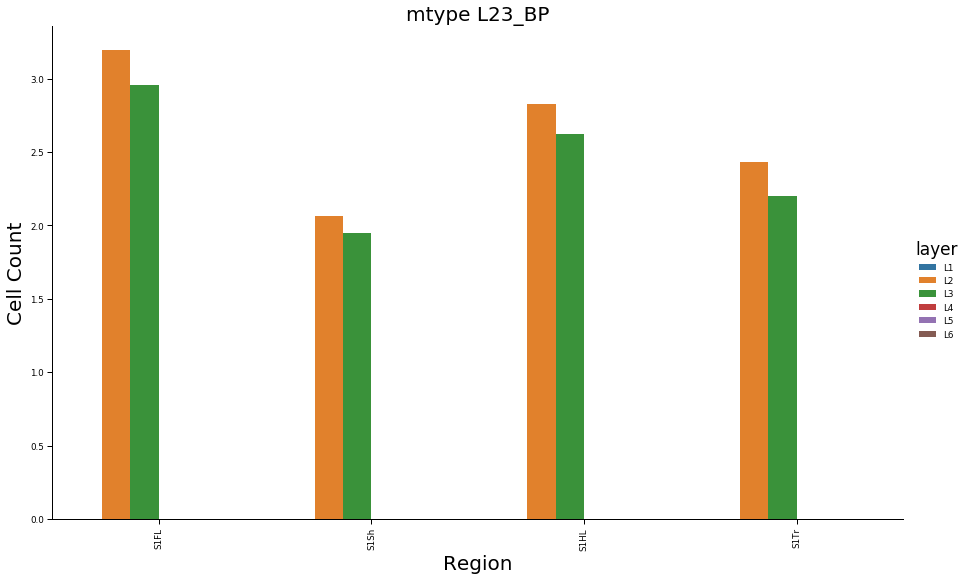

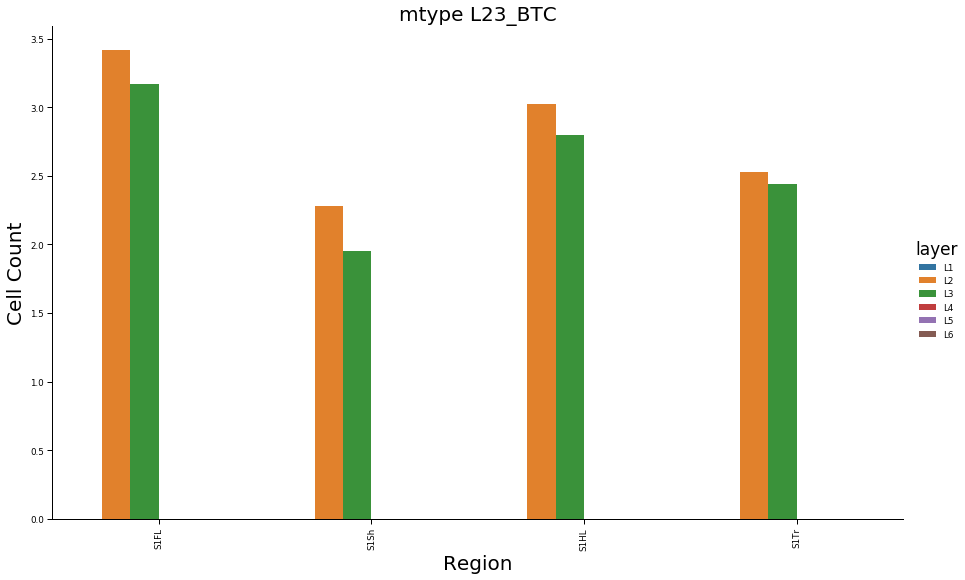

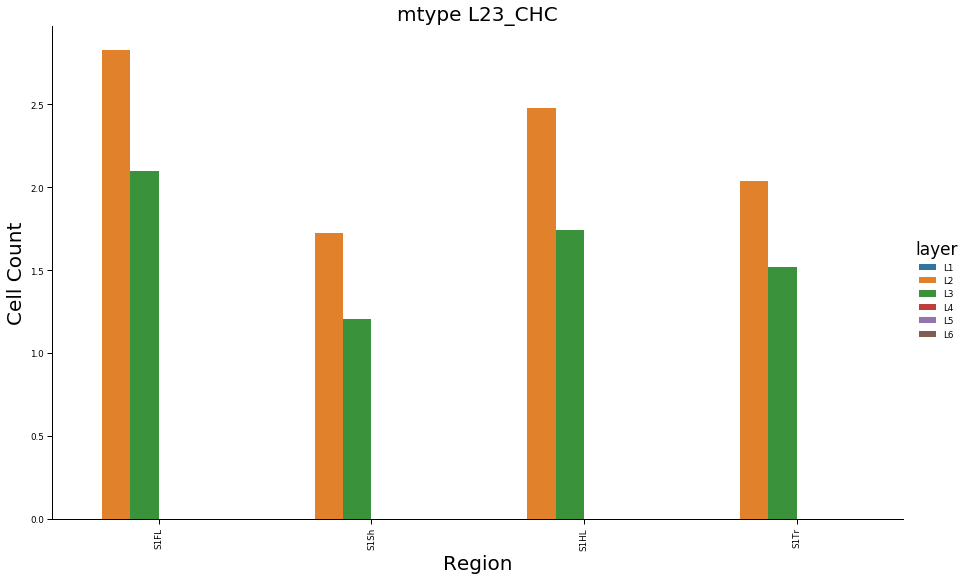

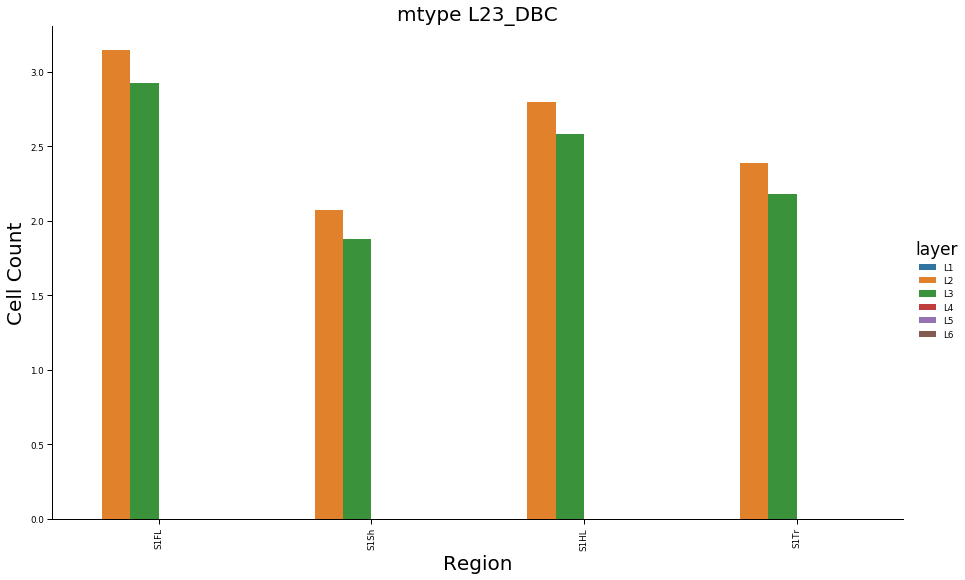

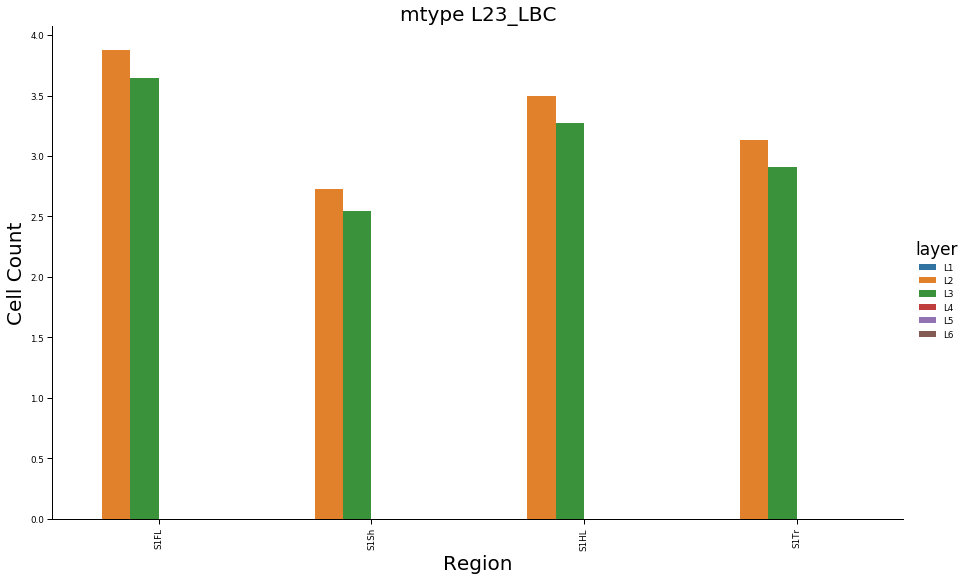

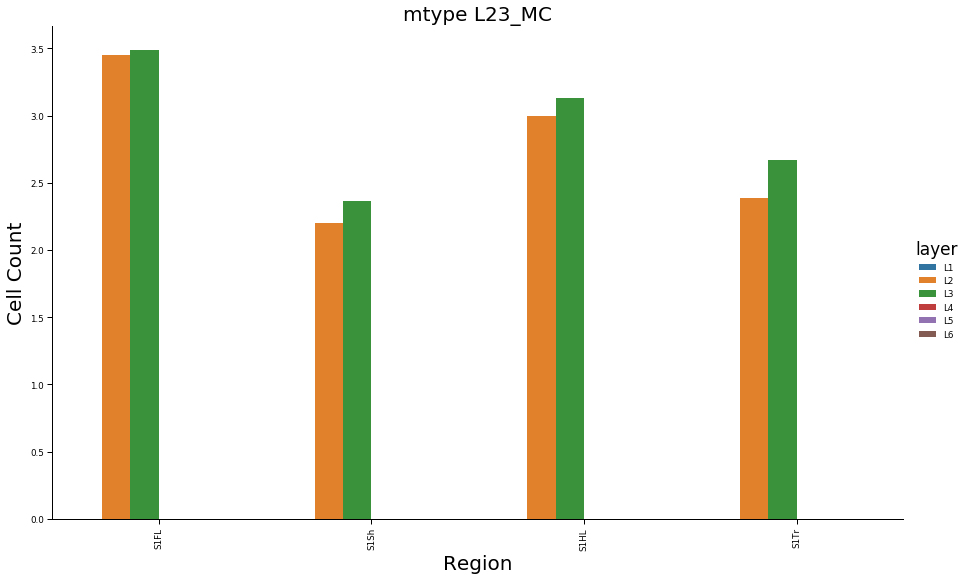

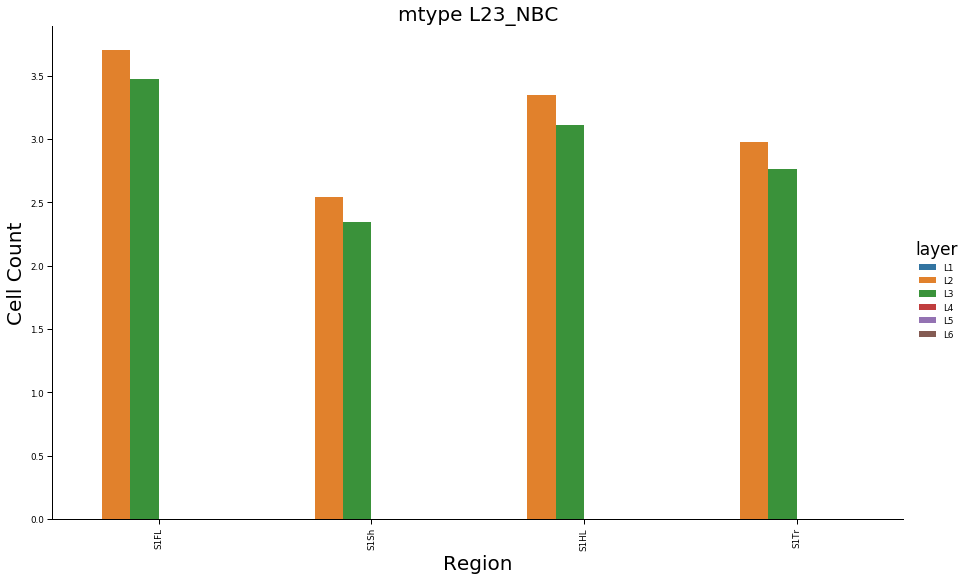

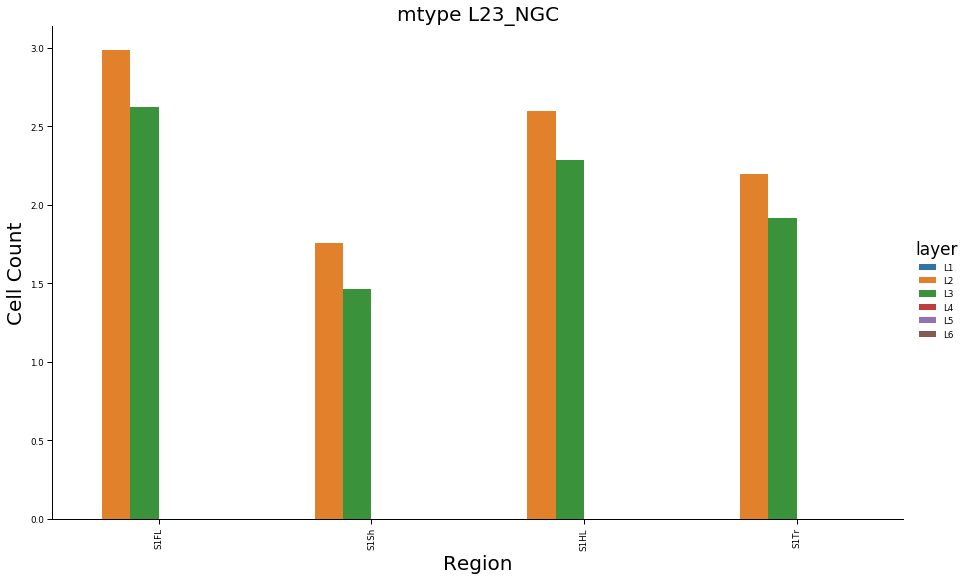

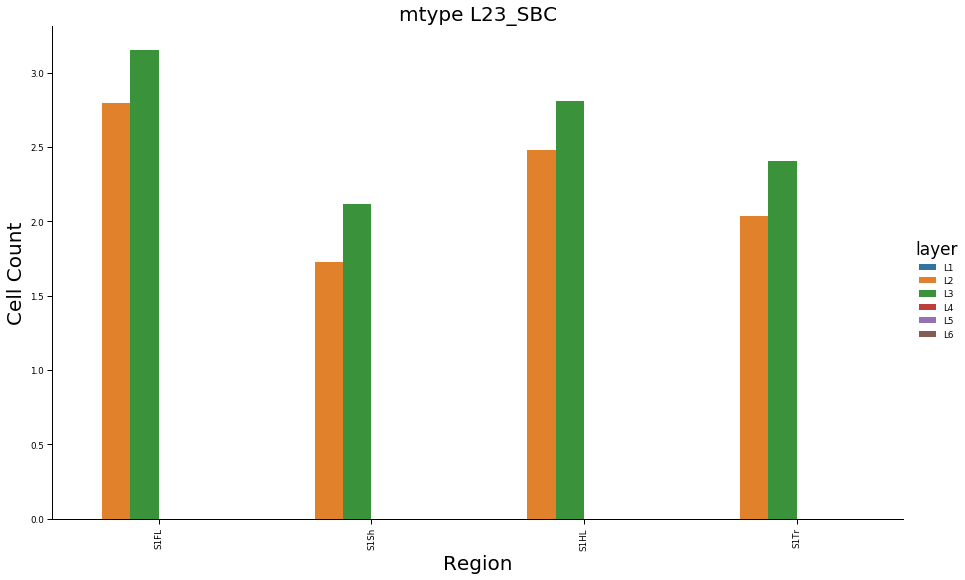

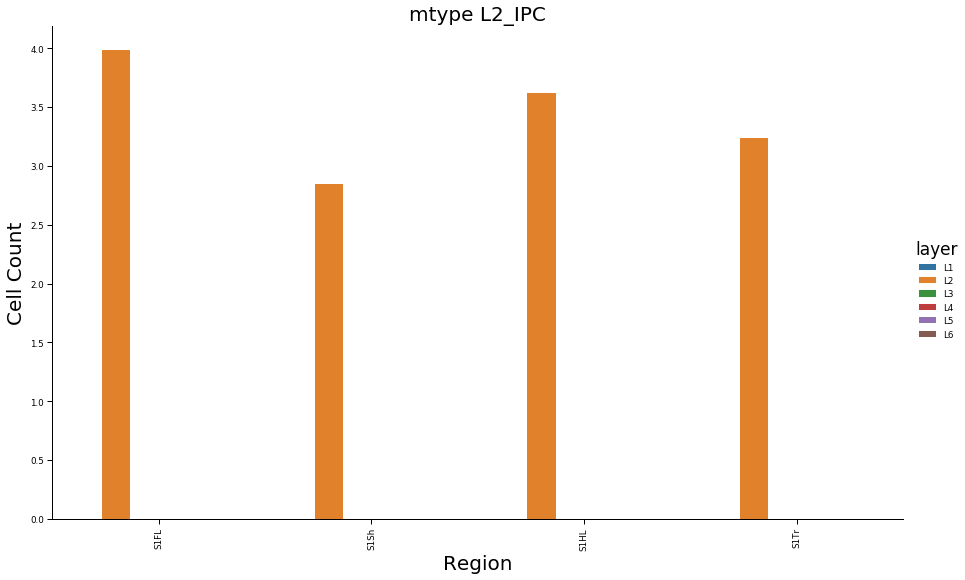

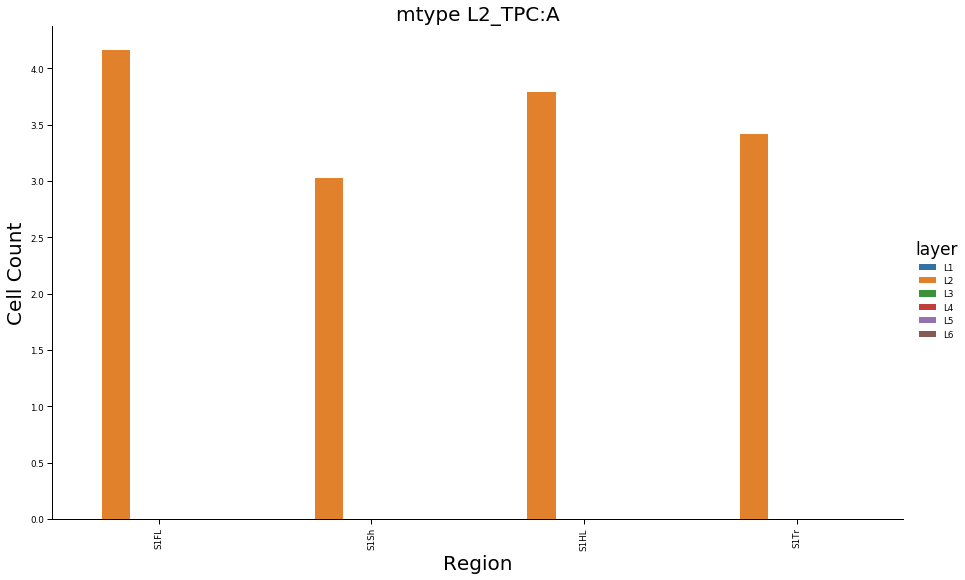

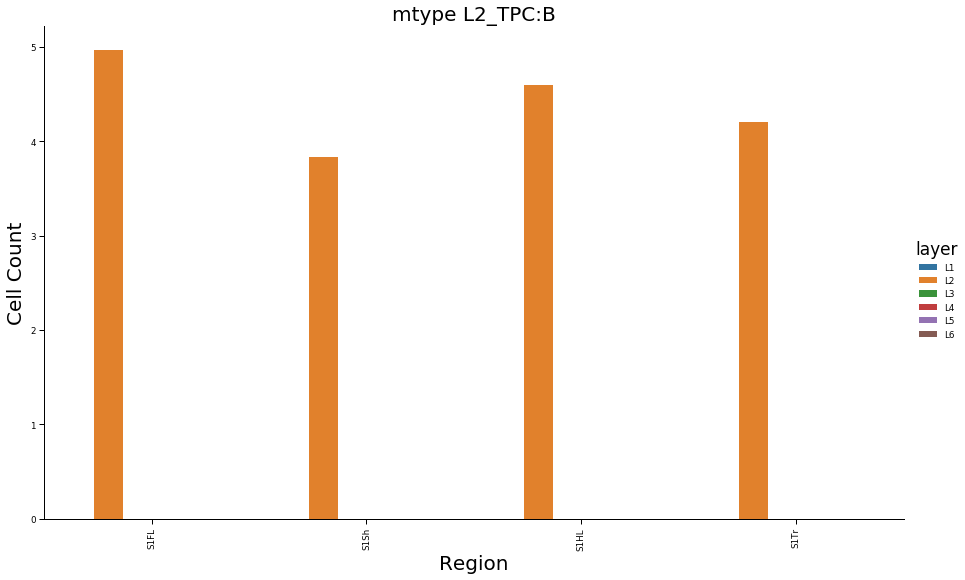

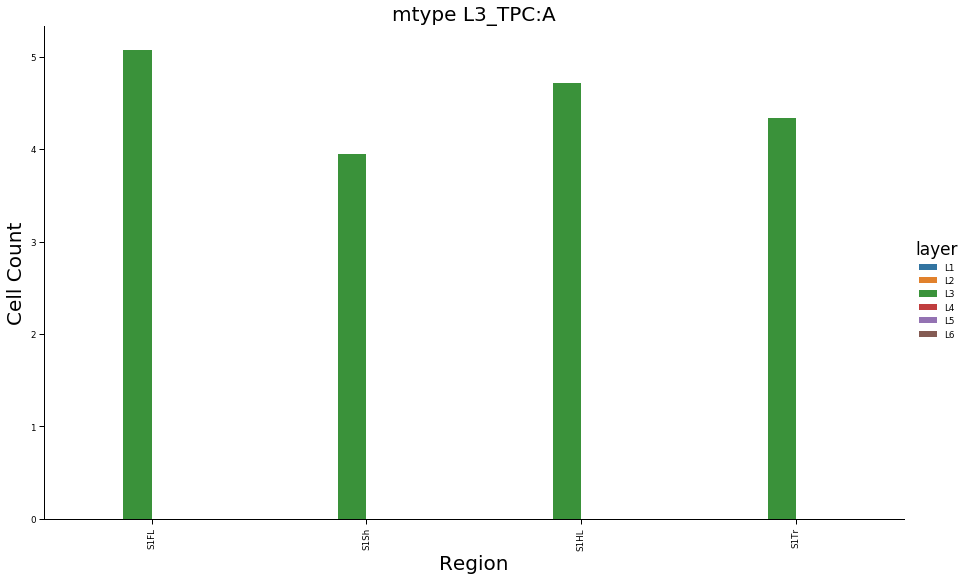

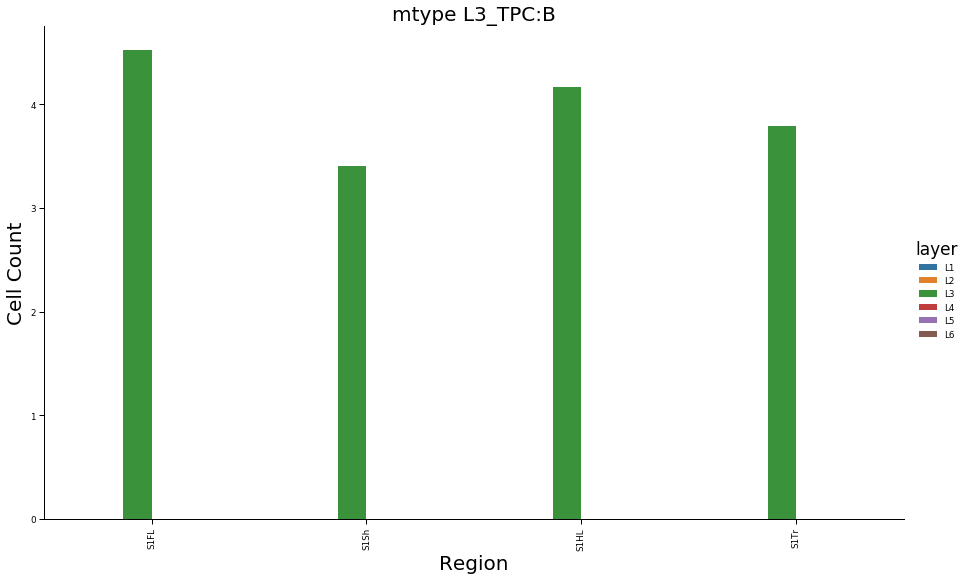

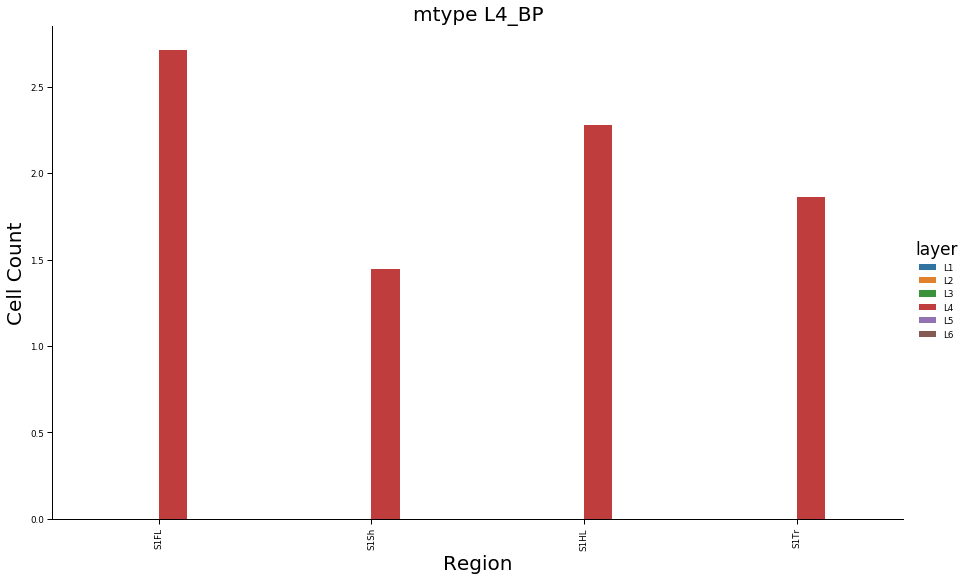

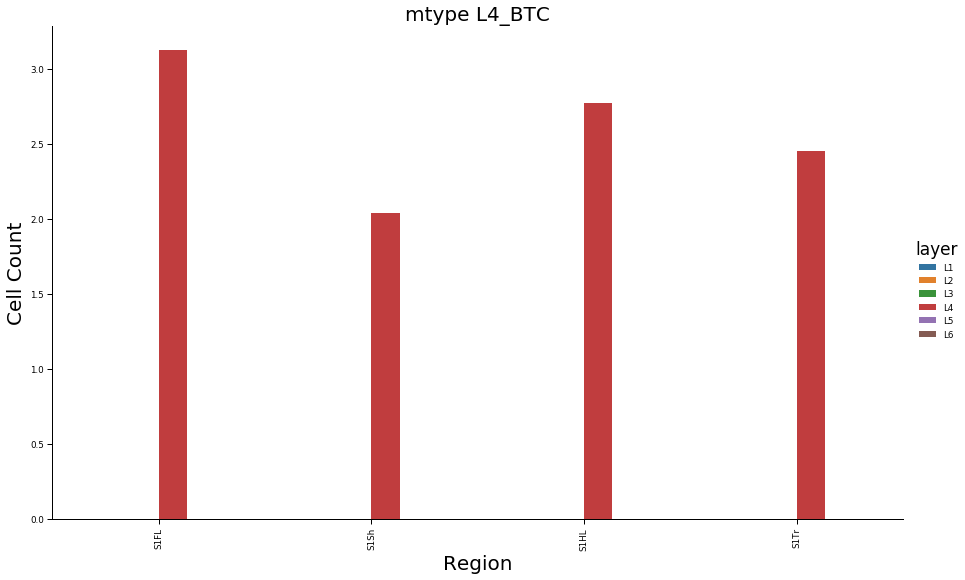

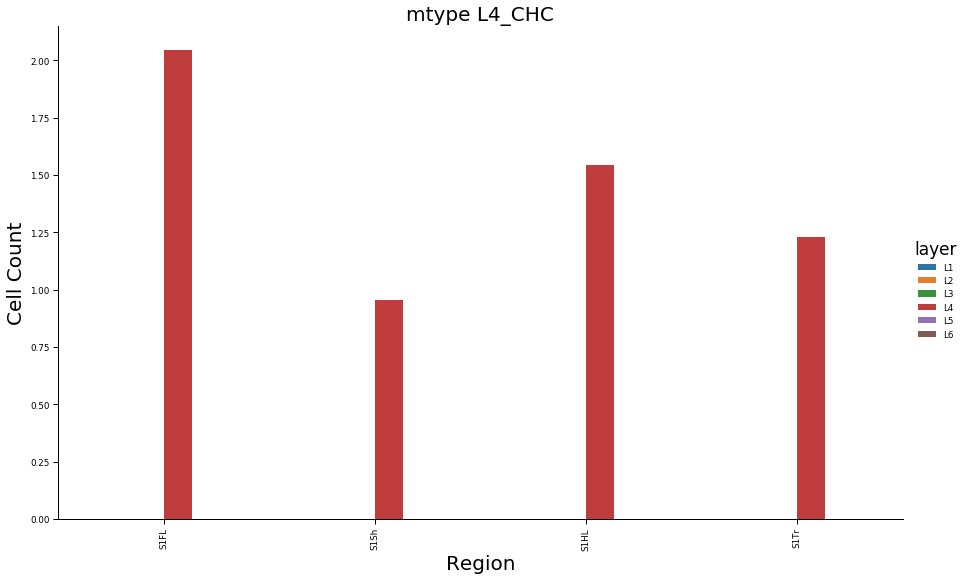

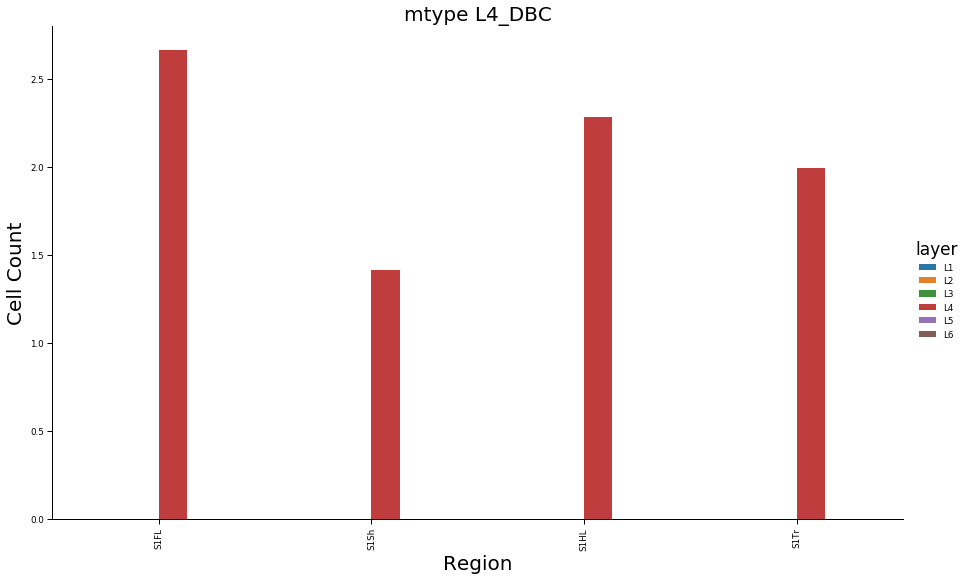

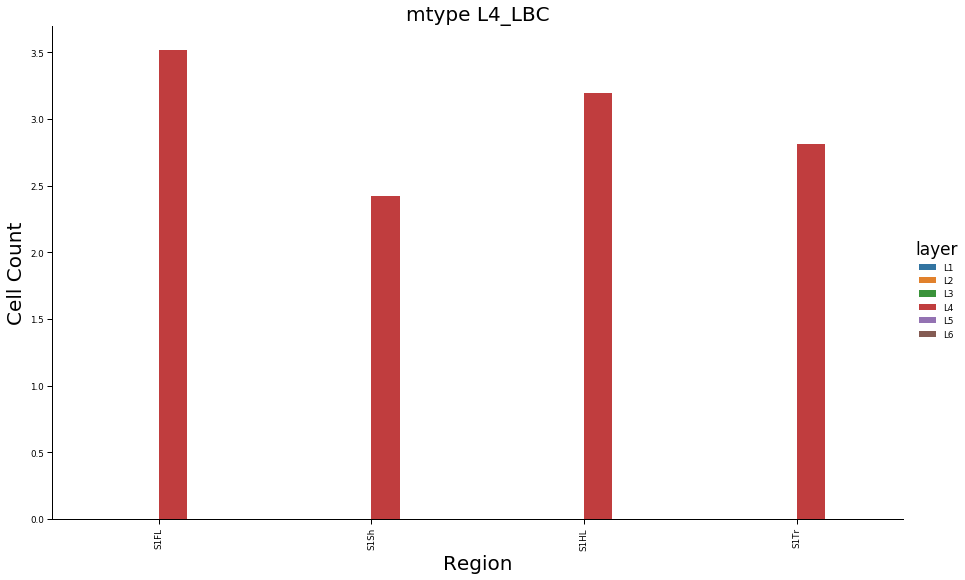

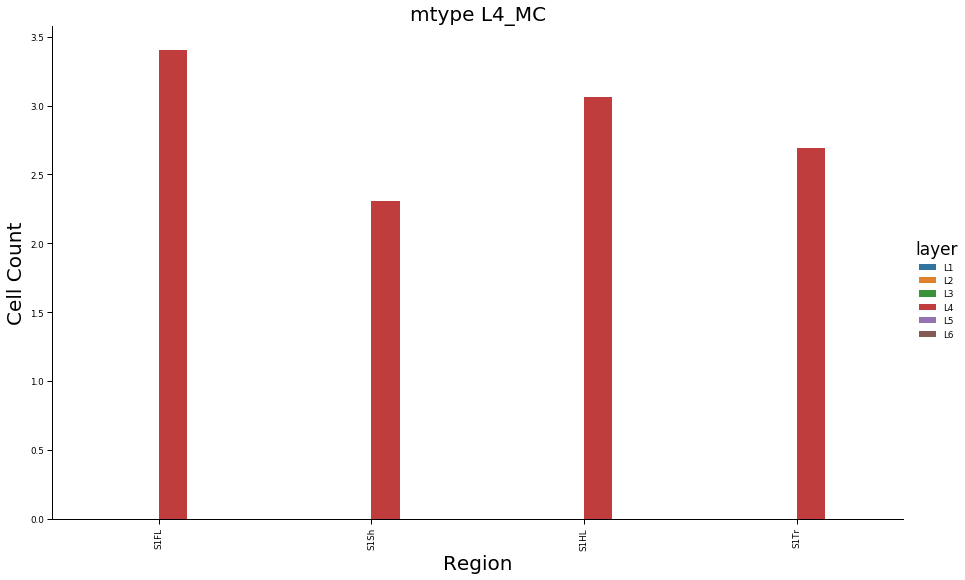

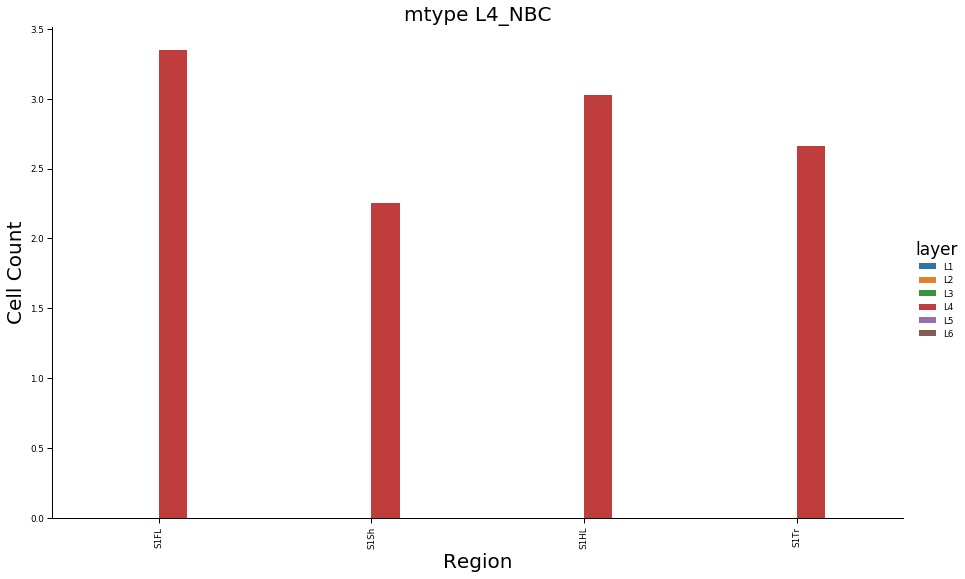

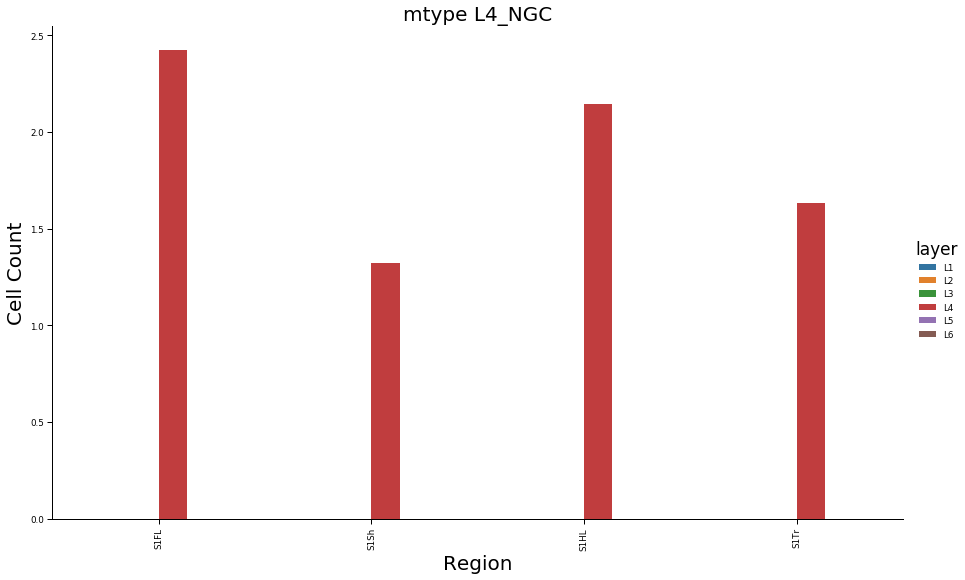

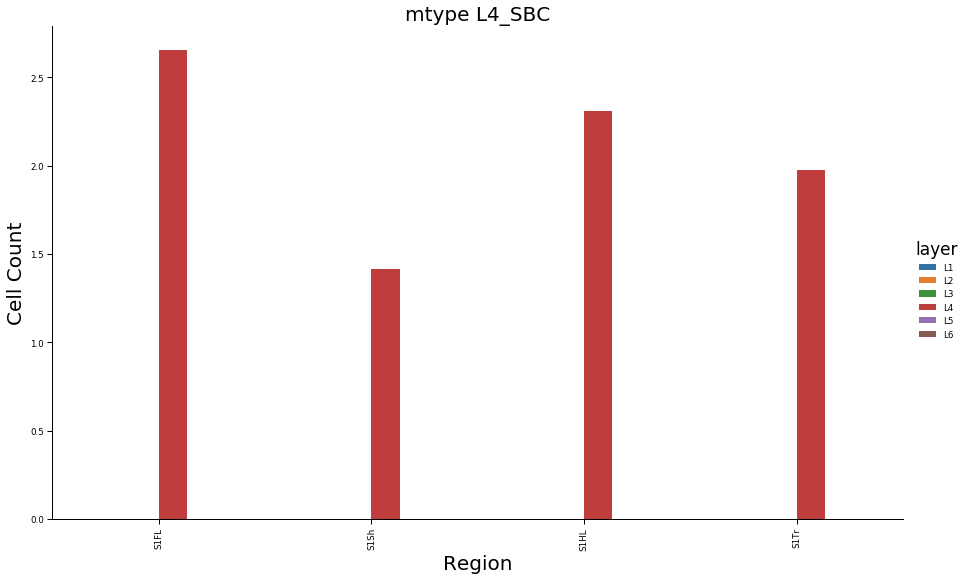

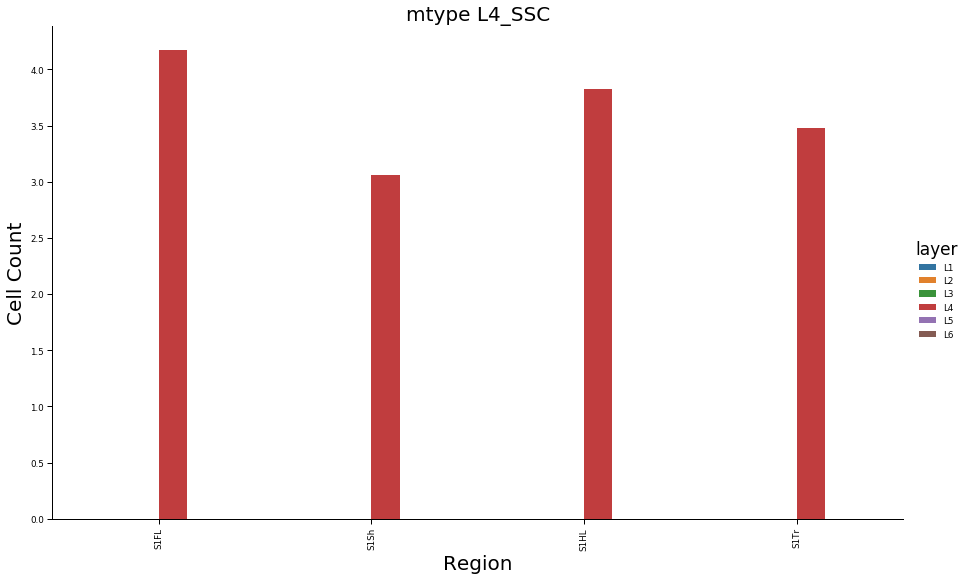

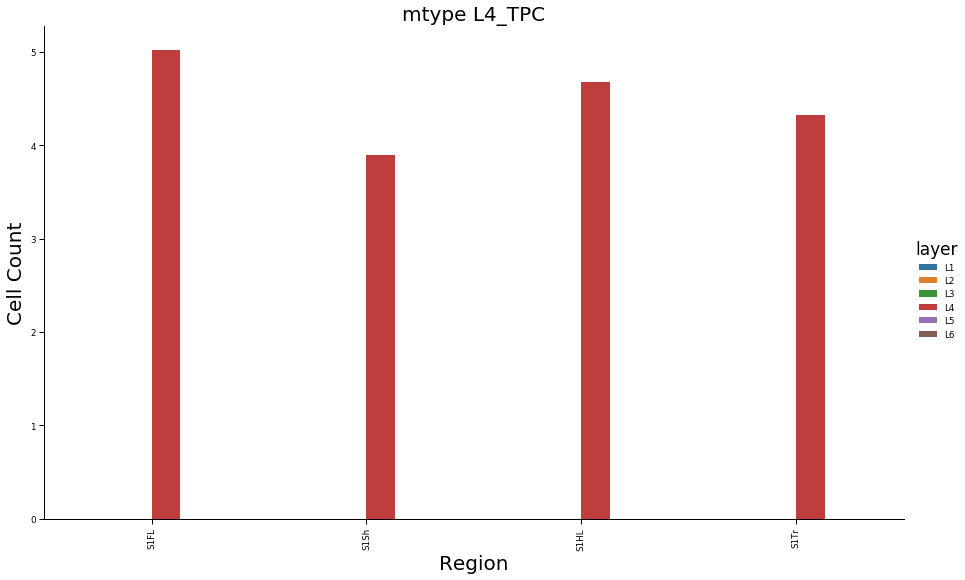

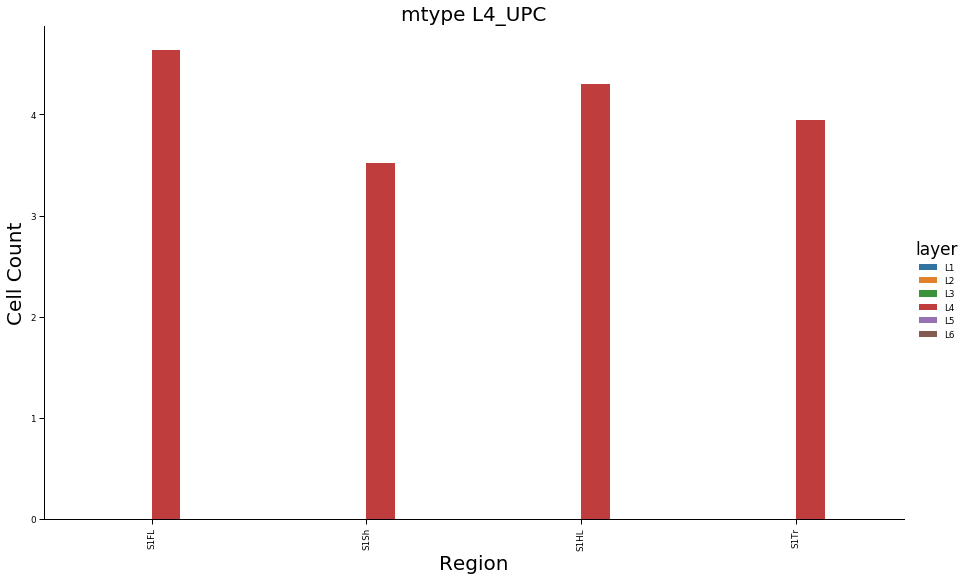

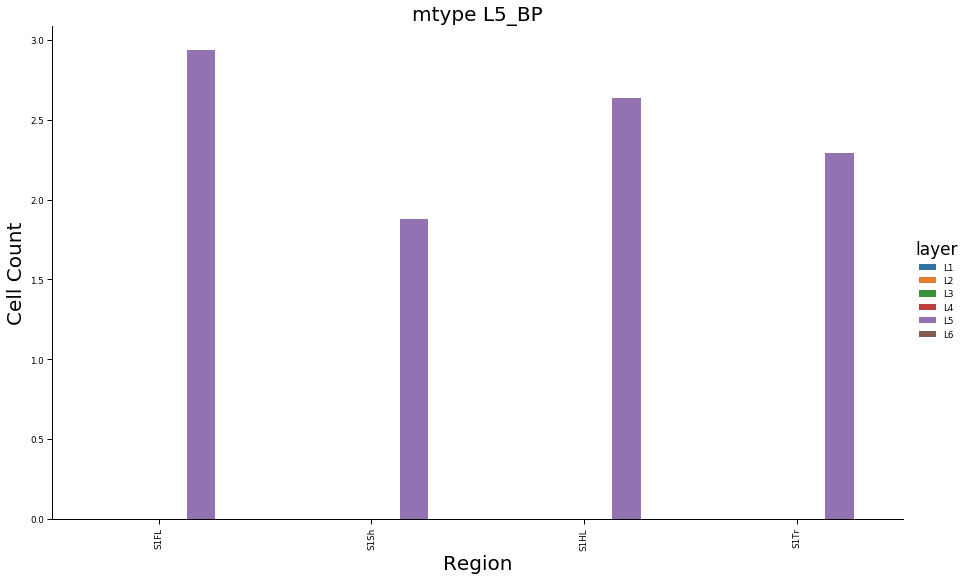

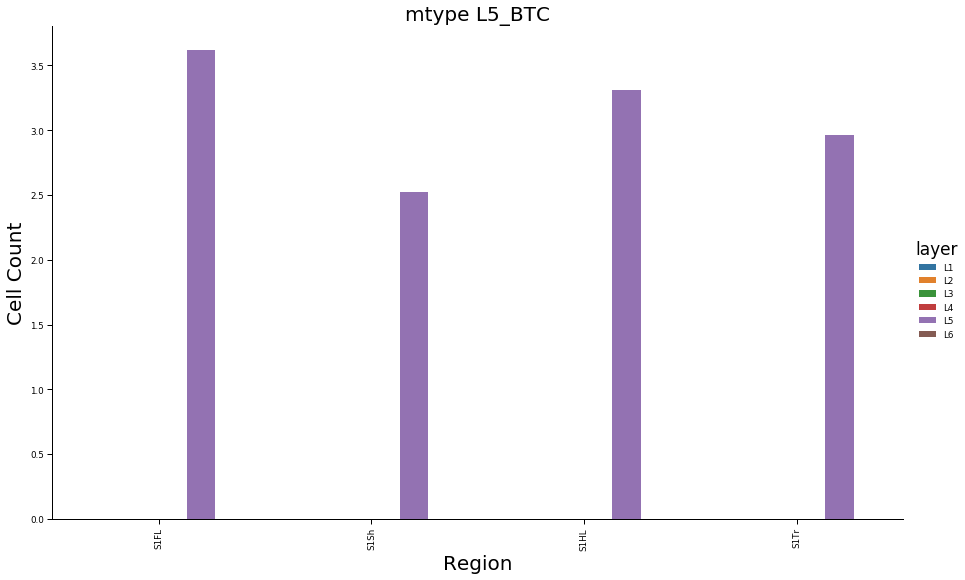

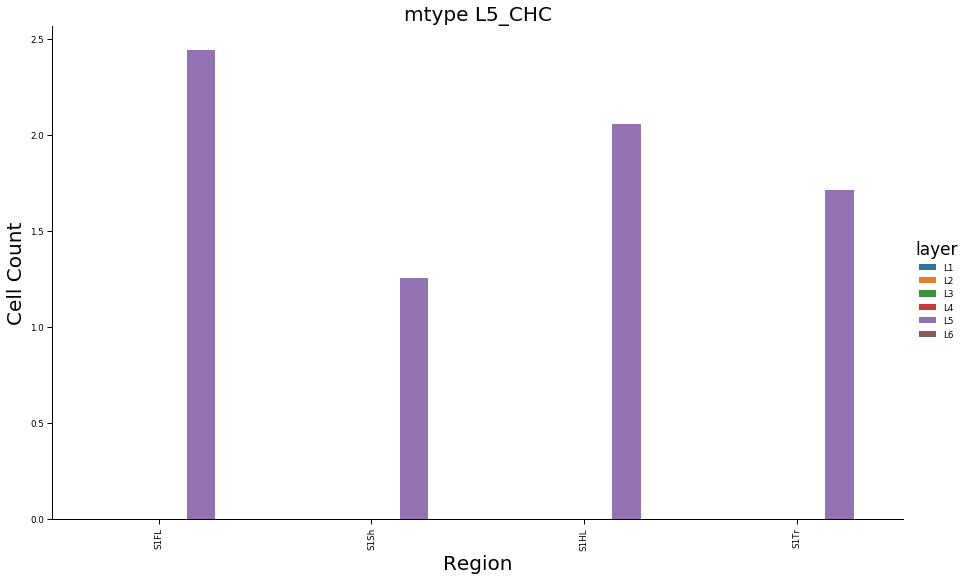

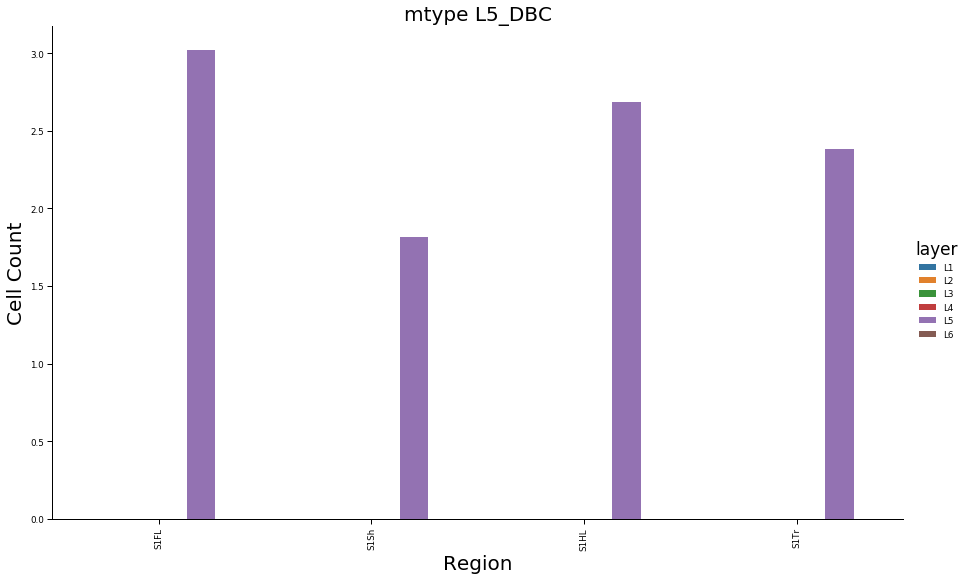

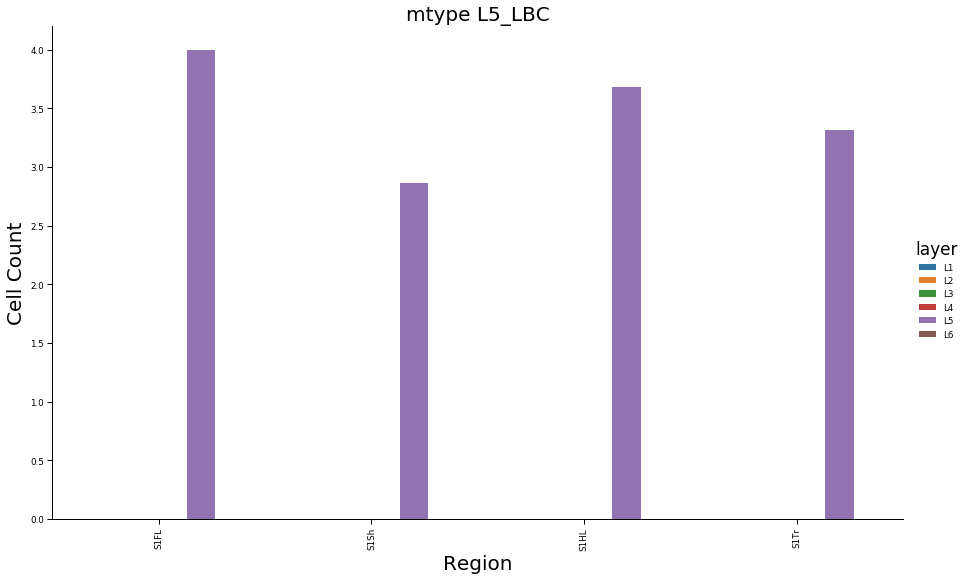

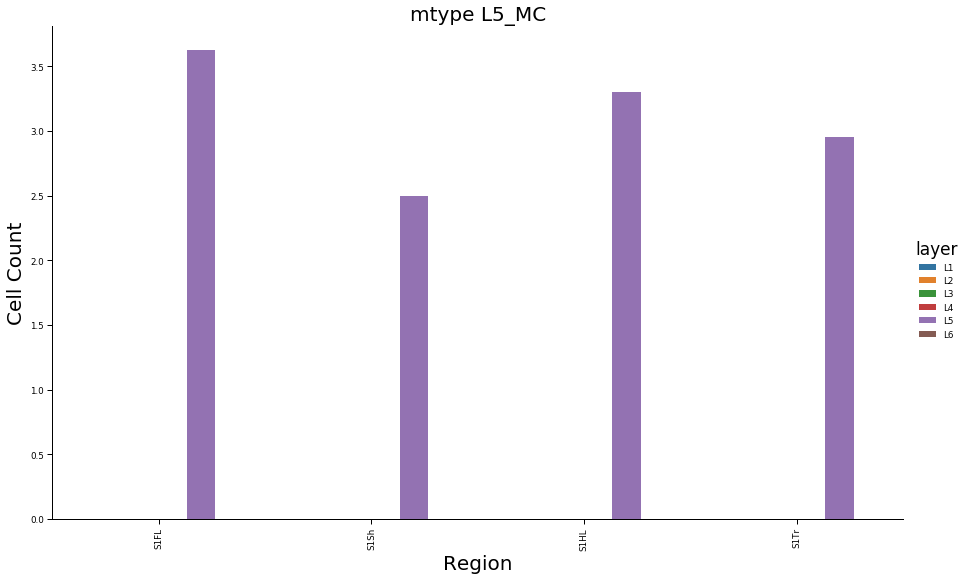

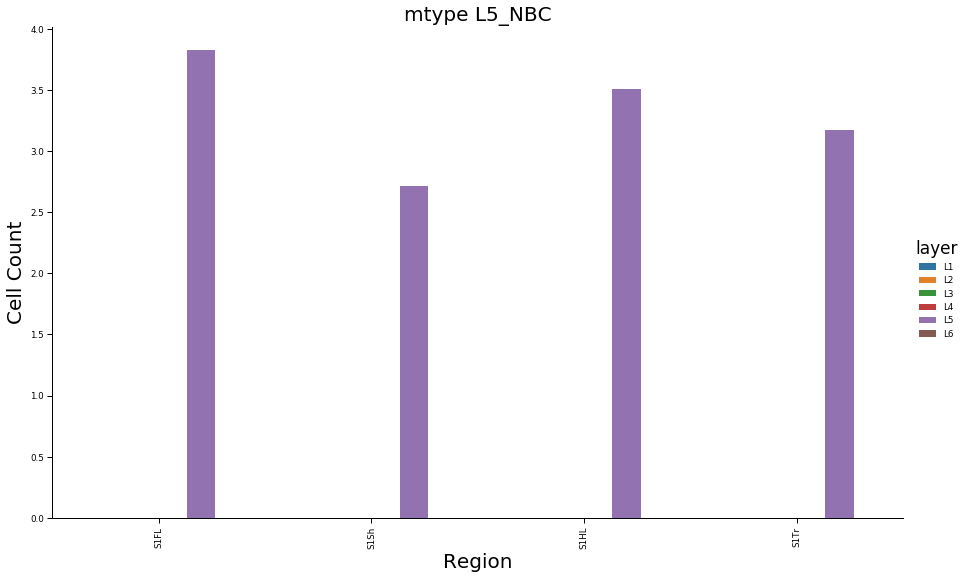

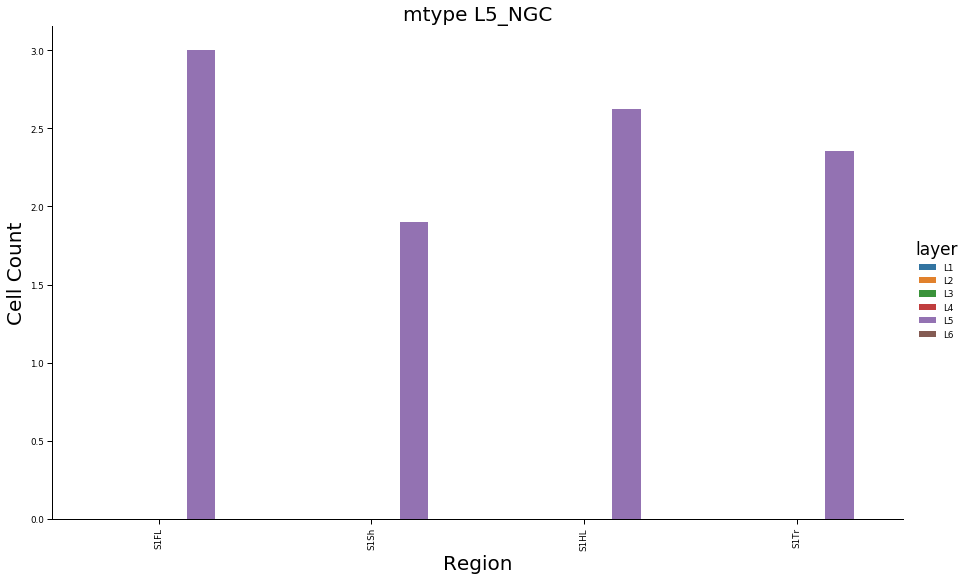

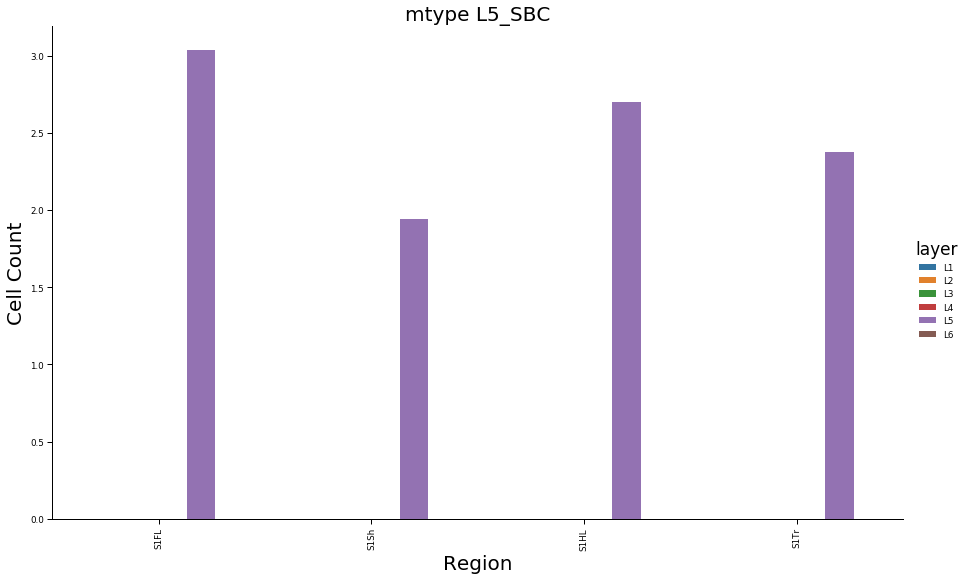

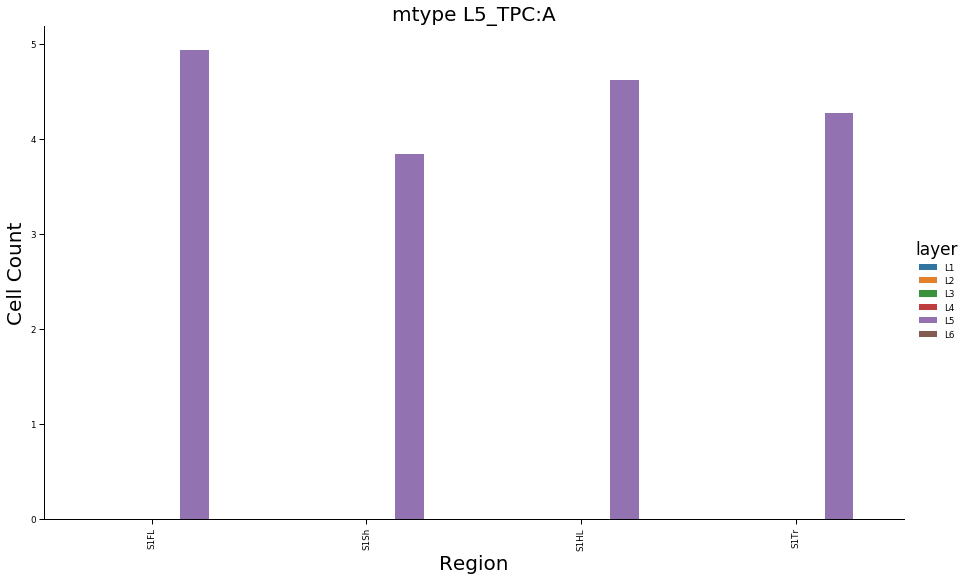

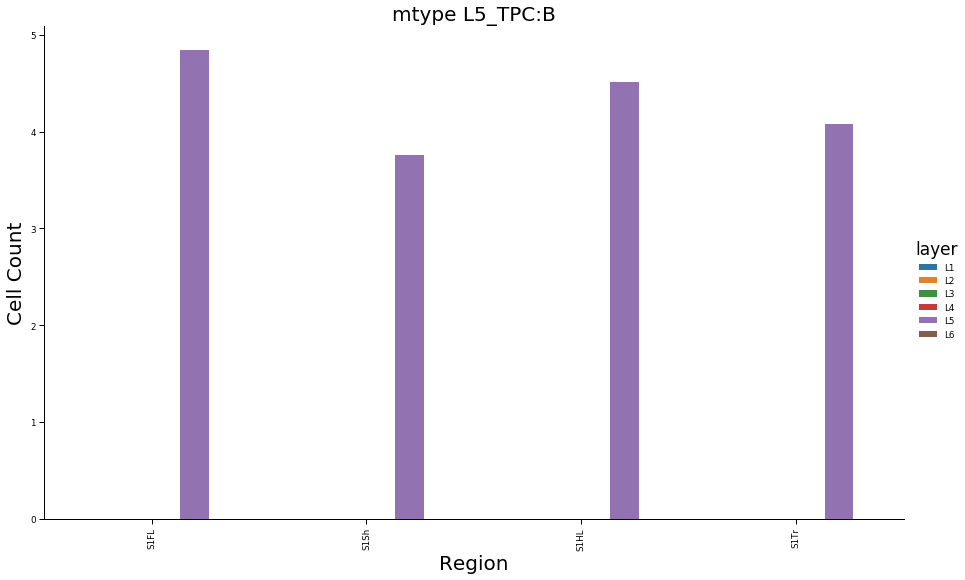

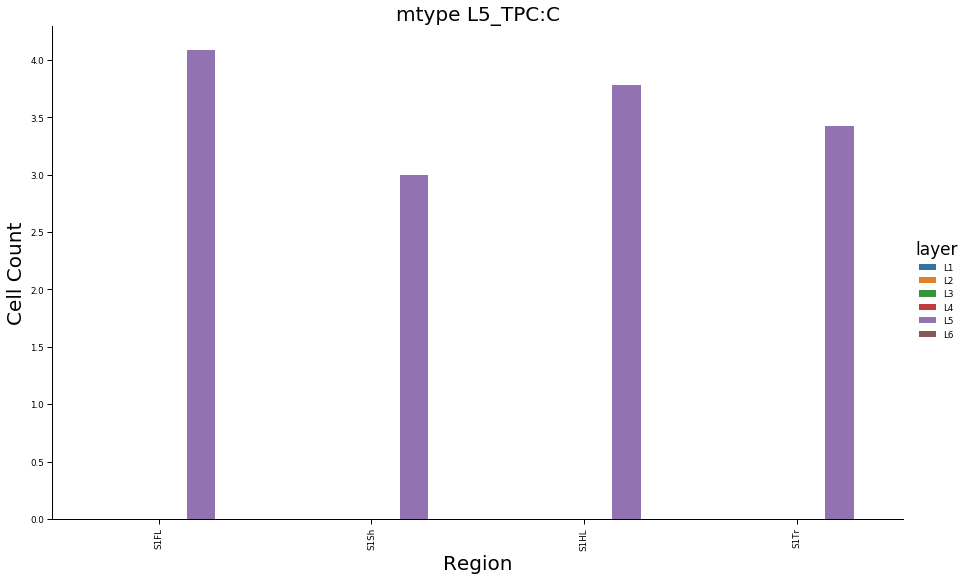

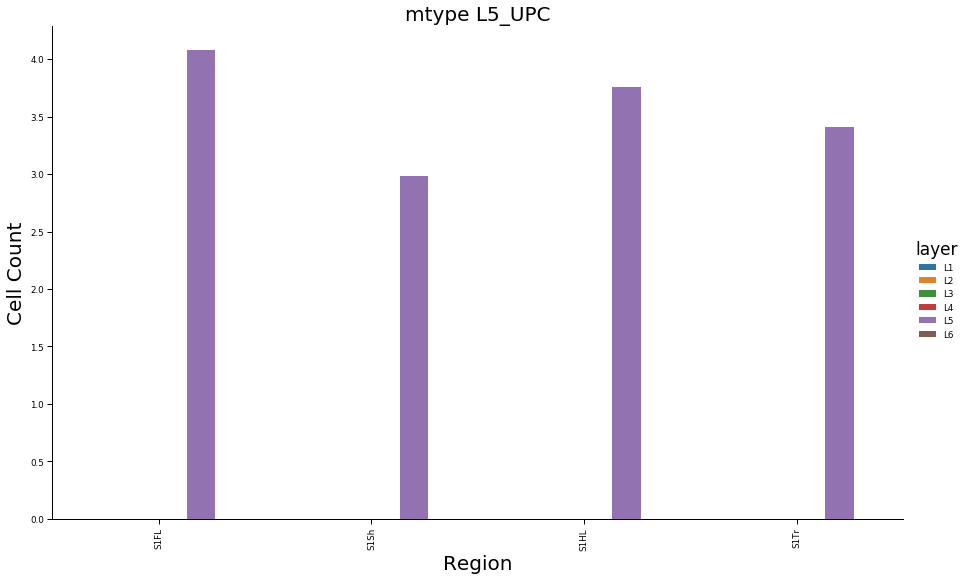

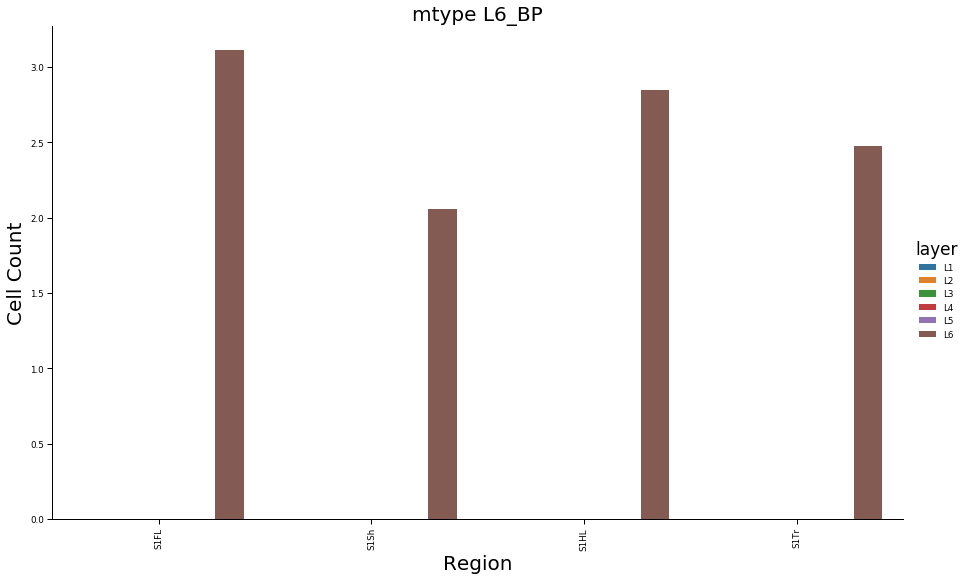

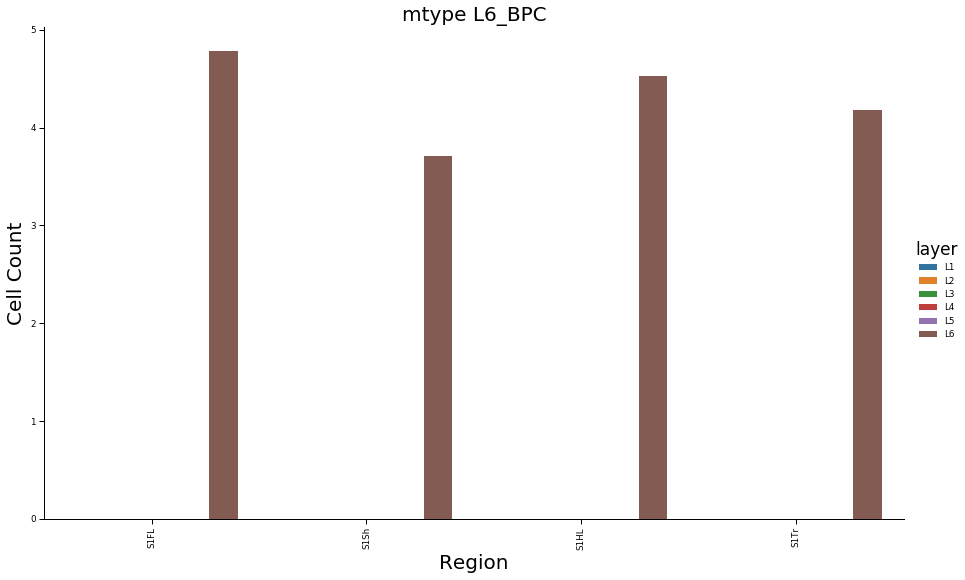

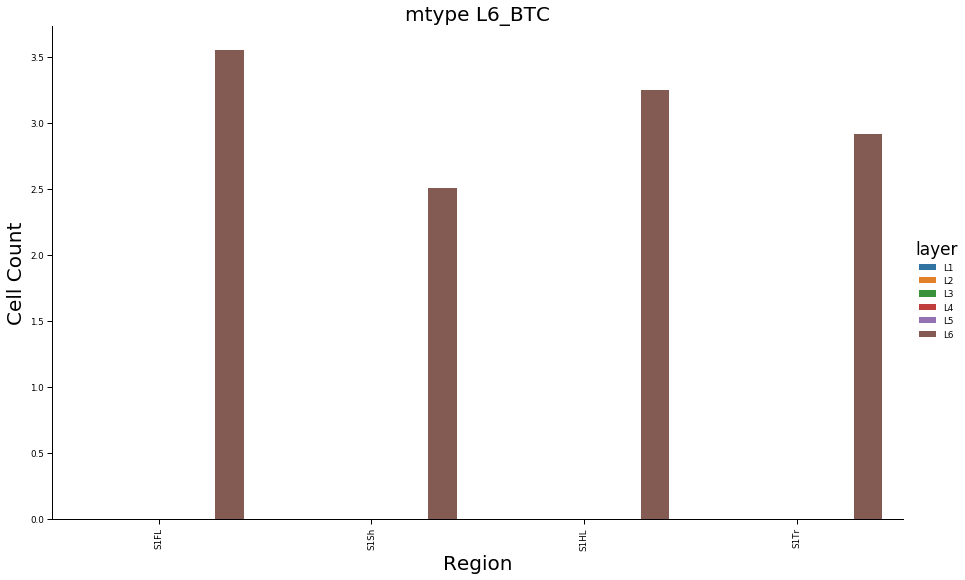

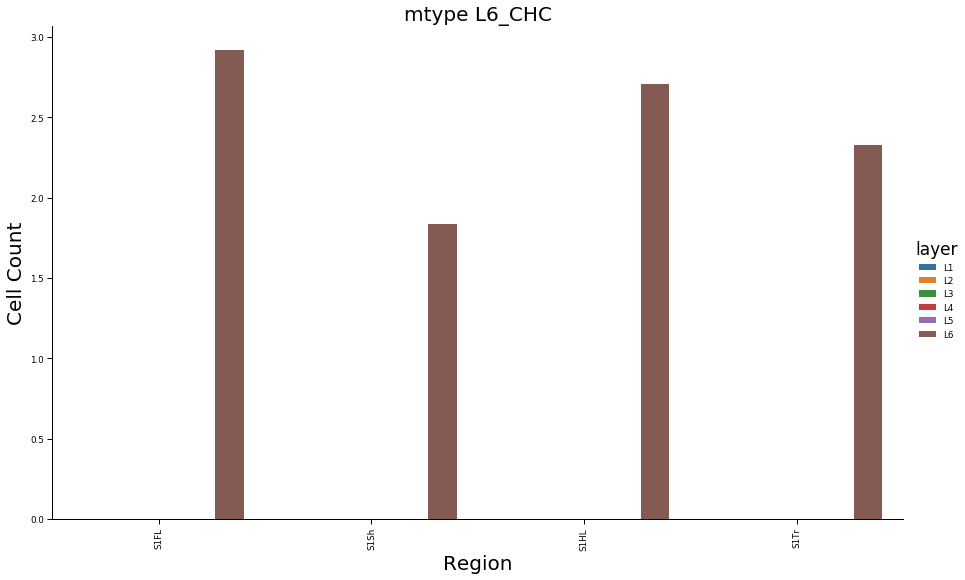

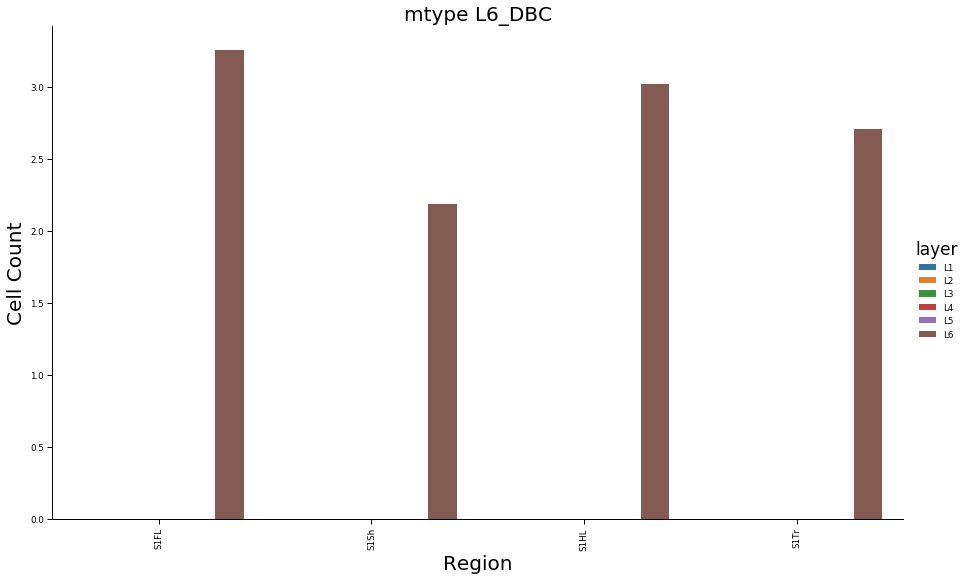

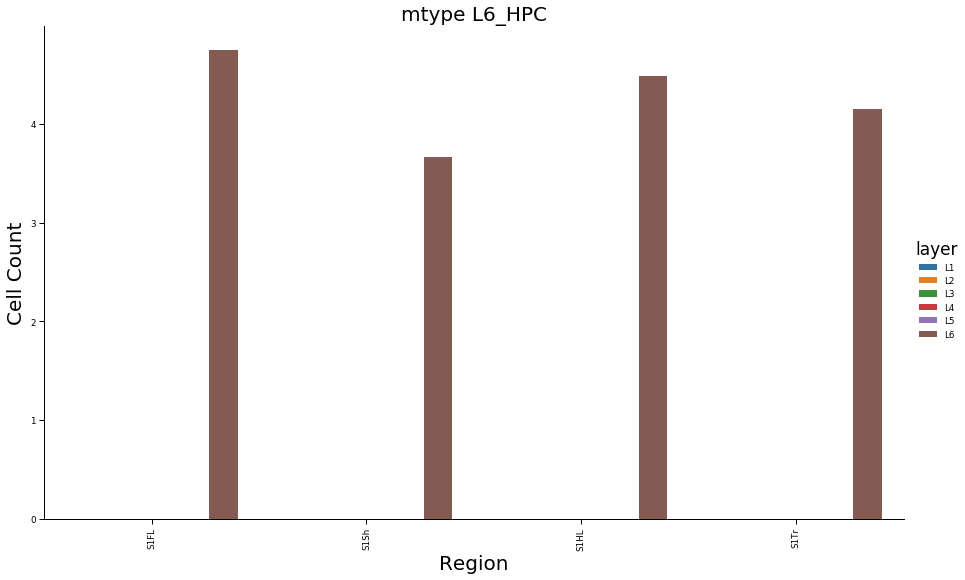

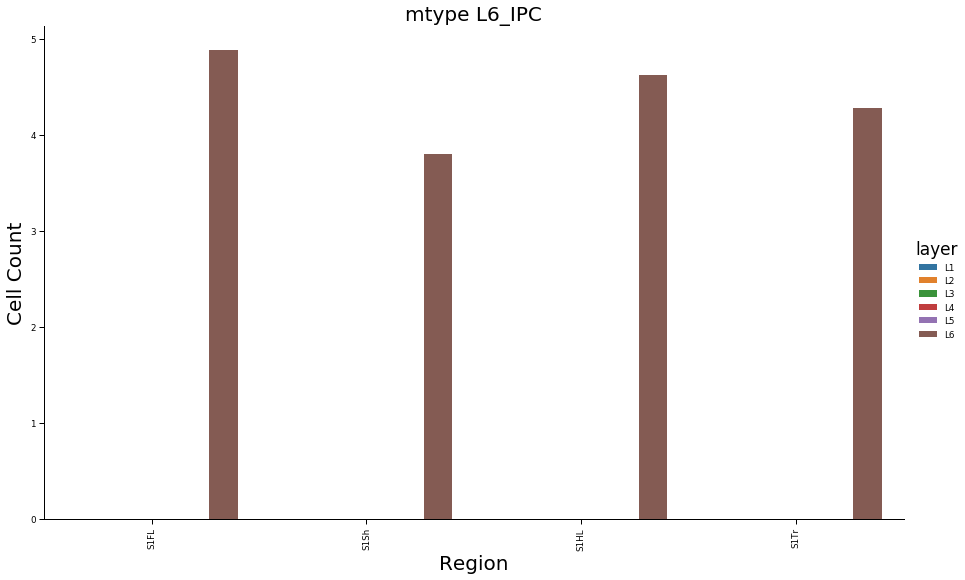

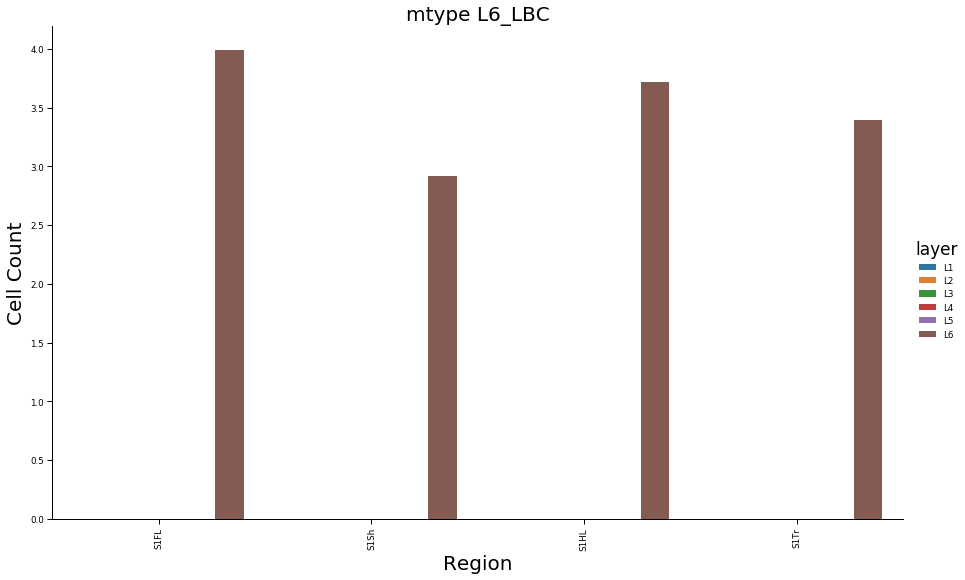

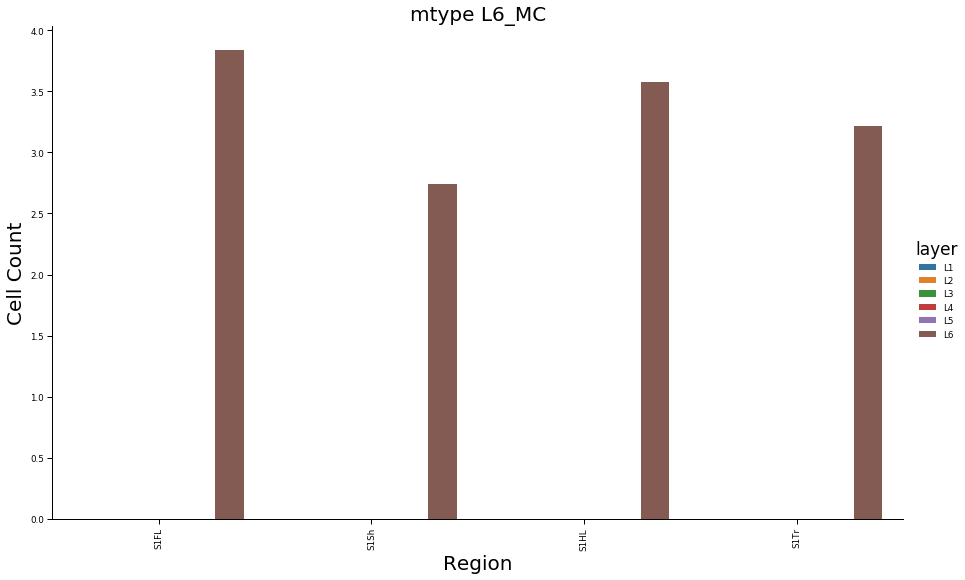

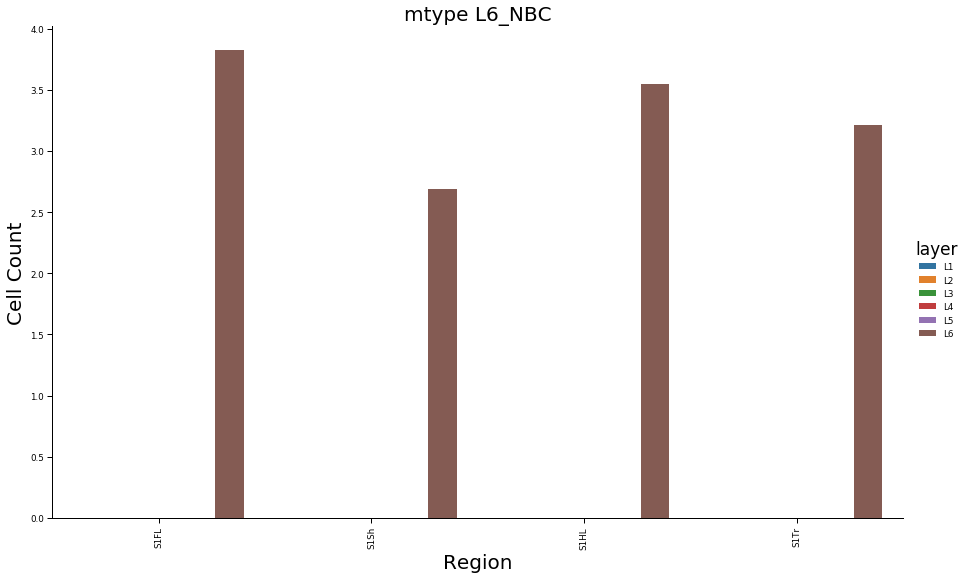

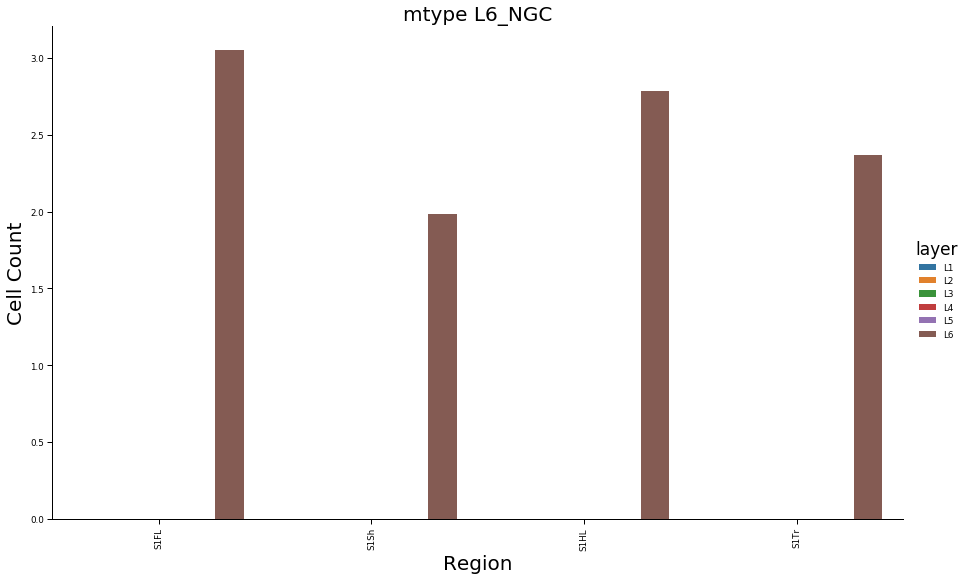

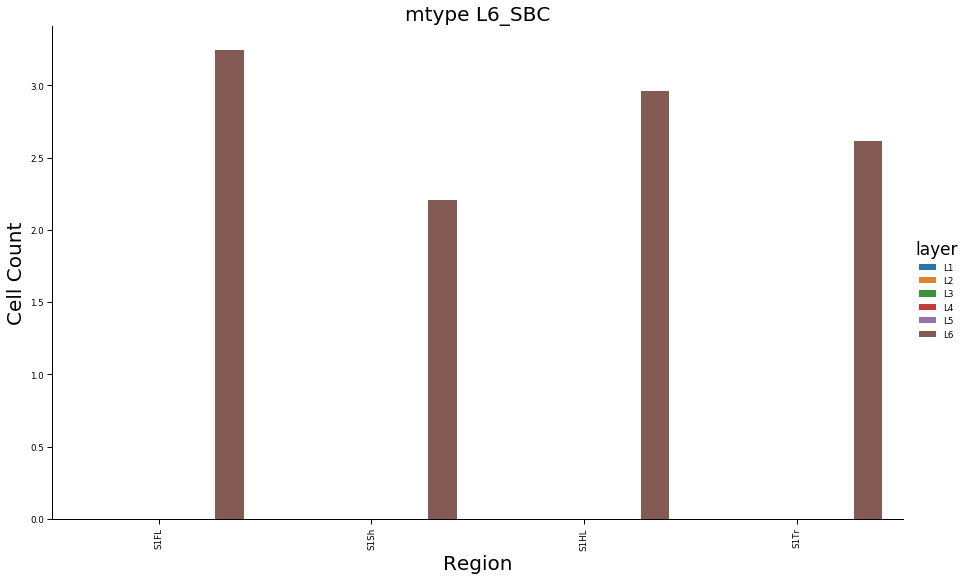

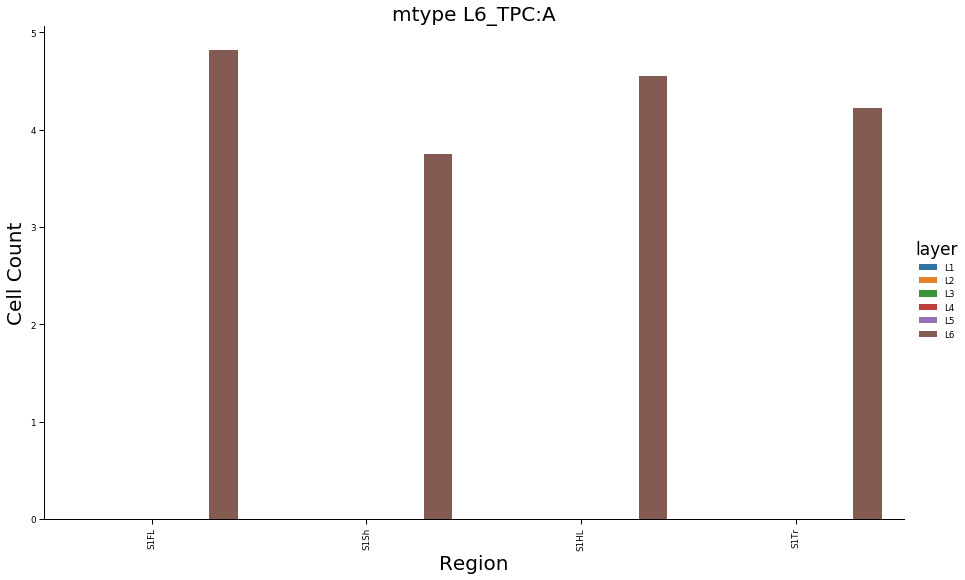

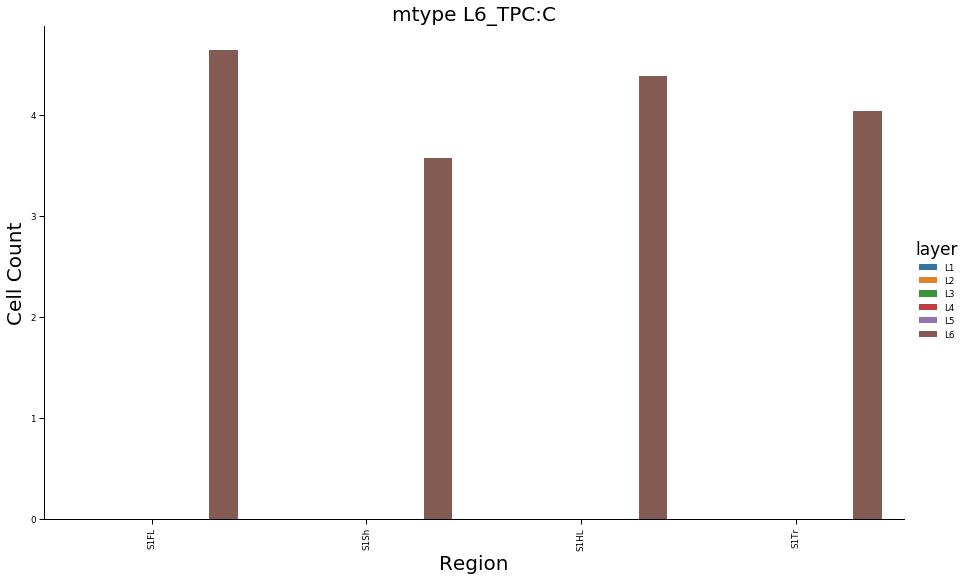

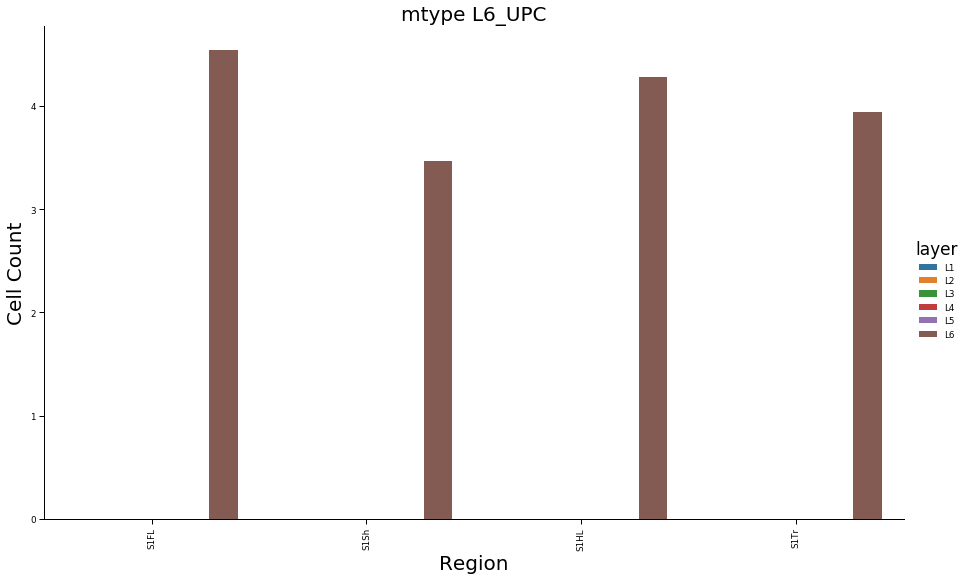

In [35]:
report_mtype_cell_counts =\
    analysis_mtype_cell_count(circuit_model, adapter)

In [24]:
reporter.post(report_mtype_cell_counts)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x7ffe791b7f98>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-09 13:00:50>                                                      
Post report mtype_cell_count_by_region_layer at
	 /gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/mtype_cell_count_

'/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/mtype_cell_count_by_region_layer/20200309/131845'

The analysis for mtype cell counts above counted cells by region, layer.
Count of mtypes by region will be more appropriate when we want to determine 
how to measure connectome properties.
We can define such an analysis:

In [36]:
analysis_regional_mtype_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["mtype_cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions, labels=["region"]),
        sample_measurement=measurement_mtype_cell_count_exhaustive,
        sample_size=1,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        measurement_collection=measurement.collection.series_type,
        plotter=MultiPlot(
            mvar="region",
            plotter=Bars(xvar="mtype",
                     xlabel="mtype",
                     yvar="mtype_cell_count",
                     ylabel="Cell Count")),
        report=CircuitAnalysisReport)

  0%|          | 0/4 [00:00<?, ?it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL'}



 25%|██▌       | 1/4 [00:03<00:11,  3.80s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh'}



 50%|█████     | 2/4 [00:05<00:06,  3.19s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL'}



 75%|███████▌  | 3/4 [00:08<00:03,  3.12s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr'}



100%|██████████| 4/4 [00:10<00:00,  2.83s/it]


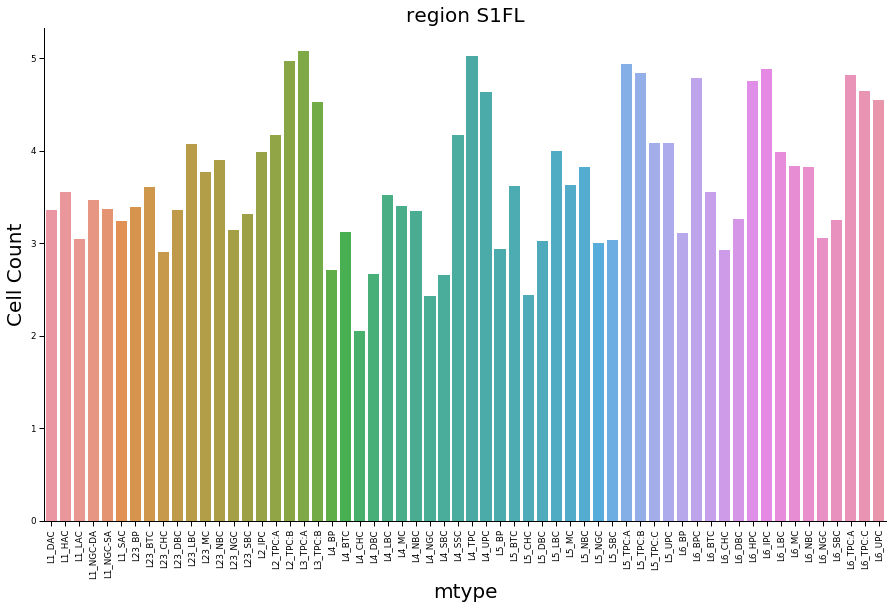

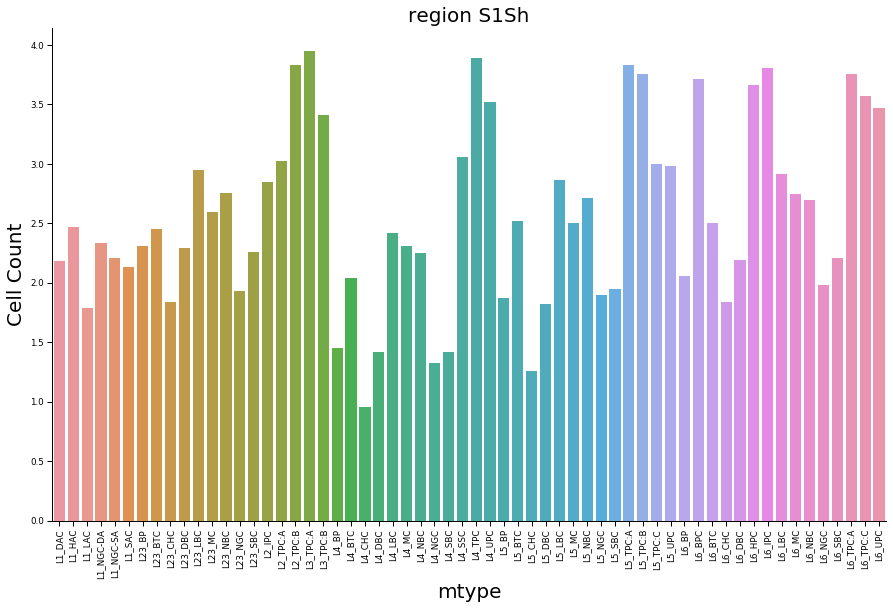

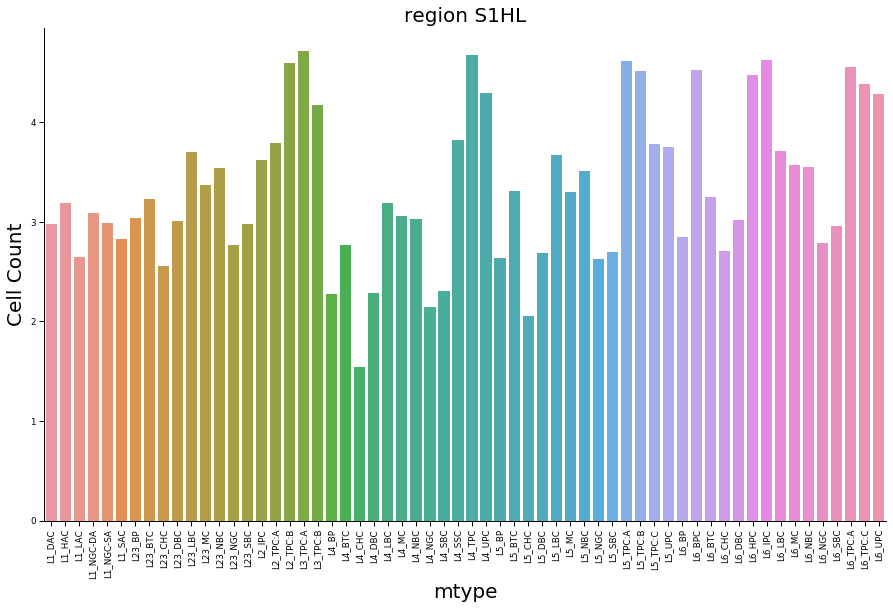

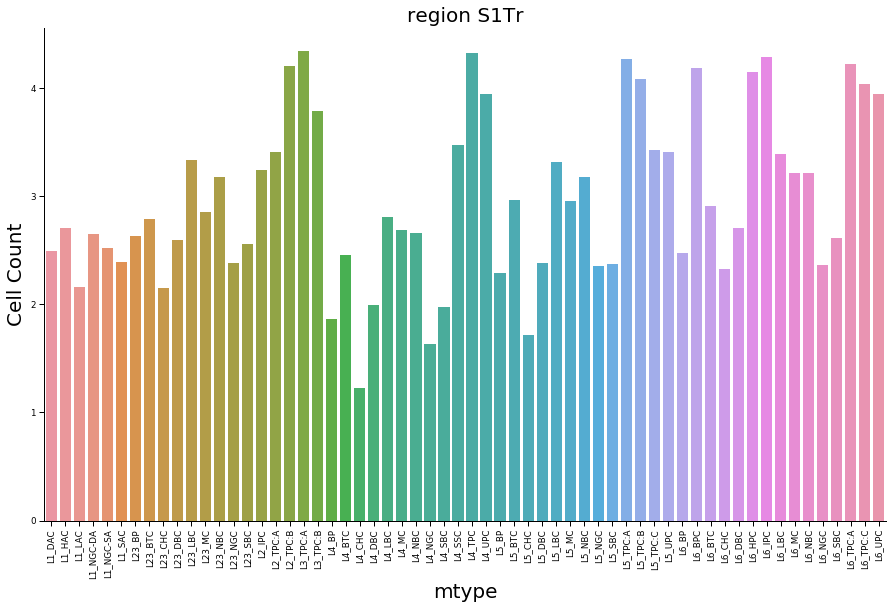

In [37]:
report_regional_mtype_cell_counts =\
    analysis_regional_mtype_cell_count(circuit_model, adapter)

In [39]:
mcc_s1hl =\
    report_regional_mtype_cell_counts.measurement.xs("S1HL", level="region")
mcc_s1hl.head()

mtype_cell_count
dataset               mtype                      
BlueBrainCircuitModel L1_DAC             2.983175
                      L1_HAC             3.190051
                      L1_LAC             2.642465
                      L1_NGC-DA          3.091315
                      L1_NGC-SA          2.988113

### Cell Density

The number of cells in an volume specified by a region and layer is determined 
by the size of volume.
We can take out the volume by analyzing cell densities.

In [102]:
def measurement_cell_density_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the density of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    
    if box is None:
        return 0.
    count_cells = adapter.get_cells(circuit_model, roi=box).shape[0]
    volume_spatial = box.volume
    return count_cells / volume_spatial

In [103]:
phenomenon["cell_density"] =\
    Phenomenon("Cell Density", 
               description="Number of cells in a unit volume.",
               group="Composition")
    
analysis_cell_density =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_density"],
        introduction="""
        Density of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_density_using_sampling,
        sample_size=20,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="cell_density",
                     ylabel="Cell Density",
                     gvar="region"),
        report=CircuitAnalysisReport)

In [104]:
report_cell_density = analysis_cell_density(circuit_model, adapter)





  0%|          | 0/480 [00:00<?, ?it/s]

NameError: name 'random_box' is not defined

In [59]:
reporter.post(report_cell_density)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-05 12:29:15>                                                      
Post report cell_density at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025



'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025'

# Connectome

The connectome of a circuit consists of synapses between the cells.

## Afferent connections of cells 

An afferent connection is an incoming connection,
and the cell in question the post-synaptic cell.
We have developed `PathwayMeasurement` to make connectome measurements 
on the circuit.
`PathwayMeasurement` allows setting up of the target cells,
the pathway to measure, and
to set a protocol on how to measure at initiation.

Next, we define an instance of `PathwayMeasurement` that will help us make 
pathway measurements.


In [22]:
reload(pm)
affdeg_batch =\
    pm.PathwayMeasurement(
        direction="AFF",
        value = lambda connections: 1,
        variable="number_connections_afferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        processing_methodology=terminology.processing_methodology.batch,
        batch_size=1000,
        return_primary_info=True,
        target=lambda adapter, circuit_model: adapter.get_cells(
            circuit_model, region="S1HL"))

In [30]:
listed_sample =[
    m for m in 
    affdeg_batch.sample(
        adapter, circuit_model,
        post_synaptic_cell_group={"mtype": "L6_TPC:A"})]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-12 18:14:31>                                                     
PathwayMeasurement.sample(...)
with sampling methodology exhaustive
pre-synaptic cell group {}
post-synaptic cell group {'mtype': 'L6_TPC:A'}
0it [00:00, ?it/s]================================================================================
/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-12 18:14:31>                                                     
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	556
	code_context: 	['                LOGGER.get_source_info(),\n']
	index: 0

batch 

In [78]:
listed_sample[0].dropna().shape[0], listed_sample[0].shape[0]

(13573, 13573)

In [71]:
m = pd.concat([
    s.groupby([("pre_synaptic_cell", "mtype")]).agg(["count", "sum"])
    for s in listed_sample])

def get_mean(df):
    s = df["sum"].values
    c = df["count"].values
    return df.assign(mean=s / c)

m.groupby([("pre_synaptic_cell", "mtype")])\
 .agg("sum")
  

number_connections_afferent       
                                                 count    sum
(pre_synaptic_cell, mtype)                                   
L1_DAC                                             621    722
L1_SLAC                                            614    714
L23_ChC                                           1149   1673
L23_MC                                            1147   1687
L23_SBC                                           1179   1744
L4_LBC                                             760    952
L4_NGC                                             809    979
L4_TPC                                            2132  18927
L5_DBC                                            1520   2580
L5_MC                                             1484   2543
L5_TPC:A                                          2089   8291
L5_TPC:B                                          2079   8572
L5_UPC                                            2089   8391
L6_ChC                                            1422   2282
L6_IPC                                            2123  10890
L6_MC                                             1419   2312
L6_TPC:A                                          2126  11155
L6_TPC:B                                          2124  11111
L6_UPC                                            2119  11174

In [73]:
nca = affdeg_batch.collect(
    lambda df: df.groupby(("pre_synaptic_cell", "mtype")).agg(["size", "count", "sum"]))
nca_l6_tpca = nca(circuit_model, adapter,
                  post_synaptic_cell_group={"mtype": "L6_TPC:A"})

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-12 18:14:31>                                                     
PathwayMeasurement.sample(...)
with sampling methodology exhaustive
pre-synaptic cell group {}
post-synaptic cell group {'mtype': 'L6_TPC:A'}


0it [00:00, ?it/s]================================================================================
/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-12 18:14:31>                                                     
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	556
	code_context: 	['                LOGGER.get_source_info(),\n']
	index: 0

batc

In [74]:
nca_l6_tpca

number_connections_afferent            
                                                  size count   sum
(pre_synaptic_cell, mtype)                                        
L1_DAC                                             288   288   336
L1_SLAC                                            262   262   306
L23_ChC                                            536   536   800
L23_MC                                             549   549   801
L23_SBC                                            529   529   783
L4_LBC                                             371   371   463
L4_NGC                                             384   384   470
L4_TPC                                            1000  1000  8941
L5_DBC                                             704   704  1231
L5_MC                                              688   688  1176
L5_TPC:A                                           981   981  3886
L5_TPC:B                                           977   977  3985
L5_UPC                                             976   976  3848
L6_ChC                                             676   676  1088
L6_IPC                                             996   996  5096
L6_MC                                              667   667  1108
L6_TPC:A                                           997   997  5233
L6_TPC:B                                           997   997  5240
L6_UPC                                             995   995  5255
L1_DAC                                             301   301   351
L1_SLAC                                            312   312   360
L23_ChC                                            541   541   765
L23_MC                                             524   524   776
L23_SBC                                            573   573   848
L4_LBC                                             354   354   445
L4_NGC                                             370   370   445
L4_TPC                                            1000  1000  8829
L5_DBC                                             723   723  1186
L5_MC                                              695   695  1200
L5_TPC:A                                           980   980  3909
L5_TPC:B                                           972   972  4046
L5_UPC                                             984   984  4025
L6_ChC                                             667   667  1072
L6_IPC                                             995   995  5183
L6_MC                                              665   665  1065
L6_TPC:A                                           997   997  5243
L6_TPC:B                                           995   995  5204
L6_UPC                                             993   993  5212
L1_DAC                                              32    32    35
L1_SLAC                                             40    40    48
L23_ChC                                             72    72   108
L23_MC                                              74    74   110
L23_SBC                                             77    77   113
L4_LBC                                              35    35    44
L4_NGC                                              55    55    64
L4_TPC                                             132   132  1157
L5_DBC                                              93    93   163
L5_MC                                              101   101   167
L5_TPC:A                                           128   128   496
L5_TPC:B                                           130   130   541
L5_UPC                                             129   129   518
L6_ChC                                              79    79   122
L6_IPC                                             132   132   611
L6_MC                                               87    87   139
L6_TPC:A                                           132   132   679
L6_TPC:B                                           132   132   667
L6_UPC                                             131   131   707

In [13]:
reload(ca)
phenomenon["afferent_degree"] =\
    Phenomenon(
        "Number Connections Afferent",
        description="Number of afferent connections",
        group="Connectome")

def get_mtypes(adapter, circuit_model):
    return pd.DataFrame(
        adapter.get_mtypes(circuit_model),
        columns=pd.MultiIndex.from_tuples(
            [("post_synaptic_cell_group", "mtype")]))

def number_connections_afferent(
    circuit_model,
    adapter,
    sampling_methodology=None,
    **p):
    return\
        affdeg_batch.collect(
            adapter, circuit_model, 
            **p)
    
analysis_affdeg =\
    ca.BrainCircuitAnalysis(
        phenomenon=phenomenon["afferent_degree"],
        introduction="""
        Number of afferent connections of a cell.
        """,
        methods="""
        Number of afferent connections were counted by mtype.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_mtypes),
        sample_measurement=number_connections_afferent,
        processing_methodology=terminology.processing_methodology.serial,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        measurement_collection=measurement.collection.series_type,
        plotter=MultiPlot(
            mvar=("post_synaptic_cell", "mtype"),
            plotter=Bars(
                xvar=("pre_synaptic_cell", "mtype"),
                xlabel="pre-mtype",
                yvar="number_connections_afferent",
                ylabel="Afferent Degree")),
        report=CircuitAnalysisReport)

  0%|          | 0/19 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.65s/it]
  5%|▌         | 1/19 [00:04<01:15,  4.19s/it]
0it [00:00, ?it/s]
1it [00:02,  2.21s/it]
 11%|█         | 2/19 [00:08<01:09,  4.08s/it]
0it [00:00, ?it/s]
1it [00:04,  4.80s/it]
 16%|█▌        | 3/19 [00:14<01:19,  4.95s/it]
0it [00:00, ?it/s]
1it [00:04,  4.94s/it]
 21%|██        | 4/19 [00:22<01:24,  5.61s/it]
0it [00:00, ?it/s]
1it [00:05,  5.16s/it]
 26%|██▋       | 5/19 [00:29<01:26,  6.16s/it]
0it [00:00, ?it/s]
1it [00:02,  2.76s/it]
 32%|███▏      | 6/19 [00:33<01:13,  5.63s/it]
0it [00:00, ?it/s]
1it [00:02,  2.83s/it]
 37%|███▋      | 7/19 [00:38<01:03,  5.31s/it]
0it [00:00, ?it/s]
1it [00:14, 14.61s/it]
2it [00:30, 14.87s/it]
3it [00:44, 14.77s/it]
4it [00:54, 13.51s/it]
 42%|████▏     | 8/19 [01:48<04:31, 24.72s/it]
0it [00:00, ?it/s]
1it [00:06,  6.66s/it]
 47%|████▋     | 9/19 [01:57<03:21, 20.11s/it]
0it [00:00, ?it/s]
1it [00:06,  6.75s/it]
 53%|█████▎    | 10/19 [02:07<02:32, 16.93s/it]
0

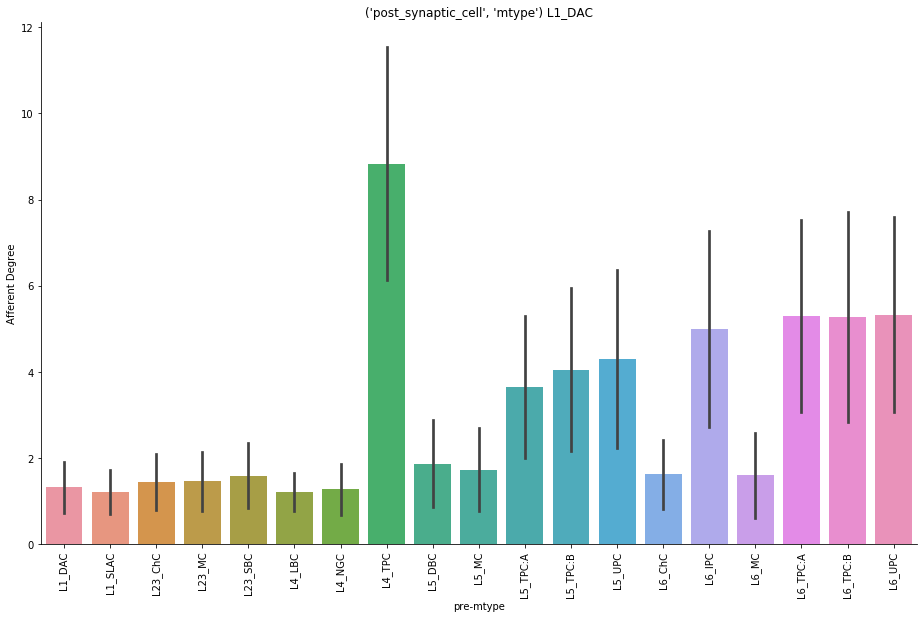

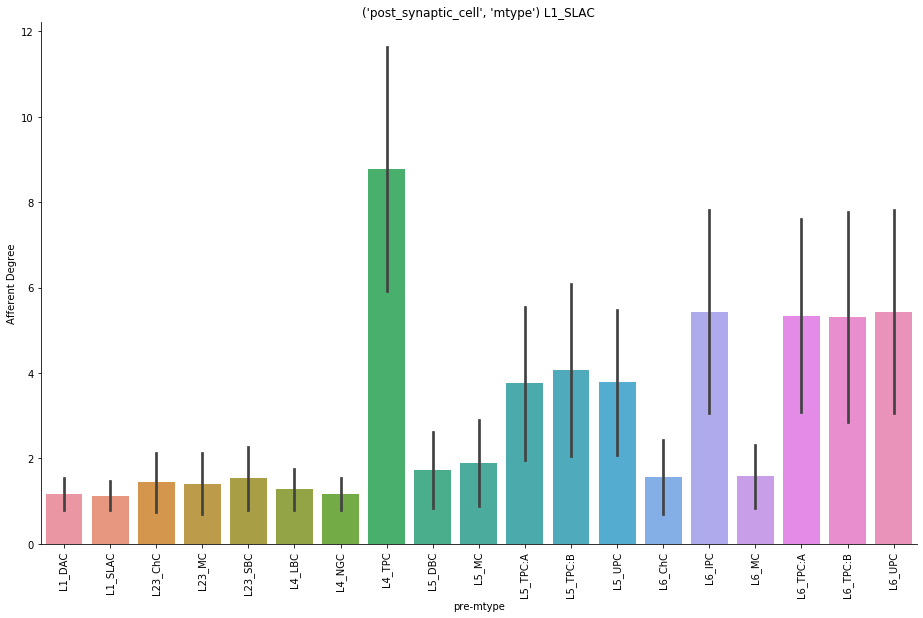

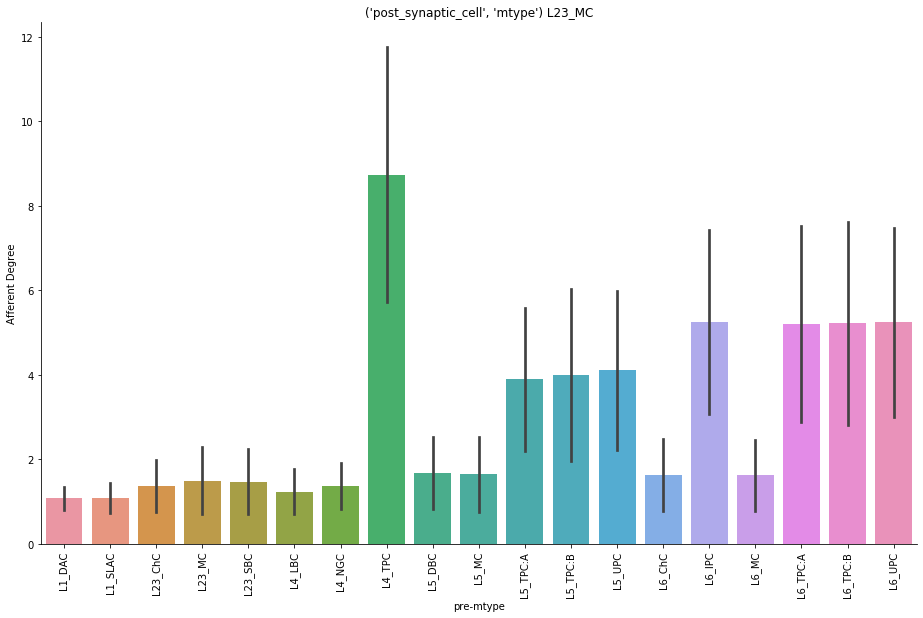

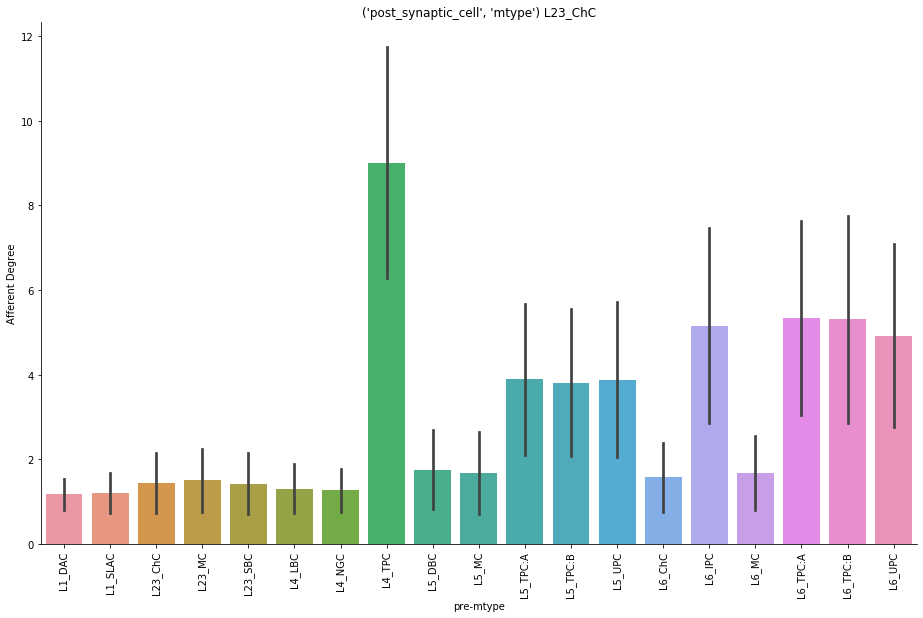

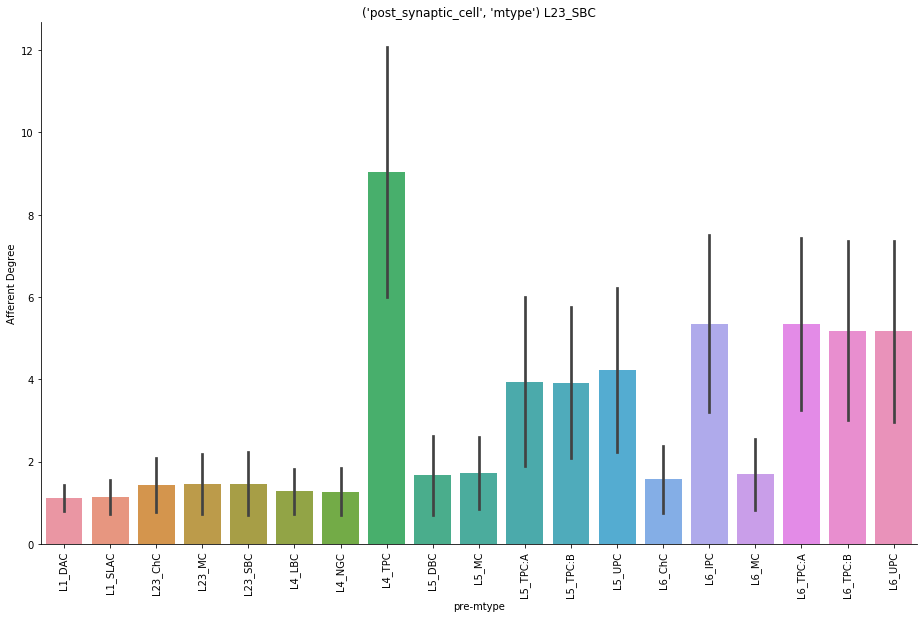

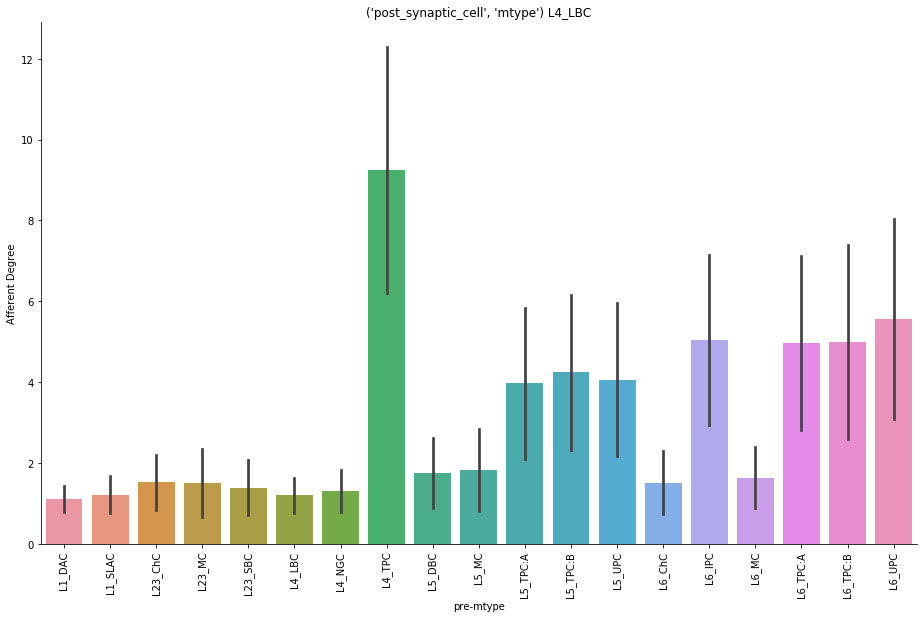

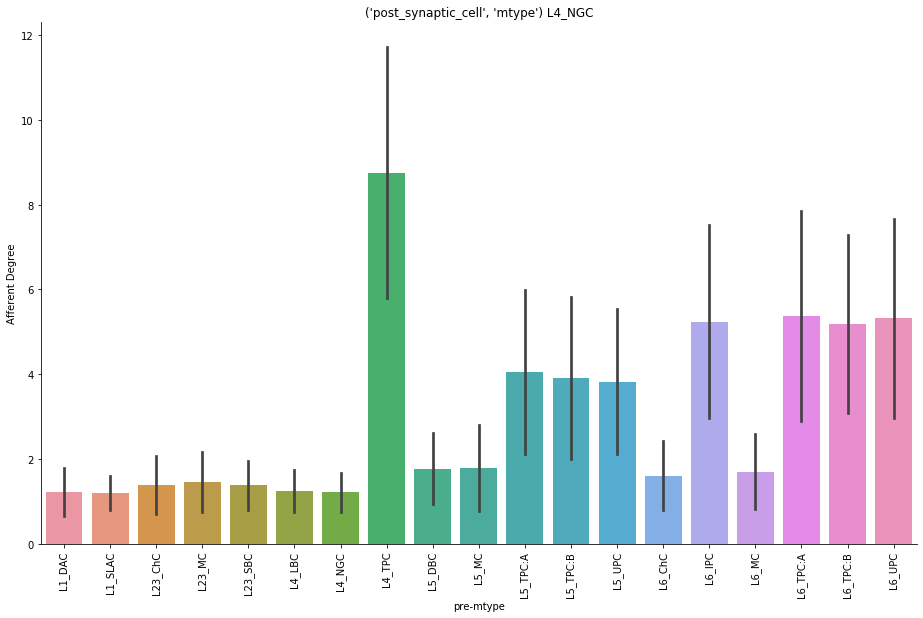

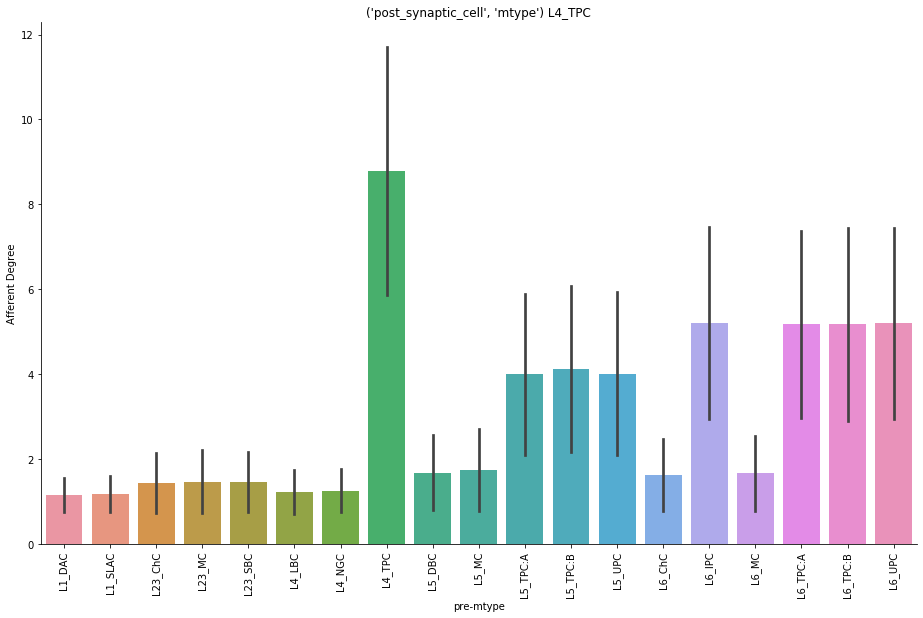

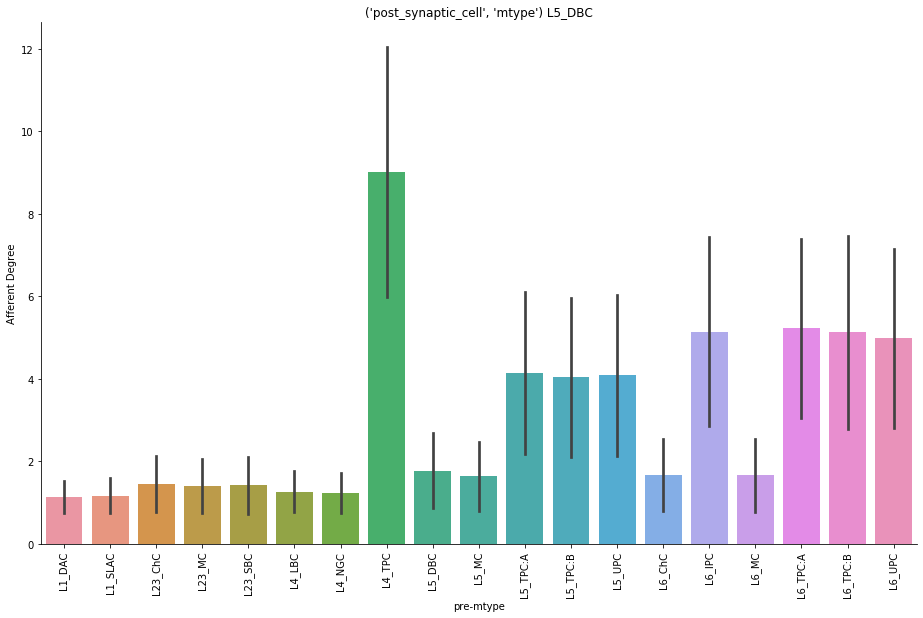

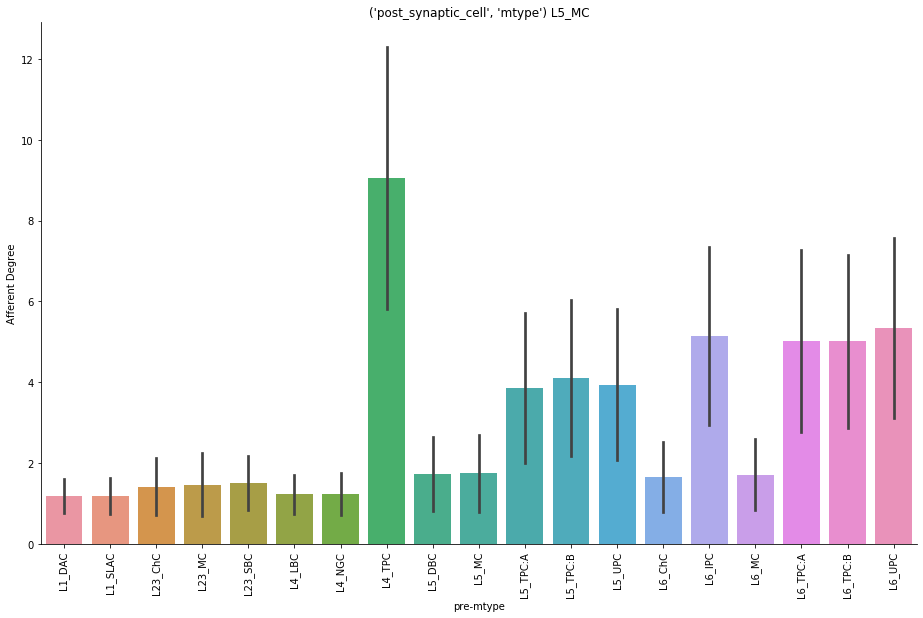

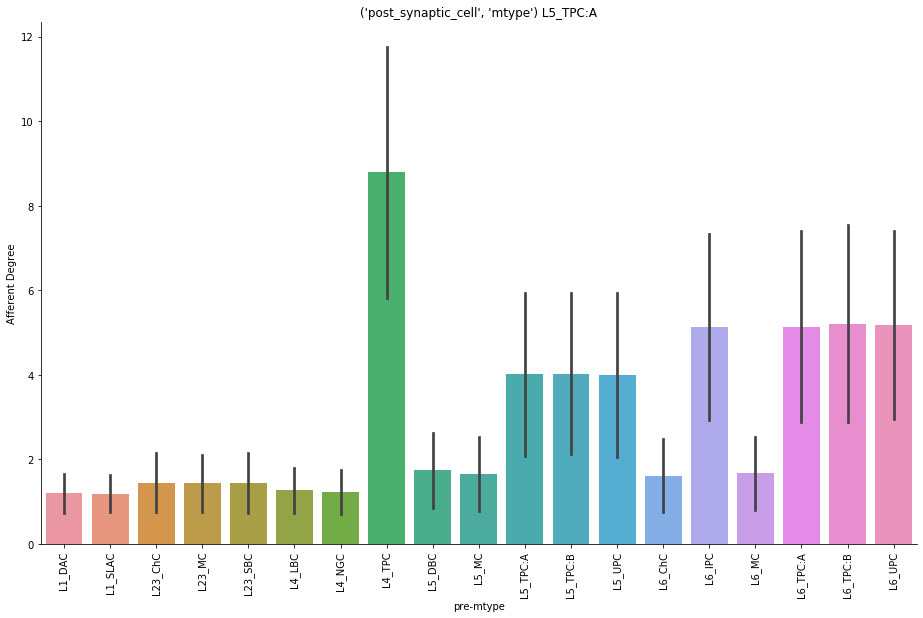

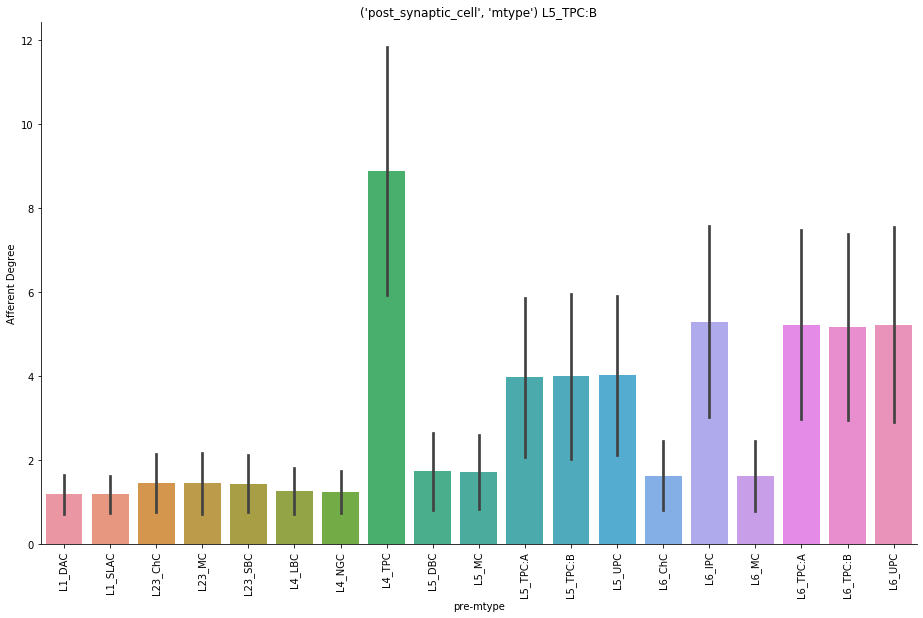

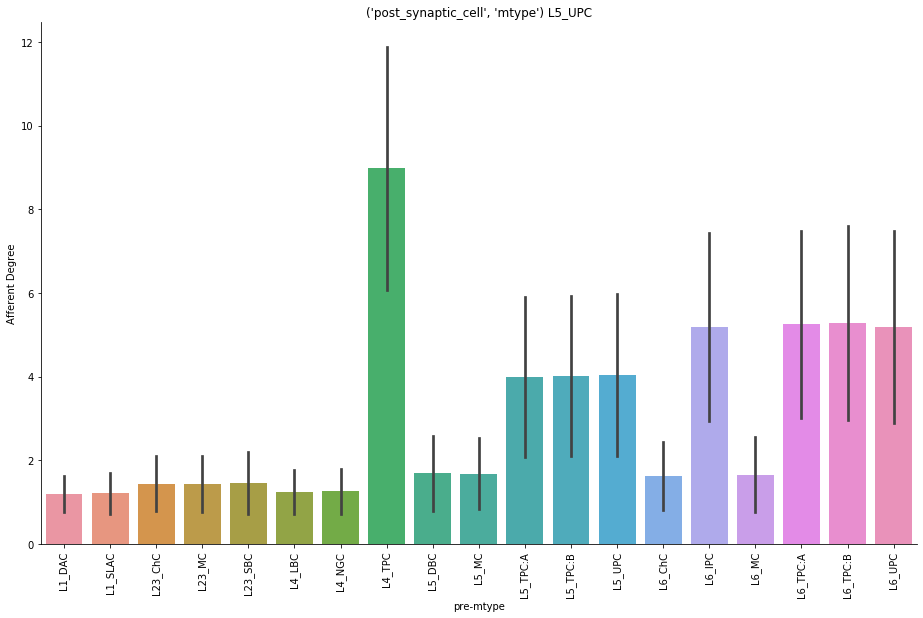

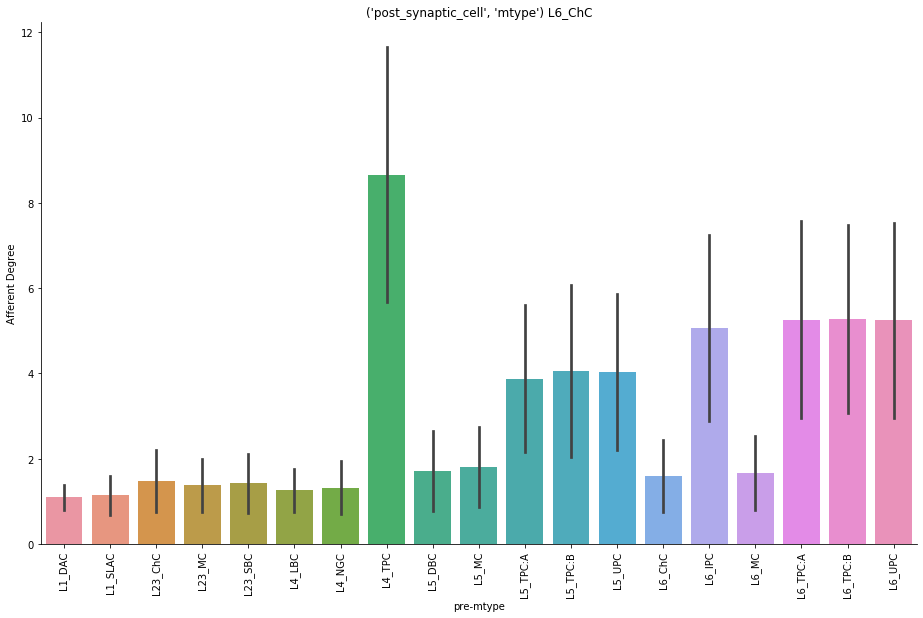

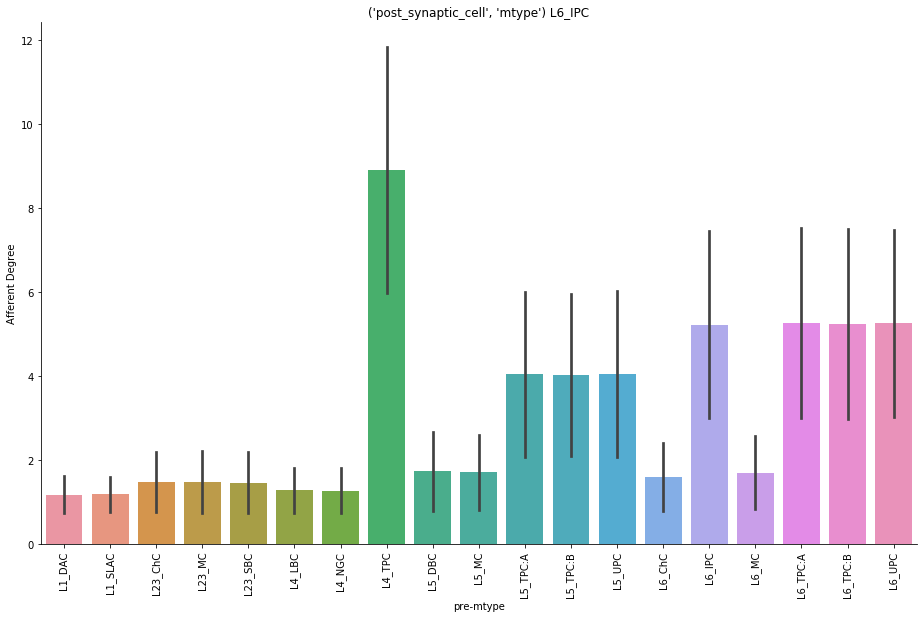

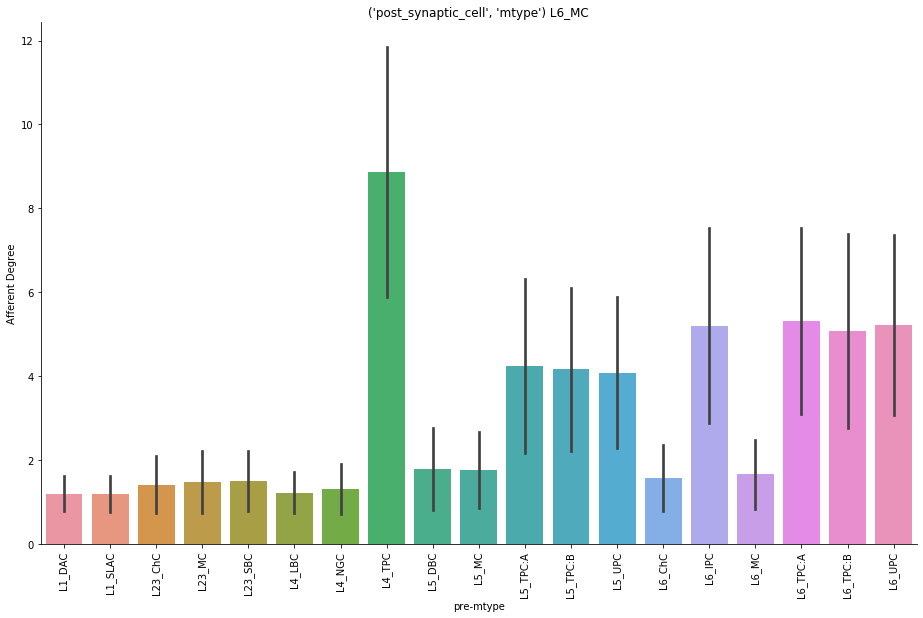

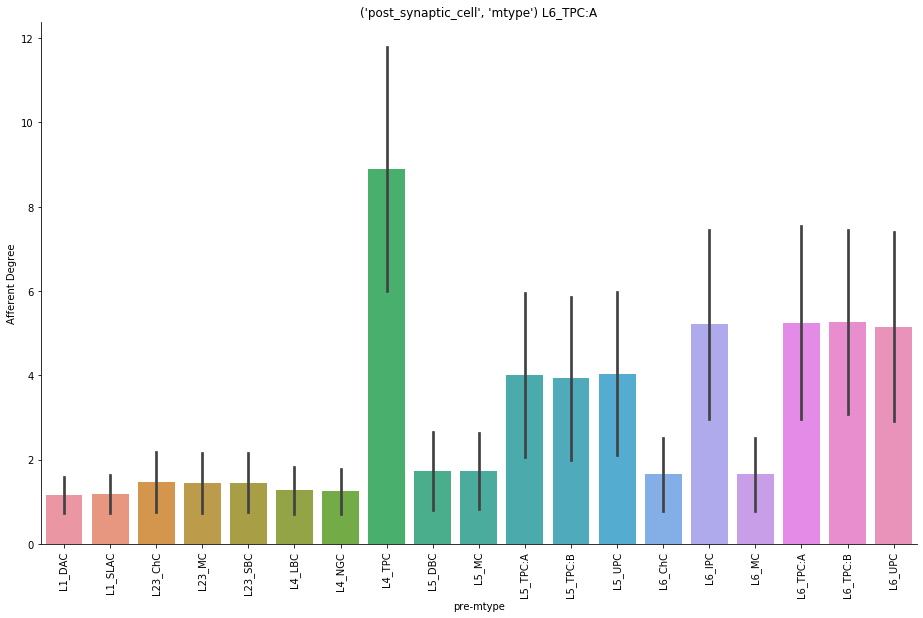

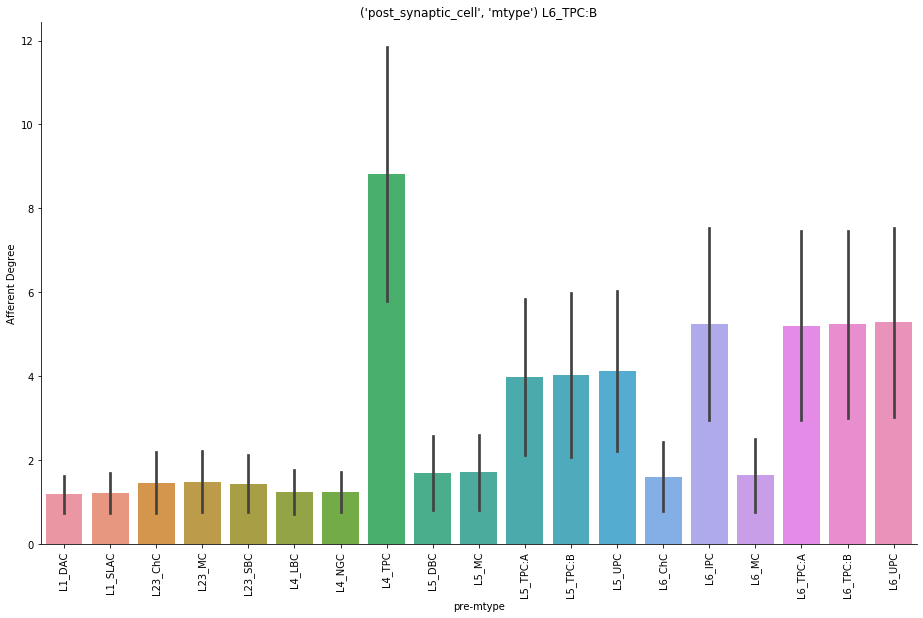

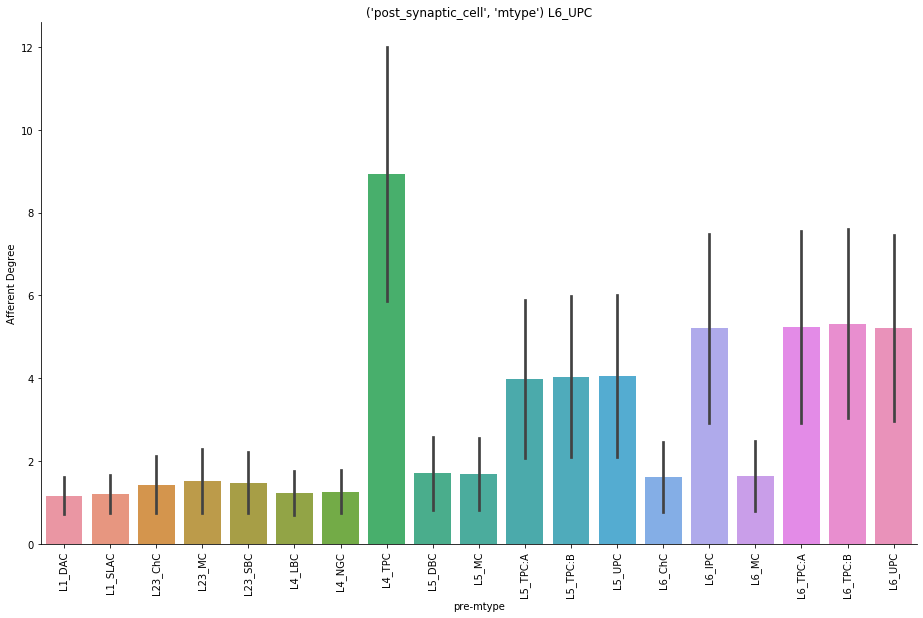

In [14]:
reload(rp)
reporter = rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))
posted_reports =\
    reporter.post(
        analysis_affdeg(
            circuit_model, adapter))

In [15]:
posted_reports

{'post_synaptic_cell_group_mtype_l1_dac': '/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/number_connections_afferent-by-post_synaptic_cell_group-mtype/20200311/110626/post_synaptic_cell_group_mtype_l1_dac',
 'post_synaptic_cell_group_mtype_l1_slac': '/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/number_connections_afferent-by-post_synaptic_cell_group-mtype/20200311/110626/post_synaptic_cell_group_mtype_l1_slac',
 'post_synaptic_cell_group_mtype_l23_mc': '/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/number_connections_afferent-by-post_synaptic_cell_group-mtype/20200311/110626/post_synaptic_cell_group_mtype_l23_mc',
 'post_synaptic_cell_group_mtype_l23_chc': '/Users/vishalsoodmuchu/work/bbp/work/validati

### Setting pathway measurement targets

We can set cell targets for a circuit at initiation of a `PathwayMeasurements`.
All queries for post / pre synaptic cells will be made from the pool of cells
set in the target. If no target is set for a circuit at instantiation, then 
either all circuit cells will be used, or a subset of all cells will be used.

However, setting the target at initialization allows us to specify any group of
cells as the target. We can pass in a dataframe of cells or a callable.

Let us experiment with this feature.

In [310]:
reload(pm)
affdeg_batch =\
    pm.PathwayMeasurement(
        direction="AFF",
        value = lambda connections: 1,
        variable="number_connections_afferent",
        specifiers_cell_type=["mtype"],
        by_soma_distance=True,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        processing_methodology=terminology.processing_methodology.batch,
        batch_size=1000,
        return_primary_info=True,
        target=lambda mod, adp: adp.get_cells(mod, region="S1HL"))
sample_affdeg_batch =\
    affdeg_batch.sample(
        adapter, circuit_model)

In [186]:
from neuro_dmt.library.users.visood.sscx_dissemination.analyses\
    import connectome

In [187]:
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.connectome.suite\
    import AdapterInterface

In [301]:
samples =\
    [s for s in
     affdeg_batch.sample(
         circuit_model, adapter,
         post_synaptic_cell_group={"mtype": "L6_TPC:A"},
         prefixed=False)]


/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
PathwayMeasurement.sample(...)
with sampling methodology exhaustive
pre-synaptic cell group {}
post-synaptic cell group {'mtype': 'L6_TPC:A'}






0it [00:00, ?it/s]================================================================================
/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
Traceback:
	filename: 	/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	651
	code_context: 	['                LOGGER.get_source_info(),\n']
	index: 0

batch 0: number cells:  1000
/home/muchu/work/bbp/work/validations

In [302]:
samples[0].head()

mtype   post_gid  soma_distance
L1_DAC  14181     1650.0           1
        14185     1450.0           1
        14192     1450.0           1
        14193     1450.0           1
        14198     1450.0           1
Name: number_connections_afferent, dtype: int64

In [303]:
pandamonium = affdeg_batch.pandamonad

In [304]:
summary =\
    affdeg_batch.collector(
        prefixed=False)
summary(
    circuit_model, adapter,
    post_synaptic_cell_group={"mtype": "L6_TPC:A"})

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
PathwayMeasurement.sample(...)
with sampling methodology exhaustive
pre-synaptic cell group {}
post-synaptic cell group {'mtype': 'L6_TPC:A'}






0it [00:00, ?it/s]================================================================================
/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
Traceback:
	filename: 	/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	651
	code_context: 	['                LOGGER.get_source_info(),\n']
	index: 0

batch 0: number cells:  1000
/home/muchu/work/bbp/work/validations

mtype   post_gid  soma_distance
L1_DAC  14181     1650.0           1
        14185     1450.0           1
        14192     1450.0           1
        14193     1450.0           1
        14198     1450.0           1
        14202     1550.0           1
        14203     1150.0           1
        14210     1750.0           1
        14212     1350.0           1
        14214     1550.0           1
        14218     1350.0           1
        14220     1450.0           1
        14222     1550.0           1
        14228     1450.0           1
        14231     1450.0           1
        14233     1650.0           1
        14235     1750.0           1
        14236     1250.0           1
        14240     1450.0           1
        14246     1350.0           1
        14247     1150.0           1
        14250     1650.0           1
        14251     1250.0           1
        14256     1650.0           1
        14257     1750.0           1
                  1850.0           1
      

In [311]:
summary =\
    affdeg_batch.collector(
        aggregate=affdeg_batch.pandamonad.moments,
        prefixed=True)
summary(
    circuit_model, adapter,
    post_synaptic_cell_group={"mtype": "L6_TPC:A"})

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
PathwayMeasurement.sample(...)
with sampling methodology exhaustive
pre-synaptic cell group {}
post-synaptic cell group {'mtype': 'L6_TPC:A'}






0it [00:00, ?it/s]================================================================================
/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
Traceback:
	filename: 	/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	650
	code_context: 	['                LOGGER.get_source_info(),\n']
	index: 0

batch 0: number cells:  1000
/home/muchu/work/bbp/work/validations

_count  _sum_1  _sum_2
(pre_synaptic_cell, mtype) soma_distance                        
L1_DAC                     1150.0           62.0    68.0    80.0
                           1250.0          105.0   118.0   144.0
                           1350.0           95.0   103.0   119.0
                           1450.0          102.0   111.0   129.0
                           1550.0           95.0   102.0   116.0
                           1650.0           87.0   102.0   134.0
                           1750.0           69.0    82.0   114.0
L1_SLAC                    1150.0           56.0    60.0    70.0
                           1250.0          120.0   129.0   147.0
                           1350.0          116.0   127.0   151.0
                           1450.0          102.0   107.0   117.0
                           1550.0           97.0   105.0   121.0
                           1650.0           99.0   110.0   132.0
                           1750.0           69.0    79.0   101.0
L23_ChC                    750.0            28.0    28.0    28.0
                           850.0            80.0    83.0    89.0
                           950.0           124.0   130.0   142.0
                           1050.0          192.0   205.0   233.0
                           1150.0          224.0   244.0   284.0
                           1250.0          235.0   260.0   314.0
                           1350.0          237.0   264.0   330.0
                           1450.0          202.0   237.0   323.0
                           1550.0          153.0   167.0   199.0
                           1650.0           87.0    98.0   124.0
L23_MC                     850.0            73.0    75.0    79.0
                           950.0           105.0   114.0   132.0
                           1050.0          206.0   227.0   277.0
                           1150.0          231.0   252.0   296.0
                           1250.0          235.0   264.0   326.0
                           1350.0          225.0   252.0   310.0
...                                          ...     ...     ...
L6_IPC                     550.0           466.0   633.0  1043.0
                           650.0            71.0    85.0   115.0
L6_MC                      50.0            160.0   168.0   184.0
                           150.0           568.0   649.0   817.0
                           250.0           619.0   734.0   986.0
                           350.0           370.0   395.0   445.0
                           450.0           262.0   281.0   323.0
                           550.0           125.0   138.0   168.0
                           650.0            22.0    23.0    25.0
L6_TPC:A                   50.0            637.0   772.0  1060.0
                           150.0          1588.0  3131.0  8047.0
                           250.0          1625.0  3268.0  8842.0
                           350.0          1251.0  1883.0  3551.0
                           450.0           879.0  1223.0  2085.0
                           550.0           438.0   607.0  1033.0
                           650.0            79.0    84.0    96.0
L6_TPC:B                   50.0            663.0   813.0  1175.0
                           150.0          1599.0  3198.0  8394.0
                           250.0          1620.0  3234.0  8628.0
                           350.0          1279.0  1958.0  3818.0
                           450.0           853.0  1203.0  2101.0
                           550.0           488.0   693.0  1199.0
                           650.0            93.0   104.0   126.0
L6_UPC                     50.0            625.0   774.0  1106.0
                           150.0          1598.0  3073.0  7737.0
                           250.0          1631.0  3179.0  8187.0
                           350.0          1288.0  1961.0  3665.0
                           450.0           830.0  1196.0  2142.0
                           550.0           466.0   658.0  1162.0
            

In [298]:
summary_nca =\
    affdeg_batch.collector(
        aggregate=affdeg_batch.pandamonad.moments,
        transform=lambda df: pd.Series({
                 "std": np.sqrt(df._sum_2 / df._count),
                 "mean": df._sum_1 / df._count}),
        prefixed=True)
summary_nca(
    circuit_model, adapter,
    post_synaptic_cell_group={"mtype": "L6_TPC:A"})

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
PathwayMeasurement.sample(...)
with sampling methodology exhaustive
pre-synaptic cell group {}
post-synaptic cell group {'mtype': 'L6_TPC:A'}






0it [00:00, ?it/s]================================================================================
/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
Traceback:
	filename: 	/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	651
	code_context: 	['                LOGGER.get_source_info(),\n']
	index: 0

batch 0: number cells:  1000
/home/muchu/work/bbp/work/validations

,std,mean
mtype,,
L1_DAC,1.293230,1.204506
L1_SLAC,1.239193,1.169903
L23_ChC,1.583099,1.422663
L23_MC,1.620152,1.455178
L23_SBC,1.602767,1.436270
L4_LBC,1.352386,1.255263
L4_NGC,1.349239,1.251638
L4_TPC,9.341732,8.850305
L5_DBC,1.944511,1.711513


In [279]:
summary_nca =\
    affdeg_batch.collector(
        aggregate=affdeg_batch.pandamonad.moments,
        transform=lambda df: pd.Series({
                 "std": np.sqrt(df._sum_2 / df._count),
                 "mean": df._sum_1 / df._count}),
        prefixed=False)
summary_nca(
    adapter, circuit_model,
    post_synaptic_cell_group={"mtype": "L6_TPC:A"})


/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
PathwayMeasurement.sample(...)
with sampling methodology exhaustive
pre-synaptic cell group {}
post-synaptic cell group {'mtype': 'L6_TPC:A'}




0it [00:00, ?it/s]================================================================================
/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
ALERT@<2020-03-13 11:00:35>                                                     
Traceback:
	filename: 	/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	651
	code_context: 	['                LOGGER.get_source_info(),\n']
	index: 0

batch 0: number cells:  1000
/home/muchu/work/bbp/work/validations/d

,std,mean
mtype,,
L1_DAC,1.293230,1.204506
L1_SLAC,1.239193,1.169903
L23_ChC,1.583099,1.422663
L23_MC,1.620152,1.455178
L23_SBC,1.602767,1.436270
L4_LBC,1.352386,1.255263
L4_NGC,1.349239,1.251638
L4_TPC,9.341732,8.850305
L5_DBC,1.944511,1.711513
